In [1]:
# import library
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

import tensorflow as tf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# seed
import os
seed = 123
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

In [2]:
# load dataset
diabetes = load_diabetes()

# dataframe
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.DataFrame(diabetes.target, columns=["Target"])
df = pd.concat([data, target], axis=1)
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [3]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


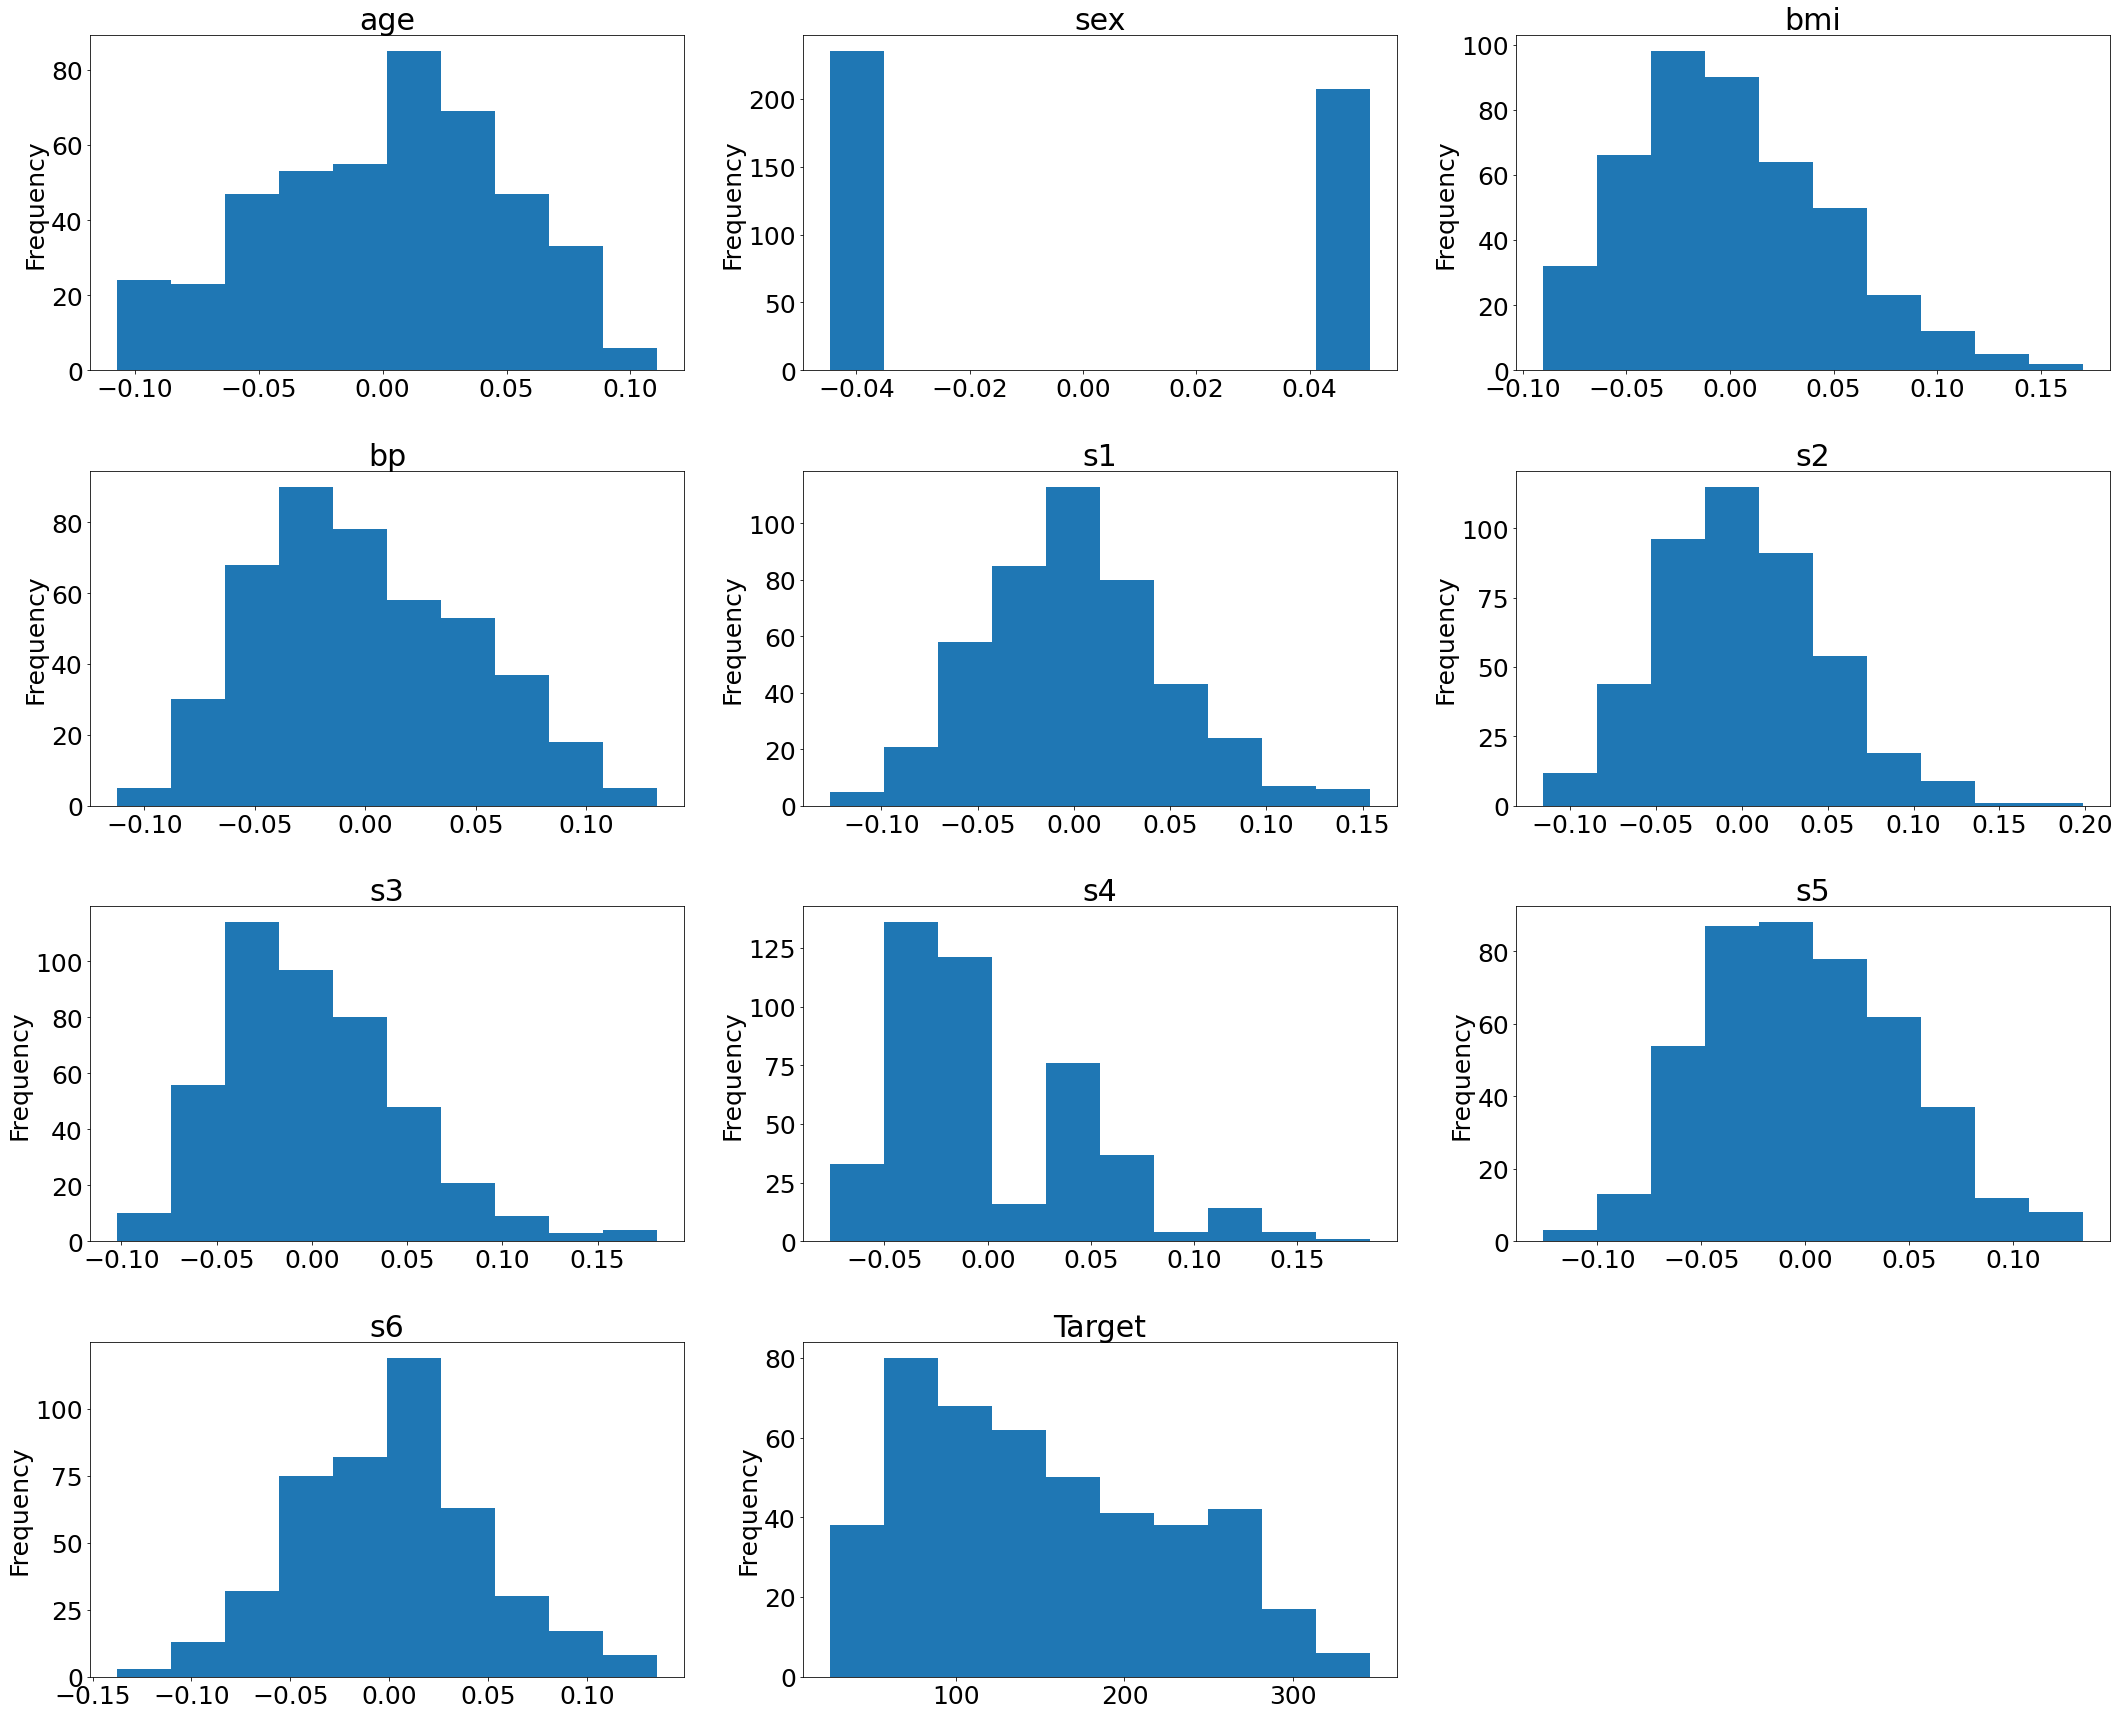

In [4]:
# data distribution
plt.figure(figsize=(30,30))
for i in range(len(df.columns)):
    plt.rc('font', size=25)
    plt.subplot(5,3,i+1)
    df[df.columns[i]].plot.hist()
    plt.title(f'{df.columns[i]}')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

## Feature importance

In [5]:
# dataset
x = diabetes.data
y = diabetes.target

In [6]:
# Decision Tree
def tree_model(data, label):
    tree = DecisionTreeRegressor(criterion='mse', max_depth=None,
                                 random_state=seed, min_samples_leaf=1,
                                 min_samples_split=2, splitter='best')
    tree_fit = tree.fit(data, label)
    #print(tree.feature_importances_)
    
    Importance = pd.DataFrame({'Importance':tree.feature_importances_*100}, 
                              index=diabetes.feature_names)
    plt.rc('font', size=8)
    Importance.sort_values(by='Importance', axis=0,
                           ascending=True).plot(kind='barh', color='r')
    plt.title('Decision tree')
    plt.xlabel('Feature importance')

# RandomForest
def rf_model(data, label):
    rf = RandomForestRegressor(n_estimators=50, criterion='mse', 
                               max_depth=None, random_state=seed, 
                               min_samples_leaf=1, min_samples_split=2, 
                               min_impurity_split=None)
    rf_fit = rf.fit(data, label)
    #print(rf.feature_importances_)
    Importance = pd.DataFrame({'Importance':rf.feature_importances_*100},
                              index=diabetes.feature_names)
    plt.rc('font', size=8)
    Importance.sort_values(by='Importance', axis=0,
                           ascending=True).plot(kind='barh', color='r')
    plt.title('Random forest')
    plt.xlabel('Feature importance')
    
# AdaBoost
def adabst_model(data, label):
    adabst = AdaBoostRegressor(base_estimator=None, n_estimators=50, 
                               learning_rate=1.0, loss='linear', 
                               random_state=seed)
    adabst_fit = adabst.fit(data, label)
    #print(adabst.feature_importances_)
    Importance = pd.DataFrame({'Importance':adabst.feature_importances_*100}, 
                              index=diabetes.feature_names)
    plt.rc('font', size=8)
    Importance.sort_values(by='Importance', axis=0,
                           ascending=True).plot(kind='barh', color='r')
    plt.title('Adaboost')
    plt.xlabel('Feature importance')
    
# Xgboost
def xgb_model(data, label):
    xgb = XGBRegressor(n_estimators=50, random_state=seed)
    xgb_fit = xgb.fit(data, label)
    #print(xgb.feature_importances_)
    Importance = pd.DataFrame({'Importance':xgb.feature_importances_*100},
                              index=diabetes.feature_names)
    Importance.sort_values(by='Importance', axis=0, 
                           ascending=True).plot(kind='barh', color='r')
    plt.title('Xgboost')
    plt.xlabel('Feature importance')
    plt.rc('font', size=8)

# lightGBM
def lgbm_model(data, label):
    lgbm = LGBMRegressor(n_estimators=50, random_state=seed)
    lgbm_fit = lgbm.fit(data, label)
    #print(lgbm.feature_importances_)
    Importance = pd.DataFrame({'Importance':lgbm.feature_importances_},
                              index=diabetes.feature_names)
    plt.rc('font', size=8)
    Importance.sort_values(by='Importance', axis=0, 
                           ascending=True).plot(kind='barh', color='r')
    plt.title('LightGBM')
    plt.xlabel('Feature importance')

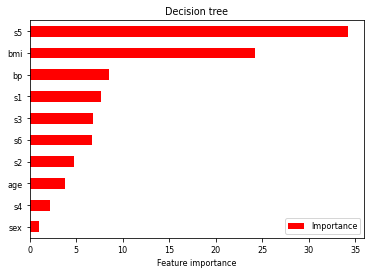

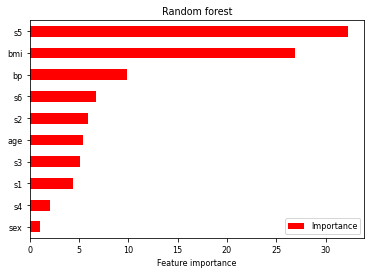

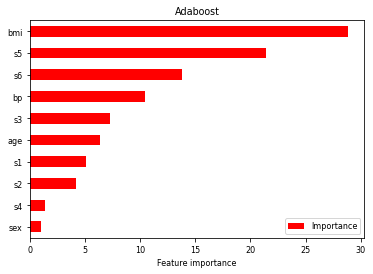

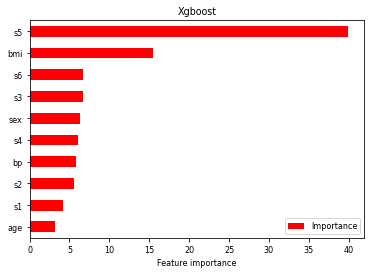

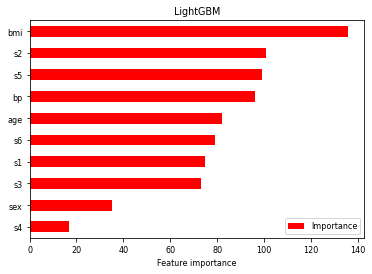

In [7]:
tree_model(x, y)
rf_model(x, y)
adabst_model(x, y)
xgb_model(x, y)
lgbm_model(x, y)

## Data preprocessing

In [8]:
# data preprocess
def prepro(data, method):
    if method == 'minmax':
        scaler = MinMaxScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'stand':
        scaler = StandardScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'robust':
        scaler = RobustScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'maxabs':
        scaler = MaxAbsScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)

In [9]:
# PCA
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum)

n = np.argmax(cumsum >= 0.95) + 1
print(n)

def pca_data(data, n):
    pca = PCA(n_components=n)
    x = data.copy()
    w = pca.fit_transform(x)
    return w

[0.40242142 0.55165324 0.67224947 0.76779711 0.83401567 0.89428759
 0.94794364 0.99131196 0.99914395 1.        ]
8


In [10]:
x_minmax = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_minmax[:,i] = prepro(x[:,i], 'minmax')

x_stand = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_stand[:,i] = prepro(x[:,i], 'stand')

x_robust = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_robust[:,i] = prepro(x[:,i], 'robust')

x_maxabs = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_maxabs[:,i] = prepro(x[:,i], 'maxabs')

x_pca_7 = pca_data(x, 7)
x_pca_8 = pca_data(x, 8)

print(x_minmax.shape)
print(x_stand.shape)
print(x_robust.shape)
print(x_maxabs.shape)
print(x_pca_7.shape)
print(x_pca_8.shape)

(442, 10)
(442, 10)
(442, 10)
(442, 10)
(442, 7)
(442, 8)


## Hyperparameter tuning

### Grid search / Random search

In [11]:
def DNN(data=x_minmax, drop=0.2, optimizer='adam'):
    x_train = data.shape[1]
    model_input = Input(shape=x_train)
    x = Dense(100, activation='selu')(model_input)
    x = Dropout(drop)(x)
    x = Dense(50, activation='selu')(x)
    x = Dropout(drop)(x)
    x = Dense(10, activation='selu')(x)
    x = Dropout(drop)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=model_input, outputs=outputs)
    model.compile(optimizer = optimizer, metrics = ['mse'],
                  loss = 'mse')
    
    return model

def hyperparameters():
    dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
    batches = [1, 8, 16, 32]
    epochs = [10, 30, 50]
    optimizers = ['adam', 'adadelta', 'rmsprop']
    return {'drop':dropout, 'batch_size':batches, 'epochs':epochs, 'optimizer':optimizers}
hyper = hyperparameters()

def DNN_pca7(data=x_pca_7, drop=0.2, optimizer='adam'):
    x_train = data.shape[1]
    model_input = Input(shape=x_train)
    #x = Dense(100, activation='selu')(model_input)
    #x = Dropout(drop)(x)
    x = Dense(50, activation='selu')(model_input)
    x = Dropout(drop)(x)
    x = Dense(10, activation='selu')(x)
    x = Dropout(drop)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=model_input, outputs=outputs)
    model.compile(optimizer = optimizer, metrics = ['mse'],
                  loss = 'mse')
    
    return model

def DNN_pca8(data=x_pca_8, drop=0.2, optimizer='adam'):
    x_train = data.shape[1]
    model_input = Input(shape=x_train)
    #x = Dense(100, activation='selu')(model_input)
    #x = Dropout(drop)(x)
    x = Dense(50, activation='selu')(model_input)
    x = Dropout(drop)(x)
    x = Dense(10, activation='selu')(x)
    x = Dropout(drop)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=model_input, outputs=outputs)
    model.compile(optimizer = optimizer, metrics = ['mse'],
                  loss = 'mse')
    
    return model

In [12]:
def best_model(data, label, search_method):
    model = KerasRegressor(build_fn = DNN, verbose=1)
    if search_method == 'grid':
        search = GridSearchCV(model, hyper, cv=5)
        best_search = search.fit(data, label, verbose=2)
        best_param = search.best_params_
        return best_search, best_param
    if search_method == 'random':
        search = RandomizedSearchCV(model, hyper, cv=5)
        best_search = search.fit(data, label, verbose=2)
        best_param = search.best_params_
        return best_search, best_param
    
def best_model_pca7(data, label, search_method):
    model = KerasRegressor(build_fn = DNN_pca7, verbose=1)
    if search_method == 'grid':
        search = GridSearchCV(model, hyper, cv=5)
        best_search = search.fit(data, label, verbose=2)
        best_param = search.best_params_
        return best_search, best_param
    if search_method == 'random':
        search = RandomizedSearchCV(model, hyper, cv=5)
        best_search = search.fit(data, label, verbose=2)
        best_param = search.best_params_
        return best_search, best_param
    
def best_model_pca8(data, label, search_method):
    model = KerasRegressor(build_fn = DNN_pca8, verbose=1)
    if search_method == 'grid':
        search = GridSearchCV(model, hyper, cv=5)
        best_search = search.fit(data, label, verbose=2)
        best_param = search.best_params_
        return best_search, best_param
    if search_method == 'random':
        search = RandomizedSearchCV(model, hyper, cv=5)
        best_search = search.fit(data, label, verbose=2)
        best_param = search.best_params_
        return best_search, best_param

In [13]:
minmax_model, minmax_param = best_model(x_minmax, y, 'random')
stand_model, stand_param = best_model(x_stand, y, 'random')
robust_model, robust_param = best_model(x_robust, y, 'random')
maxabs_model, maxabs_param = best_model(x_maxabs, y, 'random')
pca7_model, pca7_param = best_model_pca7(x_pca_7, y, 'random')
pca8_model, pca8_param = best_model_pca8(x_pca_8, y, 'random')

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 28832.2393 - mse: 28832.2383
Epoch 2/50
353/353 - 0s - loss: 25269.1333 - mse: 25269.1367
Epoch 3/50
353/353 - 0s - loss: 18053.3331 - mse: 18053.3320
Epoch 4/50
353/353 - 0s - loss: 9952.9818 - mse: 9952.9834
Epoch 5/50
353/353 - 0s - loss: 6305.1626 - mse: 6305.1631
Epoch 6/50
353/353 - 0s - loss: 5956.5789 - mse: 5956.5781
Epoch 7/50
353/353 - 0s - loss: 6334.3670 - mse: 6334.3677
Epoch 8/50
353/353 - 0s - loss: 6096.5799 - mse: 6096.5791
Epoch 9/50
353/353 - 0s - loss: 6656.5464 - mse: 6656.5459
Epoch 10/50
353/353 - 0s - loss: 6195.3020 - mse: 6195.3022
Epoch 11/50
353/353 - 0s - loss: 6013.8526 - mse: 6013.8521
Epoch 12/50
353/353 - 0s - loss: 6354.6128 - mse: 6354.6128
Epoch 13/50
353/353 - 0s - loss: 6070.6186 - mse: 6070.6182
Epoch 14/50
353/353 - 0s - loss: 6179.0058 - mse: 6179.0063
Epoch 15/50
353/353 - 0s - loss: 6225.5640 - mse: 6225.5640
Epoch 16/50
353/353 - 0s - loss: 5954.8180 - mse: 5954.8188
Epoch 17/50
353/353 - 

Epoch 42/50
353/353 - 0s - loss: 4335.5798 - mse: 4335.5791
Epoch 43/50
353/353 - 0s - loss: 4654.9360 - mse: 4654.9355
Epoch 44/50
353/353 - 0s - loss: 4373.4051 - mse: 4373.4053
Epoch 45/50
353/353 - 0s - loss: 4333.0219 - mse: 4333.0220
Epoch 46/50
353/353 - 0s - loss: 4461.9834 - mse: 4461.9834
Epoch 47/50
353/353 - 0s - loss: 3839.5086 - mse: 3839.5081
Epoch 48/50
353/353 - 0s - loss: 4157.2699 - mse: 4157.2700
Epoch 49/50
353/353 - 0s - loss: 3964.0798 - mse: 3964.0801
Epoch 50/50
353/353 - 0s - loss: 4141.9193 - mse: 4141.9194
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 24682.5041 - mse: 24682.5020
Epoch 2/50
354/354 - 0s - loss: 13733.4577 - mse: 13733.4580
Epoch 3/50
354/354 - 0s - loss: 6460.1236 - mse: 6460.1245
Epoch 4/50
354/354 - 0s - loss: 5843.2863 - mse: 5843.2871
Epoch 5/50
354/354 - 0s - loss: 5955.7594 - mse: 5955.7593
Epoch 6/50
354/354 - 0s - loss: 5840.0535 - mse: 5840.0532
Epoch 7/50
354/354 - 0s - loss: 5251.5844 - mse: 5251.5850
Epoch 8/50
354/354 - 0s - loss: 5541.8356 - mse: 5541.8354
Epoch 9/50
354/354 - 0s - loss: 5149.8656 - mse: 5149.8657
Epoch 10/50
354/354 - 0s - loss: 5455.8740 - mse: 5455.8745
Epoch 11/50
354/354 - 0s - loss: 5334.2836 - mse: 5334.2837
Epoch 12/50
354/354 - 0s - loss: 5364.7329 - mse: 5364.7329
Epoch 13/50
354/354 - 0s - loss: 4698.3358 - mse: 4698.3359
Epoch 14/50
354/354 - 0s - loss: 4730.7511 - mse: 4730.7515
Epoch 15/50
354/354 - 0s - loss: 4879.6283 - mse: 4879.6284
Epoch 16/50
354/354 - 0s - loss: 4495.4347 - mse: 4495.4341
Epoch 17/50
354/354 - 0s

Epoch 42/50
354/354 - 0s - loss: 4378.9532 - mse: 4378.9531
Epoch 43/50
354/354 - 0s - loss: 4115.2093 - mse: 4115.2100
Epoch 44/50
354/354 - 0s - loss: 4262.4520 - mse: 4262.4517
Epoch 45/50
354/354 - 0s - loss: 3972.4016 - mse: 3972.4014
Epoch 46/50
354/354 - 0s - loss: 3949.0301 - mse: 3949.0303
Epoch 47/50
354/354 - 0s - loss: 3932.1420 - mse: 3932.1418
Epoch 48/50
354/354 - 0s - loss: 3976.4491 - mse: 3976.4487
Epoch 49/50
354/354 - 0s - loss: 3817.0831 - mse: 3817.0825
Epoch 50/50
354/354 - 0s - loss: 3947.5798 - mse: 3947.5793
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 7/30
353/353 - 0s - loss: 15920.7956 - mse: 15920.7959
Epoch 8/30
353/353 - 0s - loss: 14348.5811 - mse: 14348.5820
Epoch 9/30
353/353 - 0s - loss: 12493.1882 - mse: 12493.1885
Epoch 10/30
353/353 - 0s - loss: 11057.3321 - mse: 11057.3320
Epoch 11/30
353/353 - 0s - loss: 10870.0648 - mse: 10870.0654
Epoch 12/30
353/353 - 0s - loss: 9288.4936 - mse: 9288.4941
Epoch 13/30
353/353 - 0s - loss: 8782.2678 - mse: 8782.2676
Epoch 14/30
353/353 - 0s - loss: 9420.6060 - mse: 9420.6064
Epoch 15/30
353/353 - 0s - loss: 9374.6698 - mse: 9374.6689
Epoch 16/30
353/353 - 0s - loss: 9259.9283 - mse: 9259.9287
Epoch 17/30
353/353 - 0s - loss: 9348.0750 - mse: 9348.0742
Epoch 18/30
353/353 - 0s - loss: 9479.4728 - mse: 9479.4736
Epoch 19/30
353/353 - 0s - loss: 8690.9093 - mse: 8690.9082
Epoch 20/30
353/353 - 0s - loss: 8321.6617 - mse: 8321.6611
Epoch 21/30
353/353 - 0s - loss: 8888.1454 - mse: 8888.1455
Epoch 22/30
353/353 - 0s - loss: 10682.7592 - mse: 10682.7588
Epoch 23/30
353/353 - 0s - loss

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 27967.6363 - mse: 27967.6328
Epoch 2/30
354/354 - 0s - loss: 26843.6082 - mse: 26843.6074
Epoch 3/30
354/354 - 0s - loss: 25719.7313 - mse: 25719.7344
Epoch 4/30
354/354 - 0s - loss: 24296.7599 - mse: 24296.7598
Epoch 5/30
354/354 - 0s - loss: 22938.4976 - mse: 22938.4980
Epoch 6/30
354/354 - 0s - loss: 20316.9775 - mse: 20316.9766
Epoch 7/30
354/354 - 0s - loss: 18090.4505 - mse: 18090.4512
Epoch 8/30
354/354 - 0s - loss: 15525.1556 - mse: 15525.1572
Epoch 9/30
354/354 - 0s - loss: 13675.3784 - mse: 13675.3789
Epoch 10/30
354/354 - 0s - loss: 12798.6992 - mse: 12798.6992
Epoch 11/30
354/354 - 0s - loss: 11197.0962 - mse: 11197.0957
Epoch 12/30
354/354 - 0s - loss: 11073.9796 - mse: 11073.9785
Epoch 13/30
354/354 - 0s - loss: 10260.7037 - mse: 10260.7031
Epoch 14/30
354/354 - 0s - loss: 10660.9790 - mse: 10660.9785
Epoch 15/30
354/354 - 0s - loss: 9695.3102 - mse: 9695.3096
Epoch 16/30
354/354 - 0s - loss: 10268.0563 - mse: 10268.055

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 15839.9352 - mse: 15839.9316
Epoch 2/50
353/353 - 0s - loss: 8195.0668 - mse: 8195.0654
Epoch 3/50
353/353 - 0s - loss: 7296.3504 - mse: 7296.3462
Epoch 4/50
353/353 - 0s - loss: 7858.8421 - mse: 7858.8442
Epoch 5/50
353/353 - 0s - loss: 6246.2830 - mse: 6246.2842
Epoch 6/50
353/353 - 0s - loss: 6141.7571 - mse: 6141.7578
Epoch 7/50
353/353 - 0s - loss: 6987.2552 - mse: 6987.2593
Epoch 8/50
353/353 - 0s - loss: 6141.7038 - mse: 6141.7017
Epoch 9/50
353/353 - 0s - loss: 5781.9815 - mse: 5781.9810
Epoch 10/50
353/353 - 0s - loss: 6118.2205 - mse: 6118.2197
Epoch 11/50
353/353 - 0s - loss: 6323.3694 - mse: 6323.3706
Epoch 12/50
353/353 - 0s - loss: 6758.0308 - mse: 6758.0332
Epoch 13/50
353/353 - 0s - loss: 6750.8042 - mse: 6750.8062
Epoch 14/50
353/353 - 0s - loss: 5964.4851 - mse: 5964.4858
Epoch 15/50
353/353 - 0s - loss: 5752.2427 - mse: 5752.2427
Epoch 16/50
353/353 - 0s - loss: 5695.2545 - mse: 5695.2529
Epoch 17/50
353/353 - 0s -

Epoch 42/50
353/353 - 0s - loss: 6136.1099 - mse: 6136.1113
Epoch 43/50
353/353 - 0s - loss: 6133.6626 - mse: 6133.6602
Epoch 44/50
353/353 - 0s - loss: 5717.1871 - mse: 5717.1851
Epoch 45/50
353/353 - 0s - loss: 6231.0139 - mse: 6231.0137
Epoch 46/50
353/353 - 0s - loss: 5448.7454 - mse: 5448.7441
Epoch 47/50
353/353 - 0s - loss: 5607.2769 - mse: 5607.2764
Epoch 48/50
353/353 - 0s - loss: 5853.7961 - mse: 5853.7974
Epoch 49/50
353/353 - 0s - loss: 5819.5607 - mse: 5819.5615
Epoch 50/50
353/353 - 0s - loss: 5655.0490 - mse: 5655.0493
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 15568.1852 - mse: 15568.1836
Epoch 2/50
354/354 - 0s - loss: 8703.2381 - mse: 8703.2363
Epoch 3/50
354/354 - 0s - loss: 7897.3928 - mse: 7897.3911
Epoch 4/50
354/354 - 0s - loss: 7334.7594 - mse: 7334.7598
Epoch 5/50
354/354 - 0s - loss: 6597.0779 - mse: 6597.0776
Epoch 6/50
354/354 - 0s - loss: 6910.4319 - mse: 6910.4302
Epoch 7/50
354/354 - 0s - loss: 6439.7901 - mse: 6439.7891
Epoch 8/50
354/354 - 0s - loss: 6408.1687 - mse: 6408.1680
Epoch 9/50
354/354 - 0s - loss: 5326.4502 - mse: 5326.4502
Epoch 10/50
354/354 - 0s - loss: 6128.2027 - mse: 6128.2007
Epoch 11/50
354/354 - 0s - loss: 6617.9909 - mse: 6617.9893
Epoch 12/50
354/354 - 0s - loss: 5667.6325 - mse: 5667.6318
Epoch 13/50
354/354 - 0s - loss: 5425.3940 - mse: 5425.3940
Epoch 14/50
354/354 - 0s - loss: 5322.6062 - mse: 5322.6060
Epoch 15/50
354/354 - 0s - loss: 6656.2482 - mse: 6656.2471
Epoch 16/50
354/354 - 0s - loss: 6349.9841 - mse: 6349.9844
Epoch 17/50
354/354 - 0s -

354/354 - 0s - loss: 6315.5508 - mse: 6315.5503
Epoch 43/50
354/354 - 0s - loss: 6133.3180 - mse: 6133.3198
Epoch 44/50
354/354 - 0s - loss: 6091.2571 - mse: 6091.2578
Epoch 45/50
354/354 - 0s - loss: 5766.1896 - mse: 5766.1899
Epoch 46/50
354/354 - 0s - loss: 5275.8252 - mse: 5275.8262
Epoch 47/50
354/354 - 0s - loss: 5360.7556 - mse: 5360.7559
Epoch 48/50
354/354 - 0s - loss: 5584.6718 - mse: 5584.6704
Epoch 49/50
354/354 - 0s - loss: 5869.5706 - mse: 5869.5713
Epoch 50/50
354/354 - 0s - loss: 5739.5498 - mse: 5739.5493
88/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 7/30
353/353 - 0s - loss: 28020.4888 - mse: 28020.4863
Epoch 8/30
353/353 - 0s - loss: 28028.0340 - mse: 28028.0371
Epoch 9/30
353/353 - 0s - loss: 28018.8143 - mse: 28018.8125
Epoch 10/30
353/353 - 0s - loss: 28017.5348 - mse: 28017.5391
Epoch 11/30
353/353 - 0s - loss: 28002.8279 - mse: 28002.8281
Epoch 12/30
353/353 - 0s - loss: 28021.1261 - mse: 28021.1250
Epoch 13/30
353/353 - 0s - loss: 28020.2103 - mse: 28020.2129
Epoch 14/30
353/353 - 0s - loss: 27993.4895 - mse: 27993.4902
Epoch 15/30
353/353 - 0s - loss: 28025.9333 - mse: 28025.9316
Epoch 16/30
353/353 - 0s - loss: 27967.3519 - mse: 27967.3516
Epoch 17/30
353/353 - 0s - loss: 28005.6525 - mse: 28005.6523
Epoch 18/30
353/353 - 0s - loss: 27970.3026 - mse: 27970.3027
Epoch 19/30
353/353 - 0s - loss: 28032.6856 - mse: 28032.6855
Epoch 20/30
353/353 - 0s - loss: 28001.7094 - mse: 28001.7109
Epoch 21/30
353/353 - 0s - loss: 28006.3830 - mse: 28006.3848
Epoch 22/30
353/353 - 0s - loss: 27980.9464 - mse: 27980.9453
Epoch 23/30

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28828.0590 - mse: 28828.0586
Epoch 2/30
354/354 - 0s - loss: 28845.6639 - mse: 28845.6602
Epoch 3/30
354/354 - 0s - loss: 28822.2344 - mse: 28822.2324
Epoch 4/30
354/354 - 0s - loss: 28831.9800 - mse: 28831.9805
Epoch 5/30
354/354 - 0s - loss: 28804.0281 - mse: 28804.0312
Epoch 6/30
354/354 - 0s - loss: 28777.9852 - mse: 28777.9863
Epoch 7/30
354/354 - 0s - loss: 28826.3880 - mse: 28826.3906
Epoch 8/30
354/354 - 0s - loss: 28823.9962 - mse: 28823.9980
Epoch 9/30
354/354 - 0s - loss: 28814.7505 - mse: 28814.7461
Epoch 10/30
354/354 - 0s - loss: 28822.1859 - mse: 28822.1895
Epoch 11/30
354/354 - 0s - loss: 28828.5951 - mse: 28828.5957
Epoch 12/30
354/354 - 0s - loss: 28801.8538 - mse: 28801.8535
Epoch 13/30
354/354 - 0s - loss: 28825.2904 - mse: 28825.2910
Epoch 14/30
354/354 - 0s - loss: 28801.5978 - mse: 28801.5996
Epoch 15/30
354/354 - 0s - loss: 28823.0964 - mse: 28823.0957
Epoch 16/30
354/354 - 0s - loss: 28788.5161 - mse: 28788.5

Train on 353 samples
Epoch 1/30
353/353 - 0s - loss: 29432.0584 - mse: 29432.0586
Epoch 2/30
353/353 - 0s - loss: 26880.0109 - mse: 26880.0059
Epoch 3/30
353/353 - 0s - loss: 23214.9275 - mse: 23214.9258
Epoch 4/30
353/353 - 0s - loss: 17099.5606 - mse: 17099.5625
Epoch 5/30
353/353 - 0s - loss: 9551.7130 - mse: 9551.7139
Epoch 6/30
353/353 - 0s - loss: 6235.7057 - mse: 6235.7056
Epoch 7/30
353/353 - 0s - loss: 5898.3170 - mse: 5898.3174
Epoch 8/30
353/353 - 0s - loss: 6594.0496 - mse: 6594.0498
Epoch 9/30
353/353 - 0s - loss: 6221.0627 - mse: 6221.0630
Epoch 10/30
353/353 - 0s - loss: 6047.4959 - mse: 6047.4951
Epoch 11/30
353/353 - 0s - loss: 5321.4128 - mse: 5321.4126
Epoch 12/30
353/353 - 0s - loss: 5603.9139 - mse: 5603.9141
Epoch 13/30
353/353 - 0s - loss: 5086.3025 - mse: 5086.3022
Epoch 14/30
353/353 - 0s - loss: 5091.5376 - mse: 5091.5381
Epoch 15/30
353/353 - 0s - loss: 5027.0451 - mse: 5027.0449
Epoch 16/30
353/353 - 0s - loss: 5168.2854 - mse: 5168.2856
Epoch 17/30
353/353 

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 27805.6683 - mse: 27805.6699
Epoch 2/30
354/354 - 0s - loss: 24566.2520 - mse: 24566.2520
Epoch 3/30
354/354 - 0s - loss: 19257.7410 - mse: 19257.7402
Epoch 4/30
354/354 - 0s - loss: 11353.7220 - mse: 11353.7227
Epoch 5/30
354/354 - 0s - loss: 6254.5335 - mse: 6254.5337
Epoch 6/30
354/354 - 0s - loss: 5709.1915 - mse: 5709.1914
Epoch 7/30
354/354 - 0s - loss: 6008.3209 - mse: 6008.3208
Epoch 8/30
354/354 - 0s - loss: 5262.3241 - mse: 5262.3242
Epoch 9/30
354/354 - 0s - loss: 5400.9762 - mse: 5400.9756
Epoch 10/30
354/354 - 0s - loss: 5492.9528 - mse: 5492.9526
Epoch 11/30
354/354 - 0s - loss: 5136.4577 - mse: 5136.4575
Epoch 12/30
354/354 - 0s - loss: 4893.1686 - mse: 4893.1685
Epoch 13/30
354/354 - 0s - loss: 4793.9353 - mse: 4793.9360
Epoch 14/30
354/354 - 0s - loss: 4427.7313 - mse: 4427.7314
Epoch 15/30
354/354 - 0s - loss: 4860.6746 - mse: 4860.6748
Epoch 16/30
354/354 - 0s - loss: 5028.7866 - mse: 5028.7856
Epoch 17/30
354/354 

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 27183.2543 - mse: 27183.2539
Epoch 2/30
354/354 - 0s - loss: 24659.3402 - mse: 24659.3418
Epoch 3/30
354/354 - 0s - loss: 20832.2263 - mse: 20832.2246
Epoch 4/30
354/354 - 0s - loss: 14881.0560 - mse: 14881.0547
Epoch 5/30
354/354 - 0s - loss: 8269.2114 - mse: 8269.2119
Epoch 6/30
354/354 - 0s - loss: 5870.0163 - mse: 5870.0166
Epoch 7/30
354/354 - 0s - loss: 5912.2348 - mse: 5912.2349
Epoch 8/30
354/354 - 0s - loss: 5163.9894 - mse: 5163.9902
Epoch 9/30
354/354 - 0s - loss: 5352.0664 - mse: 5352.0664
Epoch 10/30
354/354 - 0s - loss: 5546.0107 - mse: 5546.0098
Epoch 11/30
354/354 - 0s - loss: 6044.9134 - mse: 6044.9131
Epoch 12/30
354/354 - 0s - loss: 5634.1544 - mse: 5634.1538
Epoch 13/30
354/354 - 0s - loss: 4939.0294 - mse: 4939.0293
Epoch 14/30
354/354 - 0s - loss: 5075.6017 - mse: 5075.6016
Epoch 15/30
354/354 - 0s - loss: 5208.1113 - mse: 5208.1108
Epoch 16/30
354/354 - 0s - loss: 4818.9397 - mse: 4818.9395
Epoch 17/30
354/354 

Train on 353 samples
Epoch 1/30
353/353 - 1s - loss: 19202.1792 - mse: 19202.1816
Epoch 2/30
353/353 - 0s - loss: 10387.0478 - mse: 10387.0518
Epoch 3/30
353/353 - 0s - loss: 10583.9093 - mse: 10583.9092
Epoch 4/30
353/353 - 0s - loss: 9952.2806 - mse: 9952.2822
Epoch 5/30
353/353 - 0s - loss: 9275.9363 - mse: 9275.9346
Epoch 6/30
353/353 - 0s - loss: 9538.8569 - mse: 9538.8555
Epoch 7/30
353/353 - 0s - loss: 9672.4017 - mse: 9672.4053
Epoch 8/30
353/353 - 0s - loss: 9617.2272 - mse: 9617.2266
Epoch 9/30
353/353 - 0s - loss: 9101.8062 - mse: 9101.8027
Epoch 10/30
353/353 - 0s - loss: 8047.1099 - mse: 8047.1099
Epoch 11/30
353/353 - 0s - loss: 9093.3749 - mse: 9093.3760
Epoch 12/30
353/353 - 0s - loss: 9965.8950 - mse: 9965.8975
Epoch 13/30
353/353 - 0s - loss: 8766.0554 - mse: 8766.0537
Epoch 14/30
353/353 - 0s - loss: 7640.2439 - mse: 7640.2451
Epoch 15/30
353/353 - 0s - loss: 9142.2869 - mse: 9142.2852
Epoch 16/30
353/353 - 0s - loss: 9469.2946 - mse: 9469.2959
Epoch 17/30
353/353 - 

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 20486.8831 - mse: 20486.8828
Epoch 2/30
354/354 - 0s - loss: 10316.5144 - mse: 10316.5146
Epoch 3/30
354/354 - 0s - loss: 10350.1703 - mse: 10350.1689
Epoch 4/30
354/354 - 0s - loss: 9927.5861 - mse: 9927.5879
Epoch 5/30
354/354 - 0s - loss: 8981.4800 - mse: 8981.4824
Epoch 6/30
354/354 - 0s - loss: 10073.8426 - mse: 10073.8428
Epoch 7/30
354/354 - 0s - loss: 9367.1206 - mse: 9367.1182
Epoch 8/30
354/354 - 0s - loss: 9947.8540 - mse: 9947.8516
Epoch 9/30
354/354 - 0s - loss: 7711.6878 - mse: 7711.6909
Epoch 10/30
354/354 - 0s - loss: 8661.3978 - mse: 8661.3945
Epoch 11/30
354/354 - 0s - loss: 9746.4968 - mse: 9746.4990
Epoch 12/30
354/354 - 0s - loss: 9265.4995 - mse: 9265.5049
Epoch 13/30
354/354 - 0s - loss: 9030.5088 - mse: 9030.5049
Epoch 14/30
354/354 - 0s - loss: 9552.7014 - mse: 9552.7051
Epoch 15/30
354/354 - 0s - loss: 9319.0674 - mse: 9319.0674
Epoch 16/30
354/354 - 0s - loss: 8807.6917 - mse: 8807.6904
Epoch 17/30
354/354 

Train on 353 samples
Epoch 1/30
353/353 - 0s - loss: 29654.1121 - mse: 29654.1152
Epoch 2/30
353/353 - 0s - loss: 27720.1554 - mse: 27720.1562
Epoch 3/30
353/353 - 0s - loss: 24675.9489 - mse: 24675.9492
Epoch 4/30
353/353 - 0s - loss: 18566.2912 - mse: 18566.2891
Epoch 5/30
353/353 - 0s - loss: 11621.7317 - mse: 11621.7324
Epoch 6/30
353/353 - 0s - loss: 9770.4505 - mse: 9770.4502
Epoch 7/30
353/353 - 0s - loss: 9291.1854 - mse: 9291.1855
Epoch 8/30
353/353 - 0s - loss: 10090.1058 - mse: 10090.1064
Epoch 9/30
353/353 - 0s - loss: 10162.0716 - mse: 10162.0713
Epoch 10/30
353/353 - 0s - loss: 10177.4400 - mse: 10177.4395
Epoch 11/30
353/353 - 0s - loss: 8945.8044 - mse: 8945.8047
Epoch 12/30
353/353 - 0s - loss: 9736.4980 - mse: 9736.4971
Epoch 13/30
353/353 - 0s - loss: 9027.2168 - mse: 9027.2168
Epoch 14/30
353/353 - 0s - loss: 8241.7495 - mse: 8241.7490
Epoch 15/30
353/353 - 0s - loss: 8928.4085 - mse: 8928.4092
Epoch 16/30
353/353 - 0s - loss: 9023.2697 - mse: 9023.2686
Epoch 17/30


Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28228.7248 - mse: 28228.7266
Epoch 2/30
354/354 - 0s - loss: 26194.7240 - mse: 26194.7266
Epoch 3/30
354/354 - 0s - loss: 23567.2111 - mse: 23567.2109
Epoch 4/30
354/354 - 0s - loss: 19275.1004 - mse: 19275.0996
Epoch 5/30
354/354 - 0s - loss: 12825.6652 - mse: 12825.6641
Epoch 6/30
354/354 - 0s - loss: 10327.3236 - mse: 10327.3232
Epoch 7/30
354/354 - 0s - loss: 9020.4375 - mse: 9020.4375
Epoch 8/30
354/354 - 0s - loss: 9881.1340 - mse: 9881.1348
Epoch 9/30
354/354 - 0s - loss: 10121.7669 - mse: 10121.7666
Epoch 10/30
354/354 - 0s - loss: 10580.9682 - mse: 10580.9678
Epoch 11/30
354/354 - 0s - loss: 9206.8994 - mse: 9206.8994
Epoch 12/30
354/354 - 0s - loss: 9764.5283 - mse: 9764.5273
Epoch 13/30
354/354 - 0s - loss: 8407.7132 - mse: 8407.7129
Epoch 14/30
354/354 - 0s - loss: 9207.6131 - mse: 9207.6123
Epoch 15/30
354/354 - 0s - loss: 9570.6239 - mse: 9570.6240
Epoch 16/30
354/354 - 0s - loss: 9156.7391 - mse: 9156.7383
Epoch 17/30


Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 27506.9802 - mse: 27506.9766
Epoch 2/30
354/354 - 0s - loss: 24701.6517 - mse: 24701.6523
Epoch 3/30
354/354 - 0s - loss: 19833.5835 - mse: 19833.5840
Epoch 4/30
354/354 - 0s - loss: 13285.9229 - mse: 13285.9219
Epoch 5/30
354/354 - 0s - loss: 8684.2925 - mse: 8684.2920
Epoch 6/30
354/354 - 0s - loss: 8335.5376 - mse: 8335.5371
Epoch 7/30
354/354 - 0s - loss: 8230.2347 - mse: 8230.2354
Epoch 8/30
354/354 - 0s - loss: 8474.6665 - mse: 8474.6660
Epoch 9/30
354/354 - 0s - loss: 8330.7204 - mse: 8330.7207
Epoch 10/30
354/354 - 0s - loss: 8970.4233 - mse: 8970.4238
Epoch 11/30
354/354 - 0s - loss: 7884.6783 - mse: 7884.6787
Epoch 12/30
354/354 - 0s - loss: 8592.9519 - mse: 8592.9521
Epoch 13/30
354/354 - 0s - loss: 8246.8934 - mse: 8246.8945
Epoch 14/30
354/354 - 0s - loss: 8586.1572 - mse: 8586.1582
Epoch 15/30
354/354 - 0s - loss: 7883.9107 - mse: 7883.9102
Epoch 16/30
354/354 - 0s - loss: 8246.5144 - mse: 8246.5137
Epoch 17/30
354/354 

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 28466.5901 - mse: 28466.5898
Epoch 2/50
353/353 - 0s - loss: 28478.2718 - mse: 28478.2695
Epoch 3/50
353/353 - 0s - loss: 28465.1394 - mse: 28465.1387
Epoch 4/50
353/353 - 0s - loss: 28410.2197 - mse: 28410.2207
Epoch 5/50
353/353 - 0s - loss: 28461.0873 - mse: 28461.0879
Epoch 6/50
353/353 - 0s - loss: 28432.8812 - mse: 28432.8809
Epoch 7/50
353/353 - 0s - loss: 28469.5454 - mse: 28469.5469
Epoch 8/50
353/353 - 0s - loss: 28440.8822 - mse: 28440.8809
Epoch 9/50
353/353 - 0s - loss: 28441.5520 - mse: 28441.5527
Epoch 10/50
353/353 - 0s - loss: 28443.9366 - mse: 28443.9375
Epoch 11/50
353/353 - 0s - loss: 28440.2632 - mse: 28440.2637
Epoch 12/50
353/353 - 0s - loss: 28430.9877 - mse: 28430.9883
Epoch 13/50
353/353 - 0s - loss: 28421.5535 - mse: 28421.5527
Epoch 14/50
353/353 - 0s - loss: 28451.0367 - mse: 28451.0371
Epoch 15/50
353/353 - 0s - loss: 28458.6849 - mse: 28458.6855
Epoch 16/50
353/353 - 0s - loss: 28401.9597 - mse: 28401.9

Epoch 39/50
354/354 - 0s - loss: 29099.5820 - mse: 29099.5820
Epoch 40/50
354/354 - 0s - loss: 29098.0933 - mse: 29098.0938
Epoch 41/50
354/354 - 0s - loss: 29080.3958 - mse: 29080.3945
Epoch 42/50
354/354 - 0s - loss: 29118.0306 - mse: 29118.0312
Epoch 43/50
354/354 - 0s - loss: 29122.4893 - mse: 29122.4883
Epoch 44/50
354/354 - 0s - loss: 29100.1749 - mse: 29100.1777
Epoch 45/50
354/354 - 0s - loss: 29108.3520 - mse: 29108.3555
Epoch 46/50
354/354 - 0s - loss: 29069.8042 - mse: 29069.8047
Epoch 47/50
354/354 - 0s - loss: 29070.2195 - mse: 29070.2168
Epoch 48/50
354/354 - 0s - loss: 29101.4541 - mse: 29101.4512
Epoch 49/50
354/354 - 0s - loss: 29115.4653 - mse: 29115.4629
Epoch 50/50
354/354 - 0s - loss: 29099.1358 - mse: 29099.1387
88/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28707.1443 - mse: 28707.1445
Epoch 2/50
354/354 - 0s - loss: 28718.8045 - mse: 28718.8047
Epoch 3/50
354/354 - 0s - loss: 28722.9355 - mse: 28722.9355
Epoch 4/50
354/354 - 0s - loss: 28737.2535 - mse: 28737.2539
Epoch 5/50
354/354 - 0s - loss: 28695.4919 - mse: 28695.4922
Epoch 6/50
354/354 - 0s - loss: 28707.4306 - mse: 28707.4297
Epoch 7/50
354/354 - 0s - loss: 28705.5130 - mse: 28705.5137
Epoch 8/50
354/354 - 0s - loss: 28701.6255 - mse: 28701.6250
Epoch 9/50
354/354 - 0s - loss: 28699.0156 - mse: 28699.0137
Epoch 10/50
354/354 - 0s - loss: 28693.4777 - mse: 28693.4805
Epoch 11/50
354/354 - 0s - loss: 28710.8217 - mse: 28710.8223
Epoch 12/50
354/354 - 0s - loss: 28689.0994 - mse: 28689.1016
Epoch 13/50
354/354 - 0s - loss: 28714.8784 - mse: 28714.8789
Epoch 14/50
354/354 - 0s - loss: 28709.1228 - mse: 28709.1211
Epoch 15/50
354/354 - 0s - loss: 28704.0441 - mse: 28704.0449
Epoch 16/50
354/354 - 0s - loss: 28671.4189 - mse: 28671.4

Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 25817.3862 - mse: 25817.3828
Epoch 2/10
353/353 - 0s - loss: 20744.5433 - mse: 20744.5430
Epoch 3/10
353/353 - 0s - loss: 15952.5296 - mse: 15952.5283
Epoch 4/10
353/353 - 0s - loss: 11455.2775 - mse: 11455.2773
Epoch 5/10
353/353 - 0s - loss: 8253.4375 - mse: 8253.4365
Epoch 6/10
353/353 - 0s - loss: 8081.3358 - mse: 8081.3350
Epoch 7/10
353/353 - 0s - loss: 7479.1979 - mse: 7479.1978
Epoch 8/10
353/353 - 0s - loss: 7574.2808 - mse: 7574.2803
Epoch 9/10
353/353 - 0s - loss: 7189.8721 - mse: 7189.8716
Epoch 10/10
353/353 - 0s - loss: 7635.8061 - mse: 7635.8062
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 25936.5682 - mse: 25936.5684
Epoch 2/10
354/354 - 0s - loss: 20756.4994 - mse: 20756.5000
Epoch 3/10
354/354 - 0s - loss: 15270.8171 - mse: 15270.8164
Epoch 4/10
354/354 - 0s - loss: 10275.9717 - mse: 10275.9707
Epoch 5/10
354/354 - 0s - loss: 7222.3160 - mse: 7222.3164
Epoch 6/10
354/354 - 0s - loss: 6442.6542 - mse: 6442.6548
Epoch 7/10
354/354 - 0s - loss: 6613.2714 - mse: 6613.2720
Epoch 8/10
354/354 - 0s - loss: 6467.5903 - mse: 6467.5903
Epoch 9/10
354/354 - 0s - loss: 6162.8368 - mse: 6162.8369
Epoch 10/10
354/354 - 0s - loss: 7258.6580 - mse: 7258.6582
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 28127.8195 - mse: 28127.8184
Epoch 2/50
353/353 - 0s - loss: 28105.3326 - mse: 28105.3320
Epoch 3/50
353/353 - 0s - loss: 28155.3041 - mse: 28155.3027
Epoch 4/50
353/353 - 0s - loss: 28140.8850 - mse: 28140.8867
Epoch 5/50
353/353 - 0s - loss: 28132.2751 - mse: 28132.2773
Epoch 6/50
353/353 - 0s - loss: 28129.4334 - mse: 28129.4297
Epoch 7/50
353/353 - 0s - loss: 28107.1353 - mse: 28107.1367
Epoch 8/50
353/353 - 0s - loss: 28127.7884 - mse: 28127.7871
Epoch 9/50
353/353 - 0s - loss: 28106.5978 - mse: 28106.5918
Epoch 10/50
353/353 - 0s - loss: 28096.8710 - mse: 28096.8730
Epoch 11/50
353/353 - 0s - loss: 28126.2154 - mse: 28126.2148
Epoch 12/50
353/353 - 0s - loss: 28112.9717 - mse: 28112.9668
Epoch 13/50
353/353 - 0s - loss: 28101.1498 - mse: 28101.1504
Epoch 14/50
353/353 - 0s - loss: 28089.7909 - mse: 28089.7871
Epoch 15/50
353/353 - 0s - loss: 28092.1307 - mse: 28092.1309
Epoch 16/50
353/353 - 0s - loss: 28106.0917 - mse: 28106.0

Epoch 39/50
354/354 - 0s - loss: 29123.6477 - mse: 29123.6465
Epoch 40/50
354/354 - 0s - loss: 29138.4873 - mse: 29138.4824
Epoch 41/50
354/354 - 0s - loss: 29126.2949 - mse: 29126.2910
Epoch 42/50
354/354 - 0s - loss: 29146.5566 - mse: 29146.5566
Epoch 43/50
354/354 - 0s - loss: 29122.7573 - mse: 29122.7578
Epoch 44/50
354/354 - 0s - loss: 29161.3079 - mse: 29161.3047
Epoch 45/50
354/354 - 0s - loss: 29077.8869 - mse: 29077.8867
Epoch 46/50
354/354 - 0s - loss: 29094.2551 - mse: 29094.2578
Epoch 47/50
354/354 - 0s - loss: 29103.9883 - mse: 29103.9883
Epoch 48/50
354/354 - 0s - loss: 29084.8886 - mse: 29084.8848
Epoch 49/50
354/354 - 0s - loss: 29110.1543 - mse: 29110.1523
Epoch 50/50
354/354 - 0s - loss: 29053.3443 - mse: 29053.3496
88/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 29048.3771 - mse: 29048.3789
Epoch 2/50
354/354 - 0s - loss: 29035.6126 - mse: 29035.6094
Epoch 3/50
354/354 - 0s - loss: 29064.0287 - mse: 29064.0312
Epoch 4/50
354/354 - 0s - loss: 29015.9252 - mse: 29015.9238
Epoch 5/50
354/354 - 0s - loss: 29014.6871 - mse: 29014.6836
Epoch 6/50
354/354 - 0s - loss: 29046.0918 - mse: 29046.0957
Epoch 7/50
354/354 - 0s - loss: 29054.4559 - mse: 29054.4609
Epoch 8/50
354/354 - 0s - loss: 29027.8366 - mse: 29027.8340
Epoch 9/50
354/354 - 0s - loss: 29066.2471 - mse: 29066.2422
Epoch 10/50
354/354 - 0s - loss: 28992.6944 - mse: 28992.6973
Epoch 11/50
354/354 - 0s - loss: 28971.4469 - mse: 28971.4492
Epoch 12/50
354/354 - 0s - loss: 28996.8799 - mse: 28996.8789
Epoch 13/50
354/354 - 0s - loss: 28983.0501 - mse: 28983.0527
Epoch 14/50
354/354 - 0s - loss: 28993.8699 - mse: 28993.8730
Epoch 15/50
354/354 - 0s - loss: 28952.3782 - mse: 28952.3809
Epoch 16/50
354/354 - 0s - loss: 28995.6941 - mse: 28995.6

Epoch 41/50
442/442 - 0s - loss: 3949.2851 - mse: 3949.2852
Epoch 42/50
442/442 - 0s - loss: 4279.8976 - mse: 4279.8975
Epoch 43/50
442/442 - 0s - loss: 3731.9499 - mse: 3731.9512
Epoch 44/50
442/442 - 0s - loss: 3955.4744 - mse: 3955.4736
Epoch 45/50
442/442 - 0s - loss: 4149.8218 - mse: 4149.8208
Epoch 46/50
442/442 - 0s - loss: 4097.5863 - mse: 4097.5864
Epoch 47/50
442/442 - 0s - loss: 4104.8492 - mse: 4104.8491
Epoch 48/50
442/442 - 0s - loss: 3771.8802 - mse: 3771.8806
Epoch 49/50
442/442 - 0s - loss: 4198.1473 - mse: 4198.1479
Epoch 50/50
442/442 - 0s - loss: 4151.3254 - mse: 4151.3252
Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 30531.6081 - mse: 30531.6172
Epoch 2/50
353/353 - 0s - loss: 30616.2849 - mse: 30616.2812
Epoch 3/50
353/353 - 0s - loss: 30639.1368 - mse: 30639.1504
Epoch 4/50
353/353 - 0s - loss: 30635.3585 - mse: 30635.3398
Epoch 5/50
353/353 - 0s - loss: 30586.0452 - mse: 30586.0508
Epoch 6/50
353/353 - 0s - loss: 30477.4073 - mse: 30477.4043
Epoch 7/50
35

353/353 - 0s - loss: 28064.8327 - mse: 28064.8242
Epoch 30/50
353/353 - 0s - loss: 28153.7309 - mse: 28153.7305
Epoch 31/50
353/353 - 0s - loss: 28202.6439 - mse: 28202.6484
Epoch 32/50
353/353 - 0s - loss: 28158.6956 - mse: 28158.6836
Epoch 33/50
353/353 - 0s - loss: 28224.2078 - mse: 28224.2090
Epoch 34/50
353/353 - 0s - loss: 28195.3255 - mse: 28195.3203
Epoch 35/50
353/353 - 0s - loss: 28199.9876 - mse: 28200.0000
Epoch 36/50
353/353 - 0s - loss: 28166.6556 - mse: 28166.6660
Epoch 37/50
353/353 - 0s - loss: 28182.7348 - mse: 28182.7402
Epoch 38/50
353/353 - 0s - loss: 28216.1261 - mse: 28216.1309
Epoch 39/50
353/353 - 0s - loss: 28158.6409 - mse: 28158.6465
Epoch 40/50
353/353 - 0s - loss: 28156.8303 - mse: 28156.8320
Epoch 41/50
353/353 - 0s - loss: 28081.9645 - mse: 28081.9707
Epoch 42/50
353/353 - 0s - loss: 28168.4135 - mse: 28168.4199
Epoch 43/50
353/353 - 0s - loss: 28074.9367 - mse: 28074.9414
Epoch 44/50
353/353 - 0s - loss: 28147.0758 - mse: 28147.0820
Epoch 45/50
353/353 

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28878.5967 - mse: 28878.5957
Epoch 2/50
354/354 - 0s - loss: 28907.6680 - mse: 28907.6641
Epoch 3/50
354/354 - 0s - loss: 28899.2047 - mse: 28899.2031
Epoch 4/50
354/354 - 0s - loss: 28877.7034 - mse: 28877.7012
Epoch 5/50
354/354 - 0s - loss: 28872.1511 - mse: 28872.1641
Epoch 6/50
354/354 - 0s - loss: 28849.7042 - mse: 28849.6895
Epoch 7/50
354/354 - 0s - loss: 28949.7973 - mse: 28949.7969
Epoch 8/50
354/354 - 0s - loss: 28890.0832 - mse: 28890.0742
Epoch 9/50
354/354 - 0s - loss: 28823.1383 - mse: 28823.1250
Epoch 10/50
354/354 - 0s - loss: 28861.1484 - mse: 28861.1523
Epoch 11/50
354/354 - 0s - loss: 28892.5698 - mse: 28892.5625
Epoch 12/50
354/354 - 0s - loss: 28863.2046 - mse: 28863.2070
Epoch 13/50
354/354 - 0s - loss: 28852.7939 - mse: 28852.7891
Epoch 14/50
354/354 - 0s - loss: 28908.0150 - mse: 28908.0273
Epoch 15/50
354/354 - 0s - loss: 28881.6461 - mse: 28881.6602
Epoch 16/50
354/354 - 0s - loss: 28800.0439 - mse: 28800.0

354/354 - 0s - loss: 28642.5841 - mse: 28642.5820
Epoch 40/50
354/354 - 0s - loss: 28630.5619 - mse: 28630.5527
Epoch 41/50
354/354 - 0s - loss: 28545.9655 - mse: 28545.9629
Epoch 42/50
354/354 - 0s - loss: 28637.2669 - mse: 28637.2676
Epoch 43/50
354/354 - 0s - loss: 28583.3849 - mse: 28583.3906
Epoch 44/50
354/354 - 0s - loss: 28579.5990 - mse: 28579.6055
Epoch 45/50
354/354 - 0s - loss: 28652.3278 - mse: 28652.3398
Epoch 46/50
354/354 - 0s - loss: 28585.4185 - mse: 28585.3926
Epoch 47/50
354/354 - 0s - loss: 28591.5989 - mse: 28591.5879
Epoch 48/50
354/354 - 0s - loss: 28585.5925 - mse: 28585.5781
Epoch 49/50
354/354 - 0s - loss: 28588.8921 - mse: 28588.8984
Epoch 50/50
354/354 - 0s - loss: 28581.0111 - mse: 28580.9980
88/1 [======================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 28812.0651 - mse: 28812.0684
Epoch 2/10
354/354 - 0s - loss: 28408.9834 - mse: 28408.9824
Epoch 3/10
354/354 - 0s - loss: 28001.3732 - mse: 28001.3750
Epoch 4/10
354/354 - 0s - loss: 27404.5732 - mse: 27404.5703
Epoch 5/10
354/354 - 0s - loss: 26699.6045 - mse: 26699.6016
Epoch 6/10
354/354 - 0s - loss: 25872.5274 - mse: 25872.5254
Epoch 7/10
354/354 - 0s - loss: 24826.3225 - mse: 24826.3223
Epoch 8/10
354/354 - 0s - loss: 23531.4857 - mse: 23531.4863
Epoch 9/10
354/354 - 0s - loss: 22217.1943 - mse: 22217.1934
Epoch 10/10
354/354 - 0s - loss: 21053.1344 - mse: 21053.1328
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 0s - loss: 30171.7866 - mse: 30171.7852
Epoch 2/10
353/353 - 0s - loss: 29396.8606 - mse: 29396.8613
Epoch 3/10
353/353 - 0s - loss: 28480.6049 - mse: 28480.6035
Epoch 4/10
353/353 - 0s - loss: 27498.2211 - mse: 27498.2246
Epoch 5/10
353/353 - 0s - loss: 25951.7742 - mse: 25951.7734
Epoch 6/10
353/353 - 0s - loss: 23525.2741 - mse: 23525.2754
Epoch 7/10
353/353 - 0s - loss: 20917.7087 - mse: 20917.7090
Epoch 8/10
353/353 - 0s - loss: 17693.7922 - mse: 17693.7910
Epoch 9/10
353/353 - 0s - loss: 14450.7989 - mse: 14450.7998
Epoch 10/10
353/353 - 0s - loss: 11996.3965 - mse: 11996.3965
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 28512.8802 - mse: 28512.8809
Epoch 2/10
354/354 - 0s - loss: 27937.3232 - mse: 27937.3223
Epoch 3/10
354/354 - 0s - loss: 27244.7436 - mse: 27244.7422
Epoch 4/10
354/354 - 0s - loss: 26360.4050 - mse: 26360.4043
Epoch 5/10
354/354 - 0s - loss: 25363.7271 - mse: 25363.7266
Epoch 6/10
354/354 - 0s - loss: 23984.2898 - mse: 23984.2891
Epoch 7/10
354/354 - 0s - loss: 22623.0382 - mse: 22623.0391
Epoch 8/10
354/354 - 0s - loss: 20448.3803 - mse: 20448.3828
Epoch 9/10
354/354 - 0s - loss: 18078.1714 - mse: 18078.1699
Epoch 10/10
354/354 - 0s - loss: 16098.1494 - mse: 16098.1484
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 24165.4282 - mse: 24165.4219
Epoch 2/10
353/353 - 0s - loss: 8230.4201 - mse: 8230.4219
Epoch 3/10
353/353 - 0s - loss: 5925.0001 - mse: 5925.0005
Epoch 4/10
353/353 - 0s - loss: 5741.2409 - mse: 5741.2412
Epoch 5/10
353/353 - 0s - loss: 5007.5484 - mse: 5007.5488
Epoch 6/10
353/353 - 0s - loss: 5186.7272 - mse: 5186.7280
Epoch 7/10
353/353 - 0s - loss: 4926.3394 - mse: 4926.3394
Epoch 8/10
353/353 - 0s - loss: 5223.6650 - mse: 5223.6650
Epoch 9/10
353/353 - 0s - loss: 4419.5552 - mse: 4419.5562
Epoch 10/10
353/353 - 0s - loss: 5352.1948 - mse: 5352.1953
89/1 [============================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 26748.0403 - mse: 26748.0332
Epoch 2/10
354/354 - 0s - loss: 15051.1751 - mse: 15051.1670
Epoch 3/10
354/354 - 0s - loss: 5791.5704 - mse: 5791.5718
Epoch 4/10
354/354 - 0s - loss: 6037.2517 - mse: 6037.2534
Epoch 5/10
354/354 - 0s - loss: 5816.0736 - mse: 5816.0718
Epoch 6/10
354/354 - 0s - loss: 6489.1202 - mse: 6489.1182
Epoch 7/10
354/354 - 1s - loss: 5966.3634 - mse: 5966.3638
Epoch 8/10
354/354 - 1s - loss: 6403.2678 - mse: 6403.2705
Epoch 9/10
354/354 - 0s - loss: 6006.3762 - mse: 6006.3730
Epoch 10/10
354/354 - 0s - loss: 6102.4511 - mse: 6102.4497
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 29218.7795 - mse: 29218.7832
Epoch 2/10
354/354 - 0s - loss: 29231.0422 - mse: 29231.0449
Epoch 3/10
354/354 - 0s - loss: 29259.0450 - mse: 29259.0430
Epoch 4/10
354/354 - 0s - loss: 29167.9621 - mse: 29167.9609
Epoch 5/10
354/354 - 0s - loss: 29225.0242 - mse: 29225.0273
Epoch 6/10
354/354 - 0s - loss: 29201.6310 - mse: 29201.6328
Epoch 7/10
354/354 - 0s - loss: 29265.3874 - mse: 29265.3848
Epoch 8/10
354/354 - 0s - loss: 29272.2637 - mse: 29272.2637
Epoch 9/10
354/354 - 0s - loss: 29219.8672 - mse: 29219.8750
Epoch 10/10
354/354 - 0s - loss: 29189.6403 - mse: 29189.6406
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 0s - loss: 29886.0733 - mse: 29886.0762
Epoch 2/10
353/353 - 0s - loss: 28318.1180 - mse: 28318.1191
Epoch 3/10
353/353 - 0s - loss: 26299.0698 - mse: 26299.0645
Epoch 4/10
353/353 - 0s - loss: 23240.4879 - mse: 23240.4902
Epoch 5/10
353/353 - 0s - loss: 18237.7336 - mse: 18237.7344
Epoch 6/10
353/353 - 0s - loss: 12411.5868 - mse: 12411.5859
Epoch 7/10
353/353 - 0s - loss: 11517.9042 - mse: 11517.9053
Epoch 8/10
353/353 - 0s - loss: 11712.2380 - mse: 11712.2373
Epoch 9/10
353/353 - 0s - loss: 9758.6517 - mse: 9758.6523
Epoch 10/10
353/353 - 0s - loss: 8102.8244 - mse: 8102.8242
89/1 [==============================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28411.0593 - mse: 28411.0625
Epoch 2/10
354/354 - 0s - loss: 26843.3187 - mse: 26843.3145
Epoch 3/10
354/354 - 0s - loss: 23069.5788 - mse: 23069.5781
Epoch 4/10
354/354 - 0s - loss: 16113.9560 - mse: 16113.9580
Epoch 5/10
354/354 - 0s - loss: 9842.7122 - mse: 9842.7129
Epoch 6/10
354/354 - 0s - loss: 7674.5429 - mse: 7674.5430
Epoch 7/10
354/354 - 0s - loss: 5563.1560 - mse: 5563.1558
Epoch 8/10
354/354 - 0s - loss: 5110.9513 - mse: 5110.9507
Epoch 9/10
354/354 - 0s - loss: 4599.4932 - mse: 4599.4932
Epoch 10/10
354/354 - 0s - loss: 4463.2490 - mse: 4463.2480
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================

Epoch 27/50
353/353 - 0s - loss: 3747.5505 - mse: 3747.5496
Epoch 28/50
353/353 - 0s - loss: 3570.8867 - mse: 3570.8875
Epoch 29/50
353/353 - 0s - loss: 3503.1900 - mse: 3503.1895
Epoch 30/50
353/353 - 0s - loss: 3503.2995 - mse: 3503.2993
Epoch 31/50
353/353 - 0s - loss: 3565.3843 - mse: 3565.3838
Epoch 32/50
353/353 - 0s - loss: 3396.4397 - mse: 3396.4404
Epoch 33/50
353/353 - 0s - loss: 3699.7172 - mse: 3699.7185
Epoch 34/50
353/353 - 0s - loss: 3584.3162 - mse: 3584.3169
Epoch 35/50
353/353 - 0s - loss: 3553.9919 - mse: 3553.9932
Epoch 36/50
353/353 - 0s - loss: 3820.5603 - mse: 3820.5615
Epoch 37/50
353/353 - 0s - loss: 3815.9518 - mse: 3815.9521
Epoch 38/50
353/353 - 1s - loss: 3319.2294 - mse: 3319.2280
Epoch 39/50
353/353 - 1s - loss: 3394.7052 - mse: 3394.7053
Epoch 40/50
353/353 - 0s - loss: 3527.8562 - mse: 3527.8547
Epoch 41/50
353/353 - 0s - loss: 3352.1575 - mse: 3352.1565
Epoch 42/50
353/353 - 0s - loss: 3164.1315 - mse: 3164.1321
Epoch 43/50
353/353 - 0s - loss: 3063.79

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 22530.0673 - mse: 22530.0625
Epoch 2/50
354/354 - 0s - loss: 4615.3791 - mse: 4615.3809
Epoch 3/50
354/354 - 0s - loss: 3950.6330 - mse: 3950.6313
Epoch 4/50
354/354 - 0s - loss: 3862.6711 - mse: 3862.6709
Epoch 5/50
354/354 - 0s - loss: 3826.1970 - mse: 3826.1980
Epoch 6/50
354/354 - 0s - loss: 3698.8807 - mse: 3698.8811
Epoch 7/50
354/354 - 0s - loss: 3478.2376 - mse: 3478.2390
Epoch 8/50
354/354 - 0s - loss: 3654.9837 - mse: 3654.9863
Epoch 9/50
354/354 - 0s - loss: 3424.1709 - mse: 3424.1707
Epoch 10/50
354/354 - 0s - loss: 3530.0862 - mse: 3530.0872
Epoch 11/50
354/354 - 0s - loss: 3884.1226 - mse: 3884.1221
Epoch 12/50
354/354 - 0s - loss: 3723.2174 - mse: 3723.2161
Epoch 13/50
354/354 - 0s - loss: 3614.7111 - mse: 3614.7107
Epoch 14/50
354/354 - 0s - loss: 3334.2290 - mse: 3334.2300
Epoch 15/50
354/354 - 0s - loss: 3517.2906 - mse: 3517.2910
Epoch 16/50
354/354 - 0s - loss: 3451.9662 - mse: 3451.9636
Epoch 17/50
354/354 - 0s -

354/354 - 0s - loss: 3193.4469 - mse: 3193.4468
Epoch 43/50
354/354 - 0s - loss: 3103.0029 - mse: 3103.0034
Epoch 44/50
354/354 - 0s - loss: 3221.6274 - mse: 3221.6260
Epoch 45/50
354/354 - 0s - loss: 3307.3088 - mse: 3307.3091
Epoch 46/50
354/354 - 0s - loss: 3279.5229 - mse: 3279.5229
Epoch 47/50
354/354 - 0s - loss: 3227.5545 - mse: 3227.5544
Epoch 48/50
354/354 - 0s - loss: 3452.9549 - mse: 3452.9563
Epoch 49/50
354/354 - 0s - loss: 2973.9919 - mse: 2973.9922
Epoch 50/50
354/354 - 0s - loss: 3222.4314 - mse: 3222.4314
88/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 30345.0773 - mse: 30345.0742
Epoch 2/10
353/353 - 0s - loss: 29288.2575 - mse: 29288.2578
Epoch 3/10
353/353 - 0s - loss: 27852.7897 - mse: 27852.7930
Epoch 4/10
353/353 - 0s - loss: 26117.3492 - mse: 26117.3516
Epoch 5/10
353/353 - 0s - loss: 22873.9865 - mse: 22873.9883
Epoch 6/10
353/353 - 0s - loss: 17866.4030 - mse: 17866.4062
Epoch 7/10
353/353 - 0s - loss: 13700.8309 - mse: 13700.8281
Epoch 8/10
353/353 - 0s - loss: 13306.8207 - mse: 13306.8203
Epoch 9/10
353/353 - 0s - loss: 10095.9084 - mse: 10095.9102
Epoch 10/10
353/353 - 0s - loss: 9861.7626 - mse: 9861.7627
89/1 [============================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28701.3551 - mse: 28701.3594
Epoch 2/10
354/354 - 0s - loss: 28179.2162 - mse: 28179.2070
Epoch 3/10
354/354 - 0s - loss: 27485.1171 - mse: 27485.1211
Epoch 4/10
354/354 - 0s - loss: 26454.5760 - mse: 26454.5762
Epoch 5/10
354/354 - 0s - loss: 24737.0863 - mse: 24737.0840
Epoch 6/10
354/354 - 0s - loss: 20791.0251 - mse: 20791.0234
Epoch 7/10
354/354 - 0s - loss: 14353.7979 - mse: 14353.7979
Epoch 8/10
354/354 - 0s - loss: 9330.8592 - mse: 9330.8584
Epoch 9/10
354/354 - 0s - loss: 7478.1909 - mse: 7478.1909
Epoch 10/10
354/354 - 0s - loss: 9137.6599 - mse: 9137.6621
88/1 [================================================================================================================================================================================================================================================================================================================================================================================

Epoch 26/30
353/353 - 0s - loss: 9053.6665 - mse: 9053.6660
Epoch 27/30
353/353 - 0s - loss: 9148.2487 - mse: 9148.2480
Epoch 28/30
353/353 - 0s - loss: 8953.7449 - mse: 8953.7441
Epoch 29/30
353/353 - 0s - loss: 8478.1976 - mse: 8478.1973
Epoch 30/30
353/353 - 0s - loss: 8123.3154 - mse: 8123.3149
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 10/30
354/354 - 0s - loss: 24879.4536 - mse: 24879.4512
Epoch 11/30
354/354 - 0s - loss: 23880.2407 - mse: 23880.2402
Epoch 12/30
354/354 - 0s - loss: 22955.1480 - mse: 22955.1465
Epoch 13/30
354/354 - 0s - loss: 21369.9519 - mse: 21369.9512
Epoch 14/30
354/354 - 0s - loss: 20509.9807 - mse: 20509.9805
Epoch 15/30
354/354 - 0s - loss: 18836.3726 - mse: 18836.3730
Epoch 16/30
354/354 - 0s - loss: 17144.0024 - mse: 17144.0020
Epoch 17/30
354/354 - 0s - loss: 15398.4150 - mse: 15398.4141
Epoch 18/30
354/354 - 0s - loss: 13354.9808 - mse: 13354.9805
Epoch 19/30
354/354 - 0s - loss: 12019.3309 - mse: 12019.3291
Epoch 20/30
354/354 - 0s - loss: 10815.9898 - mse: 10815.9893
Epoch 21/30
354/354 - 0s - loss: 9533.2698 - mse: 9533.2695
Epoch 22/30
354/354 - 0s - loss: 8284.6856 - mse: 8284.6846
Epoch 23/30
354/354 - 0s - loss: 8373.4801 - mse: 8373.4805
Epoch 24/30
354/354 - 0s - loss: 7878.8817 - mse: 7878.8818
Epoch 25/30
354/354 - 0s - loss: 6696.3426 - mse: 6696.3423
Epoch 26/30
354/35

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 28356.6837 - mse: 28356.6836
Epoch 2/30
354/354 - 0s - loss: 27771.1854 - mse: 27771.1895
Epoch 3/30
354/354 - 0s - loss: 26940.2684 - mse: 26940.2676
Epoch 4/30
354/354 - 0s - loss: 26096.0786 - mse: 26096.0820
Epoch 5/30
354/354 - 0s - loss: 24997.7602 - mse: 24997.7598
Epoch 6/30
354/354 - 0s - loss: 23291.4694 - mse: 23291.4688
Epoch 7/30
354/354 - 0s - loss: 21659.4685 - mse: 21659.4688
Epoch 8/30
354/354 - 0s - loss: 19913.3120 - mse: 19913.3125
Epoch 9/30
354/354 - 0s - loss: 17316.4833 - mse: 17316.4824
Epoch 10/30
354/354 - 0s - loss: 16560.3710 - mse: 16560.3691
Epoch 11/30
354/354 - 0s - loss: 15230.0514 - mse: 15230.0498
Epoch 12/30
354/354 - 0s - loss: 13338.1944 - mse: 13338.1934
Epoch 13/30
354/354 - 0s - loss: 12163.9798 - mse: 12163.9805
Epoch 14/30
354/354 - 0s - loss: 12180.4005 - mse: 12180.3994
Epoch 15/30
354/354 - 0s - loss: 11232.2011 - mse: 11232.2002
Epoch 16/30
354/354 - 0s - loss: 10957.3783 - mse: 10957.3

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 27809.0317 - mse: 27809.0332
Epoch 2/50
353/353 - 0s - loss: 26913.6239 - mse: 26913.6211
Epoch 3/50
353/353 - 0s - loss: 25942.4585 - mse: 25942.4590
Epoch 4/50
353/353 - 0s - loss: 24433.0656 - mse: 24433.0684
Epoch 5/50
353/353 - 0s - loss: 22506.4332 - mse: 22506.4336
Epoch 6/50
353/353 - 0s - loss: 19567.8521 - mse: 19567.8516
Epoch 7/50
353/353 - 0s - loss: 16914.6623 - mse: 16914.6621
Epoch 8/50
353/353 - 0s - loss: 14164.7433 - mse: 14164.7451
Epoch 9/50
353/353 - 0s - loss: 11016.1886 - mse: 11016.1875
Epoch 10/50
353/353 - 0s - loss: 9775.6762 - mse: 9775.6768
Epoch 11/50
353/353 - 0s - loss: 8795.4847 - mse: 8795.4834
Epoch 12/50
353/353 - 0s - loss: 7973.9129 - mse: 7973.9121
Epoch 13/50
353/353 - 0s - loss: 6745.0743 - mse: 6745.0742
Epoch 14/50
353/353 - 0s - loss: 5946.3822 - mse: 5946.3809
Epoch 15/50
353/353 - 0s - loss: 4843.0318 - mse: 4843.0312
Epoch 16/50
353/353 - 0s - loss: 4503.5221 - mse: 4503.5220
Epoch 17/5

Epoch 42/50
354/354 - 0s - loss: 3862.7159 - mse: 3862.7161
Epoch 43/50
354/354 - 0s - loss: 4016.0926 - mse: 4016.0925
Epoch 44/50
354/354 - 0s - loss: 4132.2537 - mse: 4132.2544
Epoch 45/50
354/354 - 0s - loss: 3765.3132 - mse: 3765.3140
Epoch 46/50
354/354 - 0s - loss: 3845.5947 - mse: 3845.5947
Epoch 47/50
354/354 - 0s - loss: 4214.2324 - mse: 4214.2329
Epoch 48/50
354/354 - 0s - loss: 4123.1897 - mse: 4123.1895
Epoch 49/50
354/354 - 0s - loss: 3698.1867 - mse: 3698.1865
Epoch 50/50
354/354 - 0s - loss: 4269.3577 - mse: 4269.3579
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28474.3775 - mse: 28474.3750
Epoch 2/50
354/354 - 0s - loss: 27751.7061 - mse: 27751.7070
Epoch 3/50
354/354 - 0s - loss: 26936.1126 - mse: 26936.1133
Epoch 4/50
354/354 - 0s - loss: 25762.2447 - mse: 25762.2422
Epoch 5/50
354/354 - 0s - loss: 24134.7328 - mse: 24134.7324
Epoch 6/50
354/354 - 0s - loss: 22477.3884 - mse: 22477.3848
Epoch 7/50
354/354 - 0s - loss: 19839.1684 - mse: 19839.1699
Epoch 8/50
354/354 - 0s - loss: 16668.4261 - mse: 16668.4258
Epoch 9/50
354/354 - 0s - loss: 13137.5661 - mse: 13137.5635
Epoch 10/50
354/354 - 0s - loss: 10235.0784 - mse: 10235.0781
Epoch 11/50
354/354 - 0s - loss: 9038.3833 - mse: 9038.3828
Epoch 12/50
354/354 - 0s - loss: 6887.1714 - mse: 6887.1714
Epoch 13/50
354/354 - 0s - loss: 5609.1604 - mse: 5609.1606
Epoch 14/50
354/354 - 0s - loss: 4796.4446 - mse: 4796.4443
Epoch 15/50
354/354 - 0s - loss: 4624.1384 - mse: 4624.1382
Epoch 16/50
354/354 - 0s - loss: 4453.5654 - mse: 4453.5649
Epoch 17

Epoch 42/50
442/442 - 1s - loss: 3406.0624 - mse: 3406.0620
Epoch 43/50
442/442 - 0s - loss: 3381.3504 - mse: 3381.3501
Epoch 44/50
442/442 - 1s - loss: 3210.6323 - mse: 3210.6328
Epoch 45/50
442/442 - 1s - loss: 3587.4220 - mse: 3587.4216
Epoch 46/50
442/442 - 1s - loss: 3503.4718 - mse: 3503.4714
Epoch 47/50
442/442 - 1s - loss: 3326.5939 - mse: 3326.5950
Epoch 48/50
442/442 - 1s - loss: 3154.9715 - mse: 3154.9717
Epoch 49/50
442/442 - 1s - loss: 3487.5285 - mse: 3487.5305
Epoch 50/50
442/442 - 1s - loss: 3051.8808 - mse: 3051.8816
Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 30775.1597 - mse: 30775.1621
Epoch 2/10
353/353 - 0s - loss: 30738.7750 - mse: 30738.7793
Epoch 3/10
353/353 - 0s - loss: 30786.5238 - mse: 30786.5234
Epoch 4/10
353/353 - 0s - loss: 30804.1543 - mse: 30804.1504
Epoch 5/10
353/353 - 0s - loss: 30770.6307 - mse: 30770.6289
Epoch 6/10
353/353 - 0s - loss: 30771.6269 - mse: 30771.6270
Epoch 7/10
353/353 - 0s - loss: 30834.3964 - mse: 30834.3945
Epoch 8/10
3

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28854.3630 - mse: 28854.3652
Epoch 2/10
354/354 - 0s - loss: 28875.8335 - mse: 28875.8340
Epoch 3/10
354/354 - 0s - loss: 28742.3988 - mse: 28742.4004
Epoch 4/10
354/354 - 0s - loss: 28764.6846 - mse: 28764.6836
Epoch 5/10
354/354 - 0s - loss: 28884.8889 - mse: 28884.8906
Epoch 6/10
354/354 - 0s - loss: 28794.0446 - mse: 28794.0488
Epoch 7/10
354/354 - 0s - loss: 28808.3572 - mse: 28808.3613
Epoch 8/10
354/354 - 0s - loss: 28848.6174 - mse: 28848.6133
Epoch 9/10
354/354 - 0s - loss: 28774.4003 - mse: 28774.3984
Epoch 10/10
354/354 - 0s - loss: 28835.4370 - mse: 28835.4414
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Epoch 26/50
353/353 - 0s - loss: 7799.7924 - mse: 7799.7920
Epoch 27/50
353/353 - 0s - loss: 7426.1418 - mse: 7426.1416
Epoch 28/50
353/353 - 0s - loss: 7400.2499 - mse: 7400.2500
Epoch 29/50
353/353 - 0s - loss: 7040.6254 - mse: 7040.6255
Epoch 30/50
353/353 - 0s - loss: 6779.5335 - mse: 6779.5342
Epoch 31/50
353/353 - 0s - loss: 7068.8774 - mse: 7068.8774
Epoch 32/50
353/353 - 0s - loss: 7225.1908 - mse: 7225.1904
Epoch 33/50
353/353 - 0s - loss: 6073.8514 - mse: 6073.8521
Epoch 34/50
353/353 - 0s - loss: 7509.7625 - mse: 7509.7627
Epoch 35/50
353/353 - 0s - loss: 7074.5629 - mse: 7074.5625
Epoch 36/50
353/353 - 0s - loss: 7278.1186 - mse: 7278.1196
Epoch 37/50
353/353 - 0s - loss: 5903.0218 - mse: 5903.0220
Epoch 38/50
353/353 - 0s - loss: 6102.6229 - mse: 6102.6226
Epoch 39/50
353/353 - 0s - loss: 7060.2747 - mse: 7060.2739
Epoch 40/50
353/353 - 0s - loss: 7174.6706 - mse: 7174.6709
Epoch 41/50
353/353 - 0s - loss: 5957.5004 - mse: 5957.5015
Epoch 42/50
353/353 - 0s - loss: 6232.51

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 29010.1654 - mse: 29010.1641
Epoch 2/50
354/354 - 0s - loss: 28238.2959 - mse: 28238.2969
Epoch 3/50
354/354 - 0s - loss: 27413.5881 - mse: 27413.5879
Epoch 4/50
354/354 - 0s - loss: 26577.9968 - mse: 26577.9980
Epoch 5/50
354/354 - 0s - loss: 25420.8590 - mse: 25420.8613
Epoch 6/50
354/354 - 0s - loss: 23833.5660 - mse: 23833.5684
Epoch 7/50
354/354 - 0s - loss: 22677.7759 - mse: 22677.7754
Epoch 8/50
354/354 - 0s - loss: 21037.5335 - mse: 21037.5332
Epoch 9/50
354/354 - 0s - loss: 19251.3720 - mse: 19251.3711
Epoch 10/50
354/354 - 0s - loss: 18150.7537 - mse: 18150.7520
Epoch 11/50
354/354 - 0s - loss: 15232.6442 - mse: 15232.6445
Epoch 12/50
354/354 - 0s - loss: 13659.0517 - mse: 13659.0508
Epoch 13/50
354/354 - 0s - loss: 12110.3661 - mse: 12110.3662
Epoch 14/50
354/354 - 0s - loss: 11070.0676 - mse: 11070.0674
Epoch 15/50
354/354 - 0s - loss: 10381.5373 - mse: 10381.5371
Epoch 16/50
354/354 - 0s - loss: 10573.4603 - mse: 10573.4

Epoch 42/50
354/354 - 0s - loss: 5196.6849 - mse: 5196.6851
Epoch 43/50
354/354 - 0s - loss: 5412.0620 - mse: 5412.0625
Epoch 44/50
354/354 - 0s - loss: 5025.6638 - mse: 5025.6641
Epoch 45/50
354/354 - 0s - loss: 6197.0427 - mse: 6197.0425
Epoch 46/50
354/354 - 0s - loss: 5451.8404 - mse: 5451.8403
Epoch 47/50
354/354 - 0s - loss: 5580.6338 - mse: 5580.6338
Epoch 48/50
354/354 - 0s - loss: 5331.6868 - mse: 5331.6870
Epoch 49/50
354/354 - 0s - loss: 5892.7817 - mse: 5892.7812
Epoch 50/50
354/354 - 0s - loss: 5783.5946 - mse: 5783.5947
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 30312.5812 - mse: 30312.5840
Epoch 2/50
353/353 - 0s - loss: 29791.8172 - mse: 29791.8164
Epoch 3/50
353/353 - 0s - loss: 29406.7410 - mse: 29406.7422
Epoch 4/50
353/353 - 0s - loss: 28873.9263 - mse: 28873.9258
Epoch 5/50
353/353 - 0s - loss: 28098.8853 - mse: 28098.8867
Epoch 6/50
353/353 - 0s - loss: 27103.3037 - mse: 27103.3066
Epoch 7/50
353/353 - 0s - loss: 25833.1562 - mse: 25833.1562
Epoch 8/50
353/353 - 0s - loss: 25148.0580 - mse: 25148.0586
Epoch 9/50
353/353 - 0s - loss: 24029.8031 - mse: 24029.8047
Epoch 10/50
353/353 - 0s - loss: 22136.9418 - mse: 22136.9434
Epoch 11/50
353/353 - 0s - loss: 20713.0299 - mse: 20713.0293
Epoch 12/50
353/353 - 0s - loss: 18257.0426 - mse: 18257.0410
Epoch 13/50
353/353 - 0s - loss: 16181.6625 - mse: 16181.6611
Epoch 14/50
353/353 - 0s - loss: 15450.6222 - mse: 15450.6201
Epoch 15/50
353/353 - 0s - loss: 14577.7725 - mse: 14577.7705
Epoch 16/50
353/353 - 0s - loss: 13381.6933 - mse: 13381.6

Epoch 41/50
353/353 - 0s - loss: 8132.5123 - mse: 8132.5122
Epoch 42/50
353/353 - 0s - loss: 7826.9516 - mse: 7826.9517
Epoch 43/50
353/353 - 0s - loss: 7590.6069 - mse: 7590.6069
Epoch 44/50
353/353 - 0s - loss: 7365.4963 - mse: 7365.4966
Epoch 45/50
353/353 - 0s - loss: 7268.8553 - mse: 7268.8555
Epoch 46/50
353/353 - 0s - loss: 7439.3322 - mse: 7439.3320
Epoch 47/50
353/353 - 0s - loss: 7387.6407 - mse: 7387.6411
Epoch 48/50
353/353 - 0s - loss: 6783.5253 - mse: 6783.5249
Epoch 49/50
353/353 - 0s - loss: 6819.8377 - mse: 6819.8369
Epoch 50/50
353/353 - 0s - loss: 6816.1872 - mse: 6816.1870
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28464.1504 - mse: 28464.1504
Epoch 2/50
354/354 - 0s - loss: 27892.4731 - mse: 27892.4746
Epoch 3/50
354/354 - 0s - loss: 27208.7589 - mse: 27208.7578
Epoch 4/50
354/354 - 0s - loss: 26371.1368 - mse: 26371.1387
Epoch 5/50
354/354 - 0s - loss: 25726.7769 - mse: 25726.7793
Epoch 6/50
354/354 - 0s - loss: 24426.5535 - mse: 24426.5527
Epoch 7/50
354/354 - 0s - loss: 23276.7083 - mse: 23276.7070
Epoch 8/50
354/354 - 0s - loss: 21335.9793 - mse: 21335.9805
Epoch 9/50
354/354 - 0s - loss: 20227.8452 - mse: 20227.8457
Epoch 10/50
354/354 - 0s - loss: 19033.9228 - mse: 19033.9238
Epoch 11/50
354/354 - 0s - loss: 17192.0114 - mse: 17192.0137
Epoch 12/50
354/354 - 0s - loss: 16346.1587 - mse: 16346.1592
Epoch 13/50
354/354 - 0s - loss: 13935.4398 - mse: 13935.4395
Epoch 14/50
354/354 - 0s - loss: 12907.6543 - mse: 12907.6553
Epoch 15/50
354/354 - 0s - loss: 12147.7356 - mse: 12147.7363
Epoch 16/50
354/354 - 0s - loss: 11858.1820 - mse: 11858.1

Epoch 41/50
354/354 - 0s - loss: 8325.4767 - mse: 8325.4756
Epoch 42/50
354/354 - 0s - loss: 9318.8117 - mse: 9318.8115
Epoch 43/50
354/354 - 0s - loss: 8348.6412 - mse: 8348.6416
Epoch 44/50
354/354 - 0s - loss: 9101.7298 - mse: 9101.7305
Epoch 45/50
354/354 - 0s - loss: 9000.0884 - mse: 9000.0889
Epoch 46/50
354/354 - 0s - loss: 8492.6923 - mse: 8492.6924
Epoch 47/50
354/354 - 0s - loss: 8146.6102 - mse: 8146.6104
Epoch 48/50
354/354 - 0s - loss: 8572.2493 - mse: 8572.2490
Epoch 49/50
354/354 - 0s - loss: 8284.3485 - mse: 8284.3486
Epoch 50/50
354/354 - 0s - loss: 9155.8885 - mse: 9155.8887
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 29139.4055 - mse: 29139.3945
Epoch 2/10
354/354 - 0s - loss: 29119.1411 - mse: 29119.1348
Epoch 3/10
354/354 - 0s - loss: 29112.6935 - mse: 29112.6895
Epoch 4/10
354/354 - 0s - loss: 29107.2406 - mse: 29107.2148
Epoch 5/10
354/354 - 0s - loss: 29092.7223 - mse: 29092.7109
Epoch 6/10
354/354 - 0s - loss: 29107.2228 - mse: 29107.2266
Epoch 7/10
354/354 - 0s - loss: 29072.5181 - mse: 29072.5273
Epoch 8/10
354/354 - 0s - loss: 29096.7884 - mse: 29096.7891
Epoch 9/10
354/354 - 0s - loss: 29072.0324 - mse: 29072.0312
Epoch 10/10
354/354 - 0s - loss: 29066.1324 - mse: 29066.1406
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 0s - loss: 29477.9655 - mse: 29477.9707
Epoch 2/10
353/353 - 0s - loss: 25717.0305 - mse: 25717.0312
Epoch 3/10
353/353 - 0s - loss: 18293.4707 - mse: 18293.4668
Epoch 4/10
353/353 - 0s - loss: 10084.5705 - mse: 10084.5713
Epoch 5/10
353/353 - 0s - loss: 7650.0138 - mse: 7650.0137
Epoch 6/10
353/353 - 0s - loss: 6879.9357 - mse: 6879.9355
Epoch 7/10
353/353 - 0s - loss: 5918.7452 - mse: 5918.7451
Epoch 8/10
353/353 - 0s - loss: 5594.3340 - mse: 5594.3345
Epoch 9/10
353/353 - 0s - loss: 5880.2684 - mse: 5880.2686
Epoch 10/10
353/353 - 0s - loss: 5573.6204 - mse: 5573.6206
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 28031.8972 - mse: 28031.8984
Epoch 2/10
354/354 - 0s - loss: 25414.1986 - mse: 25414.1953
Epoch 3/10
354/354 - 0s - loss: 18930.3229 - mse: 18930.3242
Epoch 4/10
354/354 - 0s - loss: 8959.2516 - mse: 8959.2510
Epoch 5/10
354/354 - 0s - loss: 6274.3039 - mse: 6274.3037
Epoch 6/10
354/354 - 0s - loss: 5997.0273 - mse: 5997.0273
Epoch 7/10
354/354 - 0s - loss: 5234.1896 - mse: 5234.1895
Epoch 8/10
354/354 - 0s - loss: 5562.0269 - mse: 5562.0264
Epoch 9/10
354/354 - 0s - loss: 4882.2253 - mse: 4882.2251
Epoch 10/10
354/354 - 0s - loss: 4915.5259 - mse: 4915.5264
88/1 [========================================================================================================================================================================================================================================================================================================================================================================================

Epoch 27/30
353/353 - 0s - loss: 4395.7285 - mse: 4395.7285
Epoch 28/30
353/353 - 0s - loss: 4488.6388 - mse: 4488.6396
Epoch 29/30
353/353 - 0s - loss: 5152.7729 - mse: 5152.7729
Epoch 30/30
353/353 - 0s - loss: 4371.2160 - mse: 4371.2158
89/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 12/30
354/354 - 0s - loss: 7028.6922 - mse: 7028.6943
Epoch 13/30
354/354 - 0s - loss: 7282.6428 - mse: 7282.6421
Epoch 14/30
354/354 - 0s - loss: 6829.1158 - mse: 6829.1167
Epoch 15/30
354/354 - 0s - loss: 6577.1480 - mse: 6577.1484
Epoch 16/30
354/354 - 0s - loss: 6797.0084 - mse: 6797.0068
Epoch 17/30
354/354 - 0s - loss: 6713.6233 - mse: 6713.6230
Epoch 18/30
354/354 - 0s - loss: 6309.7415 - mse: 6309.7417
Epoch 19/30
354/354 - 0s - loss: 6094.8718 - mse: 6094.8716
Epoch 20/30
354/354 - 0s - loss: 5590.4812 - mse: 5590.4829
Epoch 21/30
354/354 - 0s - loss: 6183.9355 - mse: 6183.9370
Epoch 22/30
354/354 - 0s - loss: 5888.7337 - mse: 5888.7339
Epoch 23/30
354/354 - 0s - loss: 5565.3392 - mse: 5565.3389
Epoch 24/30
354/354 - 0s - loss: 5822.7819 - mse: 5822.7837
Epoch 25/30
354/354 - 0s - loss: 6162.7467 - mse: 6162.7466
Epoch 26/30
354/354 - 0s - loss: 5238.4002 - mse: 5238.4009
Epoch 27/30
354/354 - 0s - loss: 5485.4102 - mse: 5485.4102
Epoch 28/30
354/354 - 0s - loss: 6432.77

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 28060.5731 - mse: 28060.5742
Epoch 2/30
354/354 - 0s - loss: 26194.4806 - mse: 26194.4805
Epoch 3/30
354/354 - 0s - loss: 21993.3337 - mse: 21993.3301
Epoch 4/30
354/354 - 0s - loss: 15896.2544 - mse: 15896.2559
Epoch 5/30
354/354 - 0s - loss: 9874.6862 - mse: 9874.6855
Epoch 6/30
354/354 - 0s - loss: 7608.5258 - mse: 7608.5254
Epoch 7/30
354/354 - 0s - loss: 6536.9409 - mse: 6536.9414
Epoch 8/30
354/354 - 0s - loss: 7245.3802 - mse: 7245.3813
Epoch 9/30
354/354 - 0s - loss: 6188.4971 - mse: 6188.4980
Epoch 10/30
354/354 - 0s - loss: 5740.9557 - mse: 5740.9556
Epoch 11/30
354/354 - 0s - loss: 5720.7424 - mse: 5720.7432
Epoch 12/30
354/354 - 0s - loss: 5407.4153 - mse: 5407.4150
Epoch 13/30
354/354 - 0s - loss: 5457.9958 - mse: 5457.9951
Epoch 14/30
354/354 - 0s - loss: 6078.8766 - mse: 6078.8765
Epoch 15/30
354/354 - 0s - loss: 5963.3264 - mse: 5963.3271
Epoch 16/30
354/354 - 0s - loss: 5371.4175 - mse: 5371.4175
Epoch 17/30
354/354 

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 28173.8959 - mse: 28173.8945
Epoch 2/50
353/353 - 0s - loss: 28160.5741 - mse: 28160.5742
Epoch 3/50
353/353 - 0s - loss: 28157.3125 - mse: 28157.3125
Epoch 4/50
353/353 - 0s - loss: 28182.0877 - mse: 28182.0879
Epoch 5/50
353/353 - 0s - loss: 28151.3686 - mse: 28151.3652
Epoch 6/50
353/353 - 0s - loss: 28179.3326 - mse: 28179.3340
Epoch 7/50
353/353 - 0s - loss: 28087.4103 - mse: 28087.4102
Epoch 8/50
353/353 - 0s - loss: 28183.7753 - mse: 28183.7734
Epoch 9/50
353/353 - 0s - loss: 28149.3451 - mse: 28149.3457
Epoch 10/50
353/353 - 0s - loss: 28161.7244 - mse: 28161.7246
Epoch 11/50
353/353 - 0s - loss: 28140.2312 - mse: 28140.2324
Epoch 12/50
353/353 - 0s - loss: 28148.6171 - mse: 28148.6172
Epoch 13/50
353/353 - 0s - loss: 28199.9922 - mse: 28199.9922
Epoch 14/50
353/353 - 0s - loss: 28138.5002 - mse: 28138.4980
Epoch 15/50
353/353 - 0s - loss: 28141.7583 - mse: 28141.7598
Epoch 16/50
353/353 - 0s - loss: 28187.3332 - mse: 28187.3

Epoch 39/50
354/354 - 0s - loss: 29197.9645 - mse: 29197.9629
Epoch 40/50
354/354 - 0s - loss: 29193.6908 - mse: 29193.6914
Epoch 41/50
354/354 - 0s - loss: 29200.8389 - mse: 29200.8359
Epoch 42/50
354/354 - 0s - loss: 29168.9722 - mse: 29168.9727
Epoch 43/50
354/354 - 0s - loss: 29130.9477 - mse: 29130.9473
Epoch 44/50
354/354 - 0s - loss: 29175.5046 - mse: 29175.5020
Epoch 45/50
354/354 - 0s - loss: 29240.2887 - mse: 29240.2910
Epoch 46/50
354/354 - 0s - loss: 29179.9012 - mse: 29179.9004
Epoch 47/50
354/354 - 0s - loss: 29152.9864 - mse: 29152.9863
Epoch 48/50
354/354 - 0s - loss: 29195.4809 - mse: 29195.4805
Epoch 49/50
354/354 - 0s - loss: 29133.1041 - mse: 29133.1055
Epoch 50/50
354/354 - 0s - loss: 29157.2944 - mse: 29157.2930
88/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28757.1825 - mse: 28757.1816
Epoch 2/50
354/354 - 0s - loss: 28742.0808 - mse: 28742.0820
Epoch 3/50
354/354 - 0s - loss: 28719.3342 - mse: 28719.3301
Epoch 4/50
354/354 - 0s - loss: 28718.6235 - mse: 28718.6250
Epoch 5/50
354/354 - 0s - loss: 28735.2472 - mse: 28735.2461
Epoch 6/50
354/354 - 0s - loss: 28718.0691 - mse: 28718.0684
Epoch 7/50
354/354 - 0s - loss: 28697.6215 - mse: 28697.6211
Epoch 8/50
354/354 - 0s - loss: 28776.9405 - mse: 28776.9434
Epoch 9/50
354/354 - 0s - loss: 28717.6524 - mse: 28717.6504
Epoch 10/50
354/354 - 0s - loss: 28747.0072 - mse: 28747.0078
Epoch 11/50
354/354 - 0s - loss: 28652.0939 - mse: 28652.0957
Epoch 12/50
354/354 - 0s - loss: 28702.0991 - mse: 28702.0996
Epoch 13/50
354/354 - 0s - loss: 28687.7674 - mse: 28687.7656
Epoch 14/50
354/354 - 0s - loss: 28730.5503 - mse: 28730.5508
Epoch 15/50
354/354 - 0s - loss: 28709.7293 - mse: 28709.7285
Epoch 16/50
354/354 - 0s - loss: 28690.4075 - mse: 28690.4

Train on 353 samples
Epoch 1/30
353/353 - 0s - loss: 26692.1071 - mse: 26692.1055
Epoch 2/30
353/353 - 0s - loss: 20647.5726 - mse: 20647.5723
Epoch 3/30
353/353 - 0s - loss: 10511.4707 - mse: 10511.4707
Epoch 4/30
353/353 - 0s - loss: 6913.4719 - mse: 6913.4722
Epoch 5/30
353/353 - 0s - loss: 5461.2648 - mse: 5461.2642
Epoch 6/30
353/353 - 0s - loss: 4574.9786 - mse: 4574.9785
Epoch 7/30
353/353 - 0s - loss: 4448.9590 - mse: 4448.9600
Epoch 8/30
353/353 - 0s - loss: 4136.3610 - mse: 4136.3608
Epoch 9/30
353/353 - 0s - loss: 4136.6362 - mse: 4136.6362
Epoch 10/30
353/353 - 0s - loss: 4143.7895 - mse: 4143.7891
Epoch 11/30
353/353 - 0s - loss: 3775.7250 - mse: 3775.7246
Epoch 12/30
353/353 - 0s - loss: 3851.4539 - mse: 3851.4546
Epoch 13/30
353/353 - 0s - loss: 3494.1103 - mse: 3494.1101
Epoch 14/30
353/353 - 0s - loss: 3356.1686 - mse: 3356.1685
Epoch 15/30
353/353 - 0s - loss: 3557.9385 - mse: 3557.9385
Epoch 16/30
353/353 - 0s - loss: 3600.9929 - mse: 3600.9932
Epoch 17/30
353/353 - 

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 27605.3881 - mse: 27605.3906
Epoch 2/30
354/354 - 0s - loss: 23535.7941 - mse: 23535.7930
Epoch 3/30
354/354 - 0s - loss: 14197.5487 - mse: 14197.5469
Epoch 4/30
354/354 - 0s - loss: 6653.2320 - mse: 6653.2324
Epoch 5/30
354/354 - 0s - loss: 5377.7579 - mse: 5377.7568
Epoch 6/30
354/354 - 0s - loss: 4971.1247 - mse: 4971.1235
Epoch 7/30
354/354 - 0s - loss: 4342.5277 - mse: 4342.5273
Epoch 8/30
354/354 - 0s - loss: 4368.1181 - mse: 4368.1177
Epoch 9/30
354/354 - 0s - loss: 3579.3715 - mse: 3579.3721
Epoch 10/30
354/354 - 0s - loss: 3851.8275 - mse: 3851.8284
Epoch 11/30
354/354 - 0s - loss: 3996.7722 - mse: 3996.7715
Epoch 12/30
354/354 - 0s - loss: 3858.2069 - mse: 3858.2070
Epoch 13/30
354/354 - 0s - loss: 3471.6447 - mse: 3471.6448
Epoch 14/30
354/354 - 0s - loss: 3391.2034 - mse: 3391.2031
Epoch 15/30
354/354 - 0s - loss: 3234.3140 - mse: 3234.3147
Epoch 16/30
354/354 - 0s - loss: 3677.7639 - mse: 3677.7634
Epoch 17/30
354/354 - 

Train on 353 samples
Epoch 1/30
353/353 - 0s - loss: 30498.6177 - mse: 30498.6172
Epoch 2/30
353/353 - 0s - loss: 30480.4828 - mse: 30480.4824
Epoch 3/30
353/353 - 0s - loss: 30542.1420 - mse: 30542.1445
Epoch 4/30
353/353 - 0s - loss: 30524.9110 - mse: 30524.9102
Epoch 5/30
353/353 - 0s - loss: 30515.9474 - mse: 30515.9434
Epoch 6/30
353/353 - 0s - loss: 30576.7636 - mse: 30576.7676
Epoch 7/30
353/353 - 0s - loss: 30471.6493 - mse: 30471.6484
Epoch 8/30
353/353 - 0s - loss: 30486.8211 - mse: 30486.8242
Epoch 9/30
353/353 - 0s - loss: 30502.7467 - mse: 30502.7480
Epoch 10/30
353/353 - 0s - loss: 30512.2674 - mse: 30512.2656
Epoch 11/30
353/353 - 0s - loss: 30496.7915 - mse: 30496.7910
Epoch 12/30
353/353 - 0s - loss: 30515.0684 - mse: 30515.0684
Epoch 13/30
353/353 - 0s - loss: 30491.3591 - mse: 30491.3574
Epoch 14/30
353/353 - 0s - loss: 30514.1303 - mse: 30514.1309
Epoch 15/30
353/353 - 0s - loss: 30482.0971 - mse: 30482.0996
Epoch 16/30
353/353 - 0s - loss: 30467.2484 - mse: 30467.2

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 29136.1907 - mse: 29136.1914
Epoch 2/30
354/354 - 0s - loss: 29057.9389 - mse: 29057.9375
Epoch 3/30
354/354 - 0s - loss: 29105.7294 - mse: 29105.7266
Epoch 4/30
354/354 - 0s - loss: 29082.0571 - mse: 29082.0586
Epoch 5/30
354/354 - 0s - loss: 29078.1741 - mse: 29078.1758
Epoch 6/30
354/354 - 0s - loss: 29094.3245 - mse: 29094.3242
Epoch 7/30
354/354 - 0s - loss: 29118.1362 - mse: 29118.1328
Epoch 8/30
354/354 - 0s - loss: 29089.6229 - mse: 29089.6250
Epoch 9/30
354/354 - 0s - loss: 29068.9212 - mse: 29068.9258
Epoch 10/30
354/354 - 0s - loss: 29136.3834 - mse: 29136.3809
Epoch 11/30
354/354 - 0s - loss: 29046.5765 - mse: 29046.5781
Epoch 12/30
354/354 - 0s - loss: 29051.3184 - mse: 29051.3164
Epoch 13/30
354/354 - 0s - loss: 29020.3516 - mse: 29020.3496
Epoch 14/30
354/354 - 0s - loss: 29034.6364 - mse: 29034.6348
Epoch 15/30
354/354 - 0s - loss: 29099.5939 - mse: 29099.5938
Epoch 16/30
354/354 - 0s - loss: 29074.5495 - mse: 29074.5

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28613.1043 - mse: 28613.1016
Epoch 2/30
354/354 - 0s - loss: 28663.1468 - mse: 28663.1504
Epoch 3/30
354/354 - 0s - loss: 28651.0544 - mse: 28651.0508
Epoch 4/30
354/354 - 0s - loss: 28607.3130 - mse: 28607.3105
Epoch 5/30
354/354 - 0s - loss: 28674.8364 - mse: 28674.8398
Epoch 6/30
354/354 - 0s - loss: 28625.4526 - mse: 28625.4570
Epoch 7/30
354/354 - 0s - loss: 28644.2067 - mse: 28644.2090
Epoch 8/30
354/354 - 0s - loss: 28672.3490 - mse: 28672.3496
Epoch 9/30
354/354 - 0s - loss: 28645.6295 - mse: 28645.6309
Epoch 10/30
354/354 - 0s - loss: 28649.9476 - mse: 28649.9492
Epoch 11/30
354/354 - 0s - loss: 28669.6346 - mse: 28669.6348
Epoch 12/30
354/354 - 0s - loss: 28599.6929 - mse: 28599.6914
Epoch 13/30
354/354 - 0s - loss: 28626.6573 - mse: 28626.6602
Epoch 14/30
354/354 - 0s - loss: 28590.8040 - mse: 28590.8047
Epoch 15/30
354/354 - 0s - loss: 28649.8560 - mse: 28649.8555
Epoch 16/30
354/354 - 0s - loss: 28581.7416 - mse: 28581.7

Train on 353 samples
Epoch 1/30
353/353 - 1s - loss: 27392.0790 - mse: 27392.0801
Epoch 2/30
353/353 - 0s - loss: 25689.7205 - mse: 25689.7188
Epoch 3/30
353/353 - 0s - loss: 22517.0797 - mse: 22517.0801
Epoch 4/30
353/353 - 0s - loss: 18604.5425 - mse: 18604.5410
Epoch 5/30
353/353 - 0s - loss: 13401.3992 - mse: 13401.3994
Epoch 6/30
353/353 - 0s - loss: 10828.4953 - mse: 10828.4961
Epoch 7/30
353/353 - 0s - loss: 9979.2640 - mse: 9979.2656
Epoch 8/30
353/353 - 0s - loss: 9765.9205 - mse: 9765.9219
Epoch 9/30
353/353 - 0s - loss: 9541.7987 - mse: 9541.7998
Epoch 10/30
353/353 - 0s - loss: 9477.5860 - mse: 9477.5850
Epoch 11/30
353/353 - 0s - loss: 9194.3794 - mse: 9194.3799
Epoch 12/30
353/353 - 0s - loss: 8312.6045 - mse: 8312.6045
Epoch 13/30
353/353 - 0s - loss: 9710.9324 - mse: 9710.9316
Epoch 14/30
353/353 - 0s - loss: 8979.7521 - mse: 8979.7529
Epoch 15/30
353/353 - 0s - loss: 9367.7084 - mse: 9367.7080
Epoch 16/30
353/353 - 0s - loss: 9060.8433 - mse: 9060.8428
Epoch 17/30
353/

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 28508.6805 - mse: 28508.6836
Epoch 2/30
354/354 - 0s - loss: 27677.8081 - mse: 27677.8047
Epoch 3/30
354/354 - 0s - loss: 26351.7653 - mse: 26351.7656
Epoch 4/30
354/354 - 0s - loss: 23928.3859 - mse: 23928.3906
Epoch 5/30
354/354 - 0s - loss: 20448.7823 - mse: 20448.7832
Epoch 6/30
354/354 - 0s - loss: 16407.0266 - mse: 16407.0273
Epoch 7/30
354/354 - 0s - loss: 11481.0122 - mse: 11481.0117
Epoch 8/30
354/354 - 0s - loss: 9808.2550 - mse: 9808.2559
Epoch 9/30
354/354 - 0s - loss: 8616.0015 - mse: 8616.0010
Epoch 10/30
354/354 - 0s - loss: 10415.0575 - mse: 10415.0586
Epoch 11/30
354/354 - 0s - loss: 9987.2091 - mse: 9987.2080
Epoch 12/30
354/354 - 0s - loss: 10258.0639 - mse: 10258.0654
Epoch 13/30
354/354 - 0s - loss: 9423.3141 - mse: 9423.3125
Epoch 14/30
354/354 - 0s - loss: 9398.0391 - mse: 9398.0381
Epoch 15/30
354/354 - 0s - loss: 8331.0604 - mse: 8331.0596
Epoch 16/30
354/354 - 0s - loss: 9296.3099 - mse: 9296.3096
Epoch 17/3

Train on 442 samples
Epoch 1/30
442/442 - 0s - loss: 27087.7699 - mse: 27087.7715
Epoch 2/30
442/442 - 0s - loss: 17397.6797 - mse: 17397.6816
Epoch 3/30
442/442 - 0s - loss: 8013.5625 - mse: 8013.5620
Epoch 4/30
442/442 - 0s - loss: 5399.1773 - mse: 5399.1777
Epoch 5/30
442/442 - 0s - loss: 4626.7135 - mse: 4626.7134
Epoch 6/30
442/442 - 0s - loss: 4308.2816 - mse: 4308.2808
Epoch 7/30
442/442 - 0s - loss: 3913.3589 - mse: 3913.3591
Epoch 8/30
442/442 - 0s - loss: 3688.1593 - mse: 3688.1587
Epoch 9/30
442/442 - 0s - loss: 3580.5658 - mse: 3580.5662
Epoch 10/30
442/442 - 0s - loss: 3629.0505 - mse: 3629.0503
Epoch 11/30
442/442 - 0s - loss: 3570.8990 - mse: 3570.8994
Epoch 12/30
442/442 - 0s - loss: 3538.7565 - mse: 3538.7571
Epoch 13/30
442/442 - 0s - loss: 3289.8605 - mse: 3289.8606
Epoch 14/30
442/442 - 0s - loss: 3337.0420 - mse: 3337.0422
Epoch 15/30
442/442 - 0s - loss: 3422.6618 - mse: 3422.6619
Epoch 16/30
442/442 - 0s - loss: 3418.3037 - mse: 3418.3040
Epoch 17/30
442/442 - 0s

Epoch 11/50
353/353 - 0s - loss: 3918.6234 - mse: 3918.6228
Epoch 12/50
353/353 - 0s - loss: 3454.5860 - mse: 3454.5864
Epoch 13/50
353/353 - 0s - loss: 3215.1462 - mse: 3215.1465
Epoch 14/50
353/353 - 0s - loss: 3534.2714 - mse: 3534.2710
Epoch 15/50
353/353 - 0s - loss: 3680.1312 - mse: 3680.1306
Epoch 16/50
353/353 - 0s - loss: 3461.1285 - mse: 3461.1287
Epoch 17/50
353/353 - 0s - loss: 3748.7246 - mse: 3748.7246
Epoch 18/50
353/353 - 0s - loss: 3514.8971 - mse: 3514.8972
Epoch 19/50
353/353 - 0s - loss: 3496.1581 - mse: 3496.1575
Epoch 20/50
353/353 - 0s - loss: 3651.2097 - mse: 3651.2092
Epoch 21/50
353/353 - 0s - loss: 3943.1040 - mse: 3943.1040
Epoch 22/50
353/353 - 0s - loss: 3497.5116 - mse: 3497.5117
Epoch 23/50
353/353 - 0s - loss: 3275.6576 - mse: 3275.6572
Epoch 24/50
353/353 - 0s - loss: 3386.9413 - mse: 3386.9412
Epoch 25/50
353/353 - 0s - loss: 3386.2553 - mse: 3386.2554
Epoch 26/50
353/353 - 0s - loss: 3344.3230 - mse: 3344.3225
Epoch 27/50
353/353 - 0s - loss: 3424.49

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28050.2191 - mse: 28050.2168
Epoch 2/50
354/354 - 0s - loss: 26916.5395 - mse: 26916.5430
Epoch 3/50
354/354 - 0s - loss: 25769.5062 - mse: 25769.5059
Epoch 4/50
354/354 - 0s - loss: 24193.6759 - mse: 24193.6758
Epoch 5/50
354/354 - 0s - loss: 22068.9992 - mse: 22069.0000
Epoch 6/50
354/354 - 0s - loss: 19117.5399 - mse: 19117.5371
Epoch 7/50
354/354 - 0s - loss: 16155.4987 - mse: 16155.5010
Epoch 8/50
354/354 - 0s - loss: 13074.6357 - mse: 13074.6367
Epoch 9/50
354/354 - 0s - loss: 9589.2483 - mse: 9589.2480
Epoch 10/50
354/354 - 0s - loss: 6655.5060 - mse: 6655.5049
Epoch 11/50
354/354 - 0s - loss: 4550.7406 - mse: 4550.7402
Epoch 12/50
354/354 - 0s - loss: 4316.6250 - mse: 4316.6250
Epoch 13/50
354/354 - 0s - loss: 3871.3057 - mse: 3871.3054
Epoch 14/50
354/354 - 0s - loss: 4103.7580 - mse: 4103.7583
Epoch 15/50
354/354 - 0s - loss: 3808.7033 - mse: 3808.7031
Epoch 16/50
354/354 - 0s - loss: 4057.5859 - mse: 4057.5862
Epoch 17/50


Epoch 42/50
354/354 - 0s - loss: 3476.2620 - mse: 3476.2620
Epoch 43/50
354/354 - 0s - loss: 3379.3226 - mse: 3379.3230
Epoch 44/50
354/354 - 0s - loss: 3757.9686 - mse: 3757.9690
Epoch 45/50
354/354 - 0s - loss: 3482.8821 - mse: 3482.8821
Epoch 46/50
354/354 - 0s - loss: 3411.1172 - mse: 3411.1172
Epoch 47/50
354/354 - 0s - loss: 3432.2478 - mse: 3432.2478
Epoch 48/50
354/354 - 0s - loss: 3314.0568 - mse: 3314.0571
Epoch 49/50
354/354 - 0s - loss: 3303.0103 - mse: 3303.0105
Epoch 50/50
354/354 - 0s - loss: 3527.4156 - mse: 3527.4153
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 29178.9280 - mse: 29178.9258
Epoch 2/10
354/354 - 0s - loss: 29165.0523 - mse: 29165.0586
Epoch 3/10
354/354 - 0s - loss: 29168.0420 - mse: 29168.0449
Epoch 4/10
354/354 - 0s - loss: 29165.9326 - mse: 29165.9297
Epoch 5/10
354/354 - 0s - loss: 29177.5344 - mse: 29177.5312
Epoch 6/10
354/354 - 0s - loss: 29146.7949 - mse: 29146.7969
Epoch 7/10
354/354 - 0s - loss: 29164.4127 - mse: 29164.4121
Epoch 8/10
354/354 - 0s - loss: 29143.3069 - mse: 29143.3086
Epoch 9/10
354/354 - 0s - loss: 29134.5888 - mse: 29134.5898
Epoch 10/10
354/354 - 0s - loss: 29145.8689 - mse: 29145.8691
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 30507.1253 - mse: 30507.1250
Epoch 2/10
353/353 - 0s - loss: 30092.8802 - mse: 30092.8809
Epoch 3/10
353/353 - 0s - loss: 29597.1771 - mse: 29597.1758
Epoch 4/10
353/353 - 0s - loss: 28966.9072 - mse: 28966.9062
Epoch 5/10
353/353 - 0s - loss: 28123.0961 - mse: 28123.0996
Epoch 6/10
353/353 - 0s - loss: 26804.2868 - mse: 26804.2891
Epoch 7/10
353/353 - 0s - loss: 25175.5112 - mse: 25175.5098
Epoch 8/10
353/353 - 0s - loss: 22875.0866 - mse: 22875.0859
Epoch 9/10
353/353 - 0s - loss: 20072.5340 - mse: 20072.5332
Epoch 10/10
353/353 - 0s - loss: 17003.3876 - mse: 17003.3887
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28597.9155 - mse: 28597.9160
Epoch 2/10
354/354 - 0s - loss: 28169.3622 - mse: 28169.3652
Epoch 3/10
354/354 - 0s - loss: 27674.1172 - mse: 27674.1191
Epoch 4/10
354/354 - 0s - loss: 27007.1796 - mse: 27007.1836
Epoch 5/10
354/354 - 0s - loss: 26101.1402 - mse: 26101.1387
Epoch 6/10
354/354 - 0s - loss: 24967.3185 - mse: 24967.3184
Epoch 7/10
354/354 - 0s - loss: 23417.7087 - mse: 23417.7090
Epoch 8/10
354/354 - 0s - loss: 21360.1606 - mse: 21360.1621
Epoch 9/10
354/354 - 0s - loss: 18568.1408 - mse: 18568.1445
Epoch 10/10
354/354 - 0s - loss: 15767.9472 - mse: 15767.9463
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 0s - loss: 28052.3518 - mse: 28052.3516
Epoch 2/10
353/353 - 0s - loss: 28040.2130 - mse: 28040.2148
Epoch 3/10
353/353 - 0s - loss: 28050.8493 - mse: 28050.8496
Epoch 4/10
353/353 - 0s - loss: 28020.5736 - mse: 28020.5703
Epoch 5/10
353/353 - 0s - loss: 28051.0501 - mse: 28051.0566
Epoch 6/10
353/353 - 0s - loss: 28022.7143 - mse: 28022.7148
Epoch 7/10
353/353 - 0s - loss: 28044.5508 - mse: 28044.5527
Epoch 8/10
353/353 - 0s - loss: 28049.8658 - mse: 28049.8633
Epoch 9/10
353/353 - 0s - loss: 28039.0136 - mse: 28039.0117
Epoch 10/10
353/353 - 0s - loss: 28049.7922 - mse: 28049.7910
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28652.8972 - mse: 28652.8984
Epoch 2/10
354/354 - 0s - loss: 28630.7805 - mse: 28630.7832
Epoch 3/10
354/354 - 0s - loss: 28654.7144 - mse: 28654.7148
Epoch 4/10
354/354 - 0s - loss: 28659.1703 - mse: 28659.1719
Epoch 5/10
354/354 - 0s - loss: 28660.0505 - mse: 28660.0508
Epoch 6/10
354/354 - 0s - loss: 28638.3606 - mse: 28638.3613
Epoch 7/10
354/354 - 0s - loss: 28637.7573 - mse: 28637.7578
Epoch 8/10
354/354 - 0s - loss: 28646.1460 - mse: 28646.1445
Epoch 9/10
354/354 - 0s - loss: 28658.3575 - mse: 28658.3555
Epoch 10/10
354/354 - 0s - loss: 28630.8886 - mse: 28630.8906
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Epoch 6/30
353/353 - 0s - loss: 5752.2295 - mse: 5752.2261
Epoch 7/30
353/353 - 0s - loss: 6014.2384 - mse: 6014.2378
Epoch 8/30
353/353 - 0s - loss: 5810.7985 - mse: 5810.8013
Epoch 9/30
353/353 - 0s - loss: 5299.9031 - mse: 5299.9043
Epoch 10/30
353/353 - 0s - loss: 6339.7077 - mse: 6339.7095
Epoch 11/30
353/353 - 0s - loss: 6094.1824 - mse: 6094.1836
Epoch 12/30
353/353 - 0s - loss: 6139.2250 - mse: 6139.2266
Epoch 13/30
353/353 - 0s - loss: 5766.8269 - mse: 5766.8276
Epoch 14/30
353/353 - 0s - loss: 5281.1862 - mse: 5281.1860
Epoch 15/30
353/353 - 0s - loss: 5691.3742 - mse: 5691.3740
Epoch 16/30
353/353 - 0s - loss: 5340.1872 - mse: 5340.1885
Epoch 17/30
353/353 - 0s - loss: 5633.2343 - mse: 5633.2339
Epoch 18/30
353/353 - 0s - loss: 6259.4291 - mse: 6259.4272
Epoch 19/30
353/353 - 0s - loss: 5610.4704 - mse: 5610.4712
Epoch 20/30
353/353 - 0s - loss: 5622.0695 - mse: 5622.0698
Epoch 21/30
353/353 - 0s - loss: 5521.4022 - mse: 5521.4014
Epoch 22/30
353/353 - 0s - loss: 5500.2039 -

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 22805.8131 - mse: 22805.8125
Epoch 2/30
354/354 - 0s - loss: 7003.3125 - mse: 7003.3091
Epoch 3/30
354/354 - 0s - loss: 6247.4271 - mse: 6247.4272
Epoch 4/30
354/354 - 0s - loss: 6680.6178 - mse: 6680.6201
Epoch 5/30
354/354 - 0s - loss: 5843.6158 - mse: 5843.6177
Epoch 6/30
354/354 - 0s - loss: 7183.8302 - mse: 7183.8320
Epoch 7/30
354/354 - 0s - loss: 5343.6054 - mse: 5343.6069
Epoch 8/30
354/354 - 0s - loss: 7273.2112 - mse: 7273.2153
Epoch 9/30
354/354 - 0s - loss: 6100.6102 - mse: 6100.6089
Epoch 10/30
354/354 - 0s - loss: 5917.5418 - mse: 5917.5405
Epoch 11/30
354/354 - 0s - loss: 6518.9448 - mse: 6518.9434
Epoch 12/30
354/354 - 0s - loss: 5612.3791 - mse: 5612.3799
Epoch 13/30
354/354 - 0s - loss: 5844.2842 - mse: 5844.2837
Epoch 14/30
354/354 - 0s - loss: 5851.6083 - mse: 5851.6104
Epoch 15/30
354/354 - 0s - loss: 6310.4514 - mse: 6310.4526
Epoch 16/30
354/354 - 0s - loss: 6296.3865 - mse: 6296.3862
Epoch 17/30
354/354 - 0s -

Train on 353 samples
Epoch 1/30
353/353 - 0s - loss: 30207.3136 - mse: 30207.3164
Epoch 2/30
353/353 - 0s - loss: 29184.3556 - mse: 29184.3535
Epoch 3/30
353/353 - 0s - loss: 27777.3646 - mse: 27777.3633
Epoch 4/30
353/353 - 0s - loss: 25442.1798 - mse: 25442.1816
Epoch 5/30
353/353 - 0s - loss: 21921.8963 - mse: 21921.9004
Epoch 6/30
353/353 - 0s - loss: 16836.3771 - mse: 16836.3750
Epoch 7/30
353/353 - 0s - loss: 11157.5744 - mse: 11157.5732
Epoch 8/30
353/353 - 0s - loss: 7012.8790 - mse: 7012.8789
Epoch 9/30
353/353 - 0s - loss: 4980.4075 - mse: 4980.4077
Epoch 10/30
353/353 - 0s - loss: 4957.3486 - mse: 4957.3486
Epoch 11/30
353/353 - 0s - loss: 5071.9659 - mse: 5071.9663
Epoch 12/30
353/353 - 0s - loss: 4362.8013 - mse: 4362.8013
Epoch 13/30
353/353 - 0s - loss: 4294.8058 - mse: 4294.8057
Epoch 14/30
353/353 - 0s - loss: 4927.0966 - mse: 4927.0967
Epoch 15/30
353/353 - 0s - loss: 4435.5777 - mse: 4435.5781
Epoch 16/30
353/353 - 0s - loss: 4762.4367 - mse: 4762.4375
Epoch 17/30
35

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28834.6779 - mse: 28834.6777
Epoch 2/30
354/354 - 0s - loss: 27987.6639 - mse: 27987.6641
Epoch 3/30
354/354 - 0s - loss: 26651.4291 - mse: 26651.4316
Epoch 4/30
354/354 - 0s - loss: 24286.2453 - mse: 24286.2461
Epoch 5/30
354/354 - 0s - loss: 20216.1847 - mse: 20216.1816
Epoch 6/30
354/354 - 0s - loss: 14659.2021 - mse: 14659.2031
Epoch 7/30
354/354 - 0s - loss: 8110.1479 - mse: 8110.1484
Epoch 8/30
354/354 - 0s - loss: 5246.9204 - mse: 5246.9204
Epoch 9/30
354/354 - 0s - loss: 4629.1550 - mse: 4629.1553
Epoch 10/30
354/354 - 0s - loss: 4257.1174 - mse: 4257.1167
Epoch 11/30
354/354 - 0s - loss: 4264.9684 - mse: 4264.9688
Epoch 12/30
354/354 - 0s - loss: 4212.1946 - mse: 4212.1943
Epoch 13/30
354/354 - 0s - loss: 4330.1707 - mse: 4330.1709
Epoch 14/30
354/354 - 0s - loss: 4397.9275 - mse: 4397.9277
Epoch 15/30
354/354 - 0s - loss: 4301.7215 - mse: 4301.7212
Epoch 16/30
354/354 - 0s - loss: 4208.7189 - mse: 4208.7188
Epoch 17/30
354/

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28486.7250 - mse: 28486.7227
Epoch 2/30
354/354 - 0s - loss: 27879.1409 - mse: 27879.1465
Epoch 3/30
354/354 - 0s - loss: 26896.4455 - mse: 26896.4473
Epoch 4/30
354/354 - 0s - loss: 25067.0518 - mse: 25067.0527
Epoch 5/30
354/354 - 0s - loss: 21377.7899 - mse: 21377.7891
Epoch 6/30
354/354 - 0s - loss: 15704.8008 - mse: 15704.8037
Epoch 7/30
354/354 - 0s - loss: 9243.4619 - mse: 9243.4629
Epoch 8/30
354/354 - 0s - loss: 5682.1253 - mse: 5682.1250
Epoch 9/30
354/354 - 0s - loss: 4642.6411 - mse: 4642.6411
Epoch 10/30
354/354 - 0s - loss: 4632.5968 - mse: 4632.5977
Epoch 11/30
354/354 - 0s - loss: 4770.7783 - mse: 4770.7778
Epoch 12/30
354/354 - 0s - loss: 4320.8119 - mse: 4320.8120
Epoch 13/30
354/354 - 0s - loss: 4081.7814 - mse: 4081.7815
Epoch 14/30
354/354 - 0s - loss: 4395.7656 - mse: 4395.7656
Epoch 15/30
354/354 - 0s - loss: 4314.2842 - mse: 4314.2842
Epoch 16/30
354/354 - 0s - loss: 4274.5026 - mse: 4274.5024
Epoch 17/30
354/

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 28138.6721 - mse: 28138.6719
Epoch 2/50
353/353 - 0s - loss: 28120.5080 - mse: 28120.5098
Epoch 3/50
353/353 - 0s - loss: 28147.2637 - mse: 28147.2656
Epoch 4/50
353/353 - 0s - loss: 28137.6115 - mse: 28137.6094
Epoch 5/50
353/353 - 0s - loss: 28129.1229 - mse: 28129.1250
Epoch 6/50
353/353 - 0s - loss: 28131.9543 - mse: 28131.9551
Epoch 7/50
353/353 - 0s - loss: 28123.0049 - mse: 28123.0059
Epoch 8/50
353/353 - 0s - loss: 28136.0967 - mse: 28136.0957
Epoch 9/50
353/353 - 0s - loss: 28136.8433 - mse: 28136.8438
Epoch 10/50
353/353 - 0s - loss: 28123.5312 - mse: 28123.5332
Epoch 11/50
353/353 - 0s - loss: 28126.7319 - mse: 28126.7305
Epoch 12/50
353/353 - 0s - loss: 28132.2726 - mse: 28132.2715
Epoch 13/50
353/353 - 0s - loss: 28123.9768 - mse: 28123.9766
Epoch 14/50
353/353 - 0s - loss: 28122.1789 - mse: 28122.1777
Epoch 15/50
353/353 - 0s - loss: 28116.4129 - mse: 28116.4141
Epoch 16/50
353/353 - 0s - loss: 28113.8308 - mse: 28113.8

Epoch 39/50
354/354 - 0s - loss: 29031.8037 - mse: 29031.8027
Epoch 40/50
354/354 - 0s - loss: 29038.3784 - mse: 29038.3750
Epoch 41/50
354/354 - 0s - loss: 29055.9734 - mse: 29055.9746
Epoch 42/50
354/354 - 0s - loss: 29032.6980 - mse: 29032.7012
Epoch 43/50
354/354 - 0s - loss: 29047.3546 - mse: 29047.3535
Epoch 44/50
354/354 - 0s - loss: 29031.9446 - mse: 29031.9473
Epoch 45/50
354/354 - 0s - loss: 29032.4301 - mse: 29032.4297
Epoch 46/50
354/354 - 0s - loss: 29045.4495 - mse: 29045.4512
Epoch 47/50
354/354 - 0s - loss: 29048.6275 - mse: 29048.6309
Epoch 48/50
354/354 - 0s - loss: 29033.0396 - mse: 29033.0391
Epoch 49/50
354/354 - 0s - loss: 29042.9859 - mse: 29042.9863
Epoch 50/50
354/354 - 0s - loss: 29052.0531 - mse: 29052.0527
88/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28659.9928 - mse: 28659.9922
Epoch 2/50
354/354 - 0s - loss: 28665.5201 - mse: 28665.5195
Epoch 3/50
354/354 - 0s - loss: 28665.3037 - mse: 28665.3027
Epoch 4/50
354/354 - 0s - loss: 28657.5650 - mse: 28657.5645
Epoch 5/50
354/354 - 0s - loss: 28659.0100 - mse: 28659.0117
Epoch 6/50
354/354 - 0s - loss: 28658.4800 - mse: 28658.4805
Epoch 7/50
354/354 - 0s - loss: 28662.7259 - mse: 28662.7227
Epoch 8/50
354/354 - 0s - loss: 28651.1917 - mse: 28651.1914
Epoch 9/50
354/354 - 0s - loss: 28655.8565 - mse: 28655.8555
Epoch 10/50
354/354 - 0s - loss: 28659.2105 - mse: 28659.2109
Epoch 11/50
354/354 - 0s - loss: 28662.0565 - mse: 28662.0566
Epoch 12/50
354/354 - 0s - loss: 28651.7430 - mse: 28651.7461
Epoch 13/50
354/354 - 0s - loss: 28649.7186 - mse: 28649.7207
Epoch 14/50
354/354 - 0s - loss: 28649.5670 - mse: 28649.5684
Epoch 15/50
354/354 - 0s - loss: 28651.9172 - mse: 28651.9160
Epoch 16/50
354/354 - 0s - loss: 28646.0618 - mse: 28646.0

Epoch 40/50
353/353 - 0s - loss: 7462.7556 - mse: 7462.7563
Epoch 41/50
353/353 - 0s - loss: 6098.9937 - mse: 6098.9937
Epoch 42/50
353/353 - 0s - loss: 6809.3661 - mse: 6809.3662
Epoch 43/50
353/353 - 0s - loss: 7175.0017 - mse: 7175.0020
Epoch 44/50
353/353 - 0s - loss: 7655.5656 - mse: 7655.5659
Epoch 45/50
353/353 - 0s - loss: 6807.9229 - mse: 6807.9229
Epoch 46/50
353/353 - 0s - loss: 6169.8564 - mse: 6169.8569
Epoch 47/50
353/353 - 0s - loss: 6481.2850 - mse: 6481.2847
Epoch 48/50
353/353 - 0s - loss: 6950.1998 - mse: 6950.1997
Epoch 49/50
353/353 - 0s - loss: 6401.9968 - mse: 6401.9971
Epoch 50/50
353/353 - 0s - loss: 7365.3992 - mse: 7365.3994
89/1 [==============================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28870.6001 - mse: 28870.6016
Epoch 2/50
354/354 - 0s - loss: 28381.2713 - mse: 28381.2734
Epoch 3/50
354/354 - 0s - loss: 27811.8761 - mse: 27811.8750
Epoch 4/50
354/354 - 0s - loss: 27043.3334 - mse: 27043.3340
Epoch 5/50
354/354 - 0s - loss: 26097.3240 - mse: 26097.3223
Epoch 6/50
354/354 - 0s - loss: 24891.0066 - mse: 24891.0020
Epoch 7/50
354/354 - 0s - loss: 23520.0360 - mse: 23520.0371
Epoch 8/50
354/354 - 0s - loss: 21393.7536 - mse: 21393.7559
Epoch 9/50
354/354 - 0s - loss: 19637.5482 - mse: 19637.5469
Epoch 10/50
354/354 - 0s - loss: 17692.0717 - mse: 17692.0723
Epoch 11/50
354/354 - 0s - loss: 15266.3630 - mse: 15266.3613
Epoch 12/50
354/354 - 0s - loss: 13160.6698 - mse: 13160.6709
Epoch 13/50
354/354 - 0s - loss: 11018.1249 - mse: 11018.1260
Epoch 14/50
354/354 - 0s - loss: 9917.9840 - mse: 9917.9844
Epoch 15/50
354/354 - 0s - loss: 7712.4013 - mse: 7712.4014
Epoch 16/50
354/354 - 0s - loss: 7627.7506 - mse: 7627.7505
Ep

Epoch 42/50
354/354 - 0s - loss: 5960.2775 - mse: 5960.2769
Epoch 43/50
354/354 - 0s - loss: 5640.0276 - mse: 5640.0273
Epoch 44/50
354/354 - 0s - loss: 5683.8959 - mse: 5683.8960
Epoch 45/50
354/354 - 0s - loss: 6687.1267 - mse: 6687.1270
Epoch 46/50
354/354 - 0s - loss: 6012.3148 - mse: 6012.3149
Epoch 47/50
354/354 - 0s - loss: 5407.7474 - mse: 5407.7476
Epoch 48/50
354/354 - 0s - loss: 6145.2390 - mse: 6145.2388
Epoch 49/50
354/354 - 0s - loss: 6153.0189 - mse: 6153.0186
Epoch 50/50
354/354 - 0s - loss: 6378.0733 - mse: 6378.0742
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 30056.2572 - mse: 30056.2637
Epoch 2/50
353/353 - 0s - loss: 28053.4831 - mse: 28053.4844
Epoch 3/50
353/353 - 0s - loss: 23338.8580 - mse: 23338.8613
Epoch 4/50
353/353 - 0s - loss: 14075.7357 - mse: 14075.7354
Epoch 5/50
353/353 - 0s - loss: 5390.9820 - mse: 5390.9824
Epoch 6/50
353/353 - 0s - loss: 5164.6102 - mse: 5164.6094
Epoch 7/50
353/353 - 0s - loss: 5035.9111 - mse: 5035.9116
Epoch 8/50
353/353 - 0s - loss: 5035.3636 - mse: 5035.3638
Epoch 9/50
353/353 - 0s - loss: 5110.3560 - mse: 5110.3560
Epoch 10/50
353/353 - 0s - loss: 5651.9858 - mse: 5651.9858
Epoch 11/50
353/353 - 0s - loss: 4955.1883 - mse: 4955.1880
Epoch 12/50
353/353 - 0s - loss: 5089.0059 - mse: 5089.0054
Epoch 13/50
353/353 - 0s - loss: 5154.9858 - mse: 5154.9858
Epoch 14/50
353/353 - 0s - loss: 5622.2401 - mse: 5622.2393
Epoch 15/50
353/353 - 0s - loss: 4925.9186 - mse: 4925.9189
Epoch 16/50
353/353 - 0s - loss: 5029.9135 - mse: 5029.9146
Epoch 17/50
353/353 

Epoch 42/50
353/353 - 0s - loss: 3843.6667 - mse: 3843.6667
Epoch 43/50
353/353 - 0s - loss: 3974.7302 - mse: 3974.7305
Epoch 44/50
353/353 - 0s - loss: 3911.0126 - mse: 3911.0132
Epoch 45/50
353/353 - 0s - loss: 3926.3883 - mse: 3926.3877
Epoch 46/50
353/353 - 0s - loss: 3713.9473 - mse: 3713.9475
Epoch 47/50
353/353 - 0s - loss: 3719.8669 - mse: 3719.8665
Epoch 48/50
353/353 - 0s - loss: 3753.1552 - mse: 3753.1550
Epoch 49/50
353/353 - 0s - loss: 3481.8878 - mse: 3481.8882
Epoch 50/50
353/353 - 0s - loss: 3564.4543 - mse: 3564.4536
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28305.7672 - mse: 28305.7656
Epoch 2/50
354/354 - 0s - loss: 25495.9889 - mse: 25495.9863
Epoch 3/50
354/354 - 0s - loss: 16593.5834 - mse: 16593.5820
Epoch 4/50
354/354 - 0s - loss: 5727.6439 - mse: 5727.6440
Epoch 5/50
354/354 - 0s - loss: 4094.6671 - mse: 4094.6670
Epoch 6/50
354/354 - 0s - loss: 4379.7200 - mse: 4379.7202
Epoch 7/50
354/354 - 0s - loss: 3965.0523 - mse: 3965.0527
Epoch 8/50
354/354 - 0s - loss: 4257.1036 - mse: 4257.1025
Epoch 9/50
354/354 - 0s - loss: 3855.3455 - mse: 3855.3447
Epoch 10/50
354/354 - 0s - loss: 3916.5545 - mse: 3916.5540
Epoch 11/50
354/354 - 0s - loss: 3909.3077 - mse: 3909.3086
Epoch 12/50
354/354 - 0s - loss: 4245.3130 - mse: 4245.3130
Epoch 13/50
354/354 - 0s - loss: 3950.0857 - mse: 3950.0857
Epoch 14/50
354/354 - 0s - loss: 3841.1139 - mse: 3841.1130
Epoch 15/50
354/354 - 0s - loss: 3884.2273 - mse: 3884.2273
Epoch 16/50
354/354 - 0s - loss: 3916.9272 - mse: 3916.9270
Epoch 17/50
354/354 - 

Epoch 42/50
354/354 - 0s - loss: 4824.5864 - mse: 4824.5864
Epoch 43/50
354/354 - 0s - loss: 3978.8029 - mse: 3978.8027
Epoch 44/50
354/354 - 0s - loss: 4015.2753 - mse: 4015.2754
Epoch 45/50
354/354 - 0s - loss: 4326.2113 - mse: 4326.2104
Epoch 46/50
354/354 - 0s - loss: 3730.8239 - mse: 3730.8237
Epoch 47/50
354/354 - 0s - loss: 4180.9054 - mse: 4180.9053
Epoch 48/50
354/354 - 0s - loss: 3878.2675 - mse: 3878.2676
Epoch 49/50
354/354 - 0s - loss: 4007.9747 - mse: 4007.9741
Epoch 50/50
354/354 - 0s - loss: 4007.0152 - mse: 4007.0159
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 23095.5239 - mse: 23095.5273
Epoch 2/10
354/354 - 0s - loss: 6136.3707 - mse: 6136.3730
Epoch 3/10
354/354 - 0s - loss: 6797.4670 - mse: 6797.4673
Epoch 4/10
354/354 - 0s - loss: 6426.3920 - mse: 6426.3926
Epoch 5/10
354/354 - 0s - loss: 5883.7666 - mse: 5883.7632
Epoch 6/10
354/354 - 0s - loss: 7315.4906 - mse: 7315.4922
Epoch 7/10
354/354 - 0s - loss: 5194.4807 - mse: 5194.4814
Epoch 8/10
354/354 - 0s - loss: 6871.5558 - mse: 6871.5522
Epoch 9/10
354/354 - 0s - loss: 6223.3694 - mse: 6223.3687
Epoch 10/10
354/354 - 0s - loss: 6288.2565 - mse: 6288.2534
88/1 [============================================================================================================================================================================================================================================================================================================================================================================================

Train on 442 samples
Epoch 1/50
442/442 - 1s - loss: 28183.1238 - mse: 28183.1270
Epoch 2/50
442/442 - 0s - loss: 25706.9646 - mse: 25706.9609
Epoch 3/50
442/442 - 0s - loss: 21628.4802 - mse: 21628.4844
Epoch 4/50
442/442 - 0s - loss: 16141.6421 - mse: 16141.6406
Epoch 5/50
442/442 - 0s - loss: 10984.6291 - mse: 10984.6289
Epoch 6/50
442/442 - 0s - loss: 6363.1870 - mse: 6363.1870
Epoch 7/50
442/442 - 0s - loss: 3863.9009 - mse: 3863.9006
Epoch 8/50
442/442 - 0s - loss: 3591.9400 - mse: 3591.9397
Epoch 9/50
442/442 - 0s - loss: 3541.4488 - mse: 3541.4485
Epoch 10/50
442/442 - 0s - loss: 3595.9008 - mse: 3595.9011
Epoch 11/50
442/442 - 0s - loss: 3754.0925 - mse: 3754.0928
Epoch 12/50
442/442 - 0s - loss: 3300.8680 - mse: 3300.8679
Epoch 13/50
442/442 - 0s - loss: 3695.8060 - mse: 3695.8057
Epoch 14/50
442/442 - 0s - loss: 3291.3038 - mse: 3291.3042
Epoch 15/50
442/442 - 0s - loss: 3275.6312 - mse: 3275.6306
Epoch 16/50
442/442 - 0s - loss: 3441.8955 - mse: 3441.8953
Epoch 17/50
442/44

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 27979.1722 - mse: 27979.1758
Epoch 2/50
353/353 - 0s - loss: 27397.5492 - mse: 27397.5469
Epoch 3/50
353/353 - 0s - loss: 26219.6293 - mse: 26219.6348
Epoch 4/50
353/353 - 0s - loss: 24627.7658 - mse: 24627.7656
Epoch 5/50
353/353 - 0s - loss: 22219.1099 - mse: 22219.1113
Epoch 6/50
353/353 - 0s - loss: 19134.6800 - mse: 19134.6816
Epoch 7/50
353/353 - 0s - loss: 15458.3920 - mse: 15458.3896
Epoch 8/50
353/353 - 0s - loss: 11926.0119 - mse: 11926.0117
Epoch 9/50
353/353 - 0s - loss: 9170.7401 - mse: 9170.7402
Epoch 10/50
353/353 - 0s - loss: 7195.8276 - mse: 7195.8271
Epoch 11/50
353/353 - 0s - loss: 5991.6584 - mse: 5991.6587
Epoch 12/50
353/353 - 0s - loss: 5456.4495 - mse: 5456.4487
Epoch 13/50
353/353 - 0s - loss: 5603.3973 - mse: 5603.3970
Epoch 14/50
353/353 - 0s - loss: 5731.1513 - mse: 5731.1509
Epoch 15/50
353/353 - 0s - loss: 5166.8204 - mse: 5166.8203
Epoch 16/50
353/353 - 0s - loss: 4835.6122 - mse: 4835.6128
Epoch 17/50


354/354 - 0s - loss: 3580.6349 - mse: 3580.6353
Epoch 42/50
354/354 - 0s - loss: 3599.8135 - mse: 3599.8135
Epoch 43/50
354/354 - 0s - loss: 3747.3630 - mse: 3747.3623
Epoch 44/50
354/354 - 0s - loss: 3504.8600 - mse: 3504.8594
Epoch 45/50
354/354 - 0s - loss: 3212.1601 - mse: 3212.1597
Epoch 46/50
354/354 - 0s - loss: 3424.4602 - mse: 3424.4597
Epoch 47/50
354/354 - 0s - loss: 3627.8742 - mse: 3627.8743
Epoch 48/50
354/354 - 0s - loss: 3573.5179 - mse: 3573.5173
Epoch 49/50
354/354 - 0s - loss: 3676.7408 - mse: 3676.7405
Epoch 50/50
354/354 - 0s - loss: 3613.6287 - mse: 3613.6292
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28530.0774 - mse: 28530.0820
Epoch 2/50
354/354 - 0s - loss: 27948.8949 - mse: 27948.8945
Epoch 3/50
354/354 - 0s - loss: 26871.7421 - mse: 26871.7422
Epoch 4/50
354/354 - 0s - loss: 25089.1989 - mse: 25089.2012
Epoch 5/50
354/354 - 0s - loss: 22230.1136 - mse: 22230.1113
Epoch 6/50
354/354 - 0s - loss: 18214.1098 - mse: 18214.1094
Epoch 7/50
354/354 - 0s - loss: 13848.9059 - mse: 13848.9053
Epoch 8/50
354/354 - 0s - loss: 9991.9849 - mse: 9991.9834
Epoch 9/50
354/354 - 0s - loss: 7398.1639 - mse: 7398.1641
Epoch 10/50
354/354 - 0s - loss: 5981.8791 - mse: 5981.8779
Epoch 11/50
354/354 - 0s - loss: 5666.1653 - mse: 5666.1650
Epoch 12/50
354/354 - 0s - loss: 5046.0337 - mse: 5046.0337
Epoch 13/50
354/354 - 0s - loss: 5160.9107 - mse: 5160.9106
Epoch 14/50
354/354 - 0s - loss: 4817.0307 - mse: 4817.0312
Epoch 15/50
354/354 - 0s - loss: 4924.8034 - mse: 4924.8027
Epoch 16/50
354/354 - 0s - loss: 4723.6605 - mse: 4723.6606
Epoch 17/50
35

Epoch 41/50
353/353 - 0s - loss: 30581.7087 - mse: 30581.7109
Epoch 42/50
353/353 - 0s - loss: 30581.1006 - mse: 30581.0996
Epoch 43/50
353/353 - 0s - loss: 30581.2687 - mse: 30581.2656
Epoch 44/50
353/353 - 0s - loss: 30580.2815 - mse: 30580.2812
Epoch 45/50
353/353 - 0s - loss: 30580.1659 - mse: 30580.1680
Epoch 46/50
353/353 - 0s - loss: 30580.3771 - mse: 30580.3789
Epoch 47/50
353/353 - 0s - loss: 30578.7711 - mse: 30578.7676
Epoch 48/50
353/353 - 0s - loss: 30579.4860 - mse: 30579.4863
Epoch 49/50
353/353 - 0s - loss: 30578.6962 - mse: 30578.6934
Epoch 50/50
353/353 - 0s - loss: 30577.9237 - mse: 30577.9238
89/1 [======================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 29101.1783 - mse: 29101.1777
Epoch 2/50
354/354 - 0s - loss: 29101.7407 - mse: 29101.7461
Epoch 3/50
354/354 - 0s - loss: 29100.3389 - mse: 29100.3418
Epoch 4/50
354/354 - 0s - loss: 29101.0567 - mse: 29101.0508
Epoch 5/50
354/354 - 0s - loss: 29100.7287 - mse: 29100.7285
Epoch 6/50
354/354 - 0s - loss: 29100.0185 - mse: 29100.0195
Epoch 7/50
354/354 - 0s - loss: 29100.6234 - mse: 29100.6250
Epoch 8/50
354/354 - 0s - loss: 29100.9759 - mse: 29100.9746
Epoch 9/50
354/354 - 0s - loss: 29100.2996 - mse: 29100.2988
Epoch 10/50
354/354 - 0s - loss: 29099.1874 - mse: 29099.1855
Epoch 11/50
354/354 - 0s - loss: 29099.7335 - mse: 29099.7344
Epoch 12/50
354/354 - 0s - loss: 29099.5361 - mse: 29099.5332
Epoch 13/50
354/354 - 0s - loss: 29099.1412 - mse: 29099.1406
Epoch 14/50
354/354 - 0s - loss: 29099.5763 - mse: 29099.5762
Epoch 15/50
354/354 - 0s - loss: 29098.7423 - mse: 29098.7402
Epoch 16/50
354/354 - 0s - loss: 29098.9717 - mse: 29098.9

354/354 - 0s - loss: 28850.4677 - mse: 28850.4727
Epoch 40/50
354/354 - 0s - loss: 28849.6486 - mse: 28849.6465
Epoch 41/50
354/354 - 0s - loss: 28847.2200 - mse: 28847.2207
Epoch 42/50
354/354 - 0s - loss: 28847.2869 - mse: 28847.2891
Epoch 43/50
354/354 - 0s - loss: 28847.8879 - mse: 28847.8906
Epoch 44/50
354/354 - 0s - loss: 28844.7196 - mse: 28844.7168
Epoch 45/50
354/354 - 0s - loss: 28845.1253 - mse: 28845.1250
Epoch 46/50
354/354 - 0s - loss: 28847.5011 - mse: 28847.5000
Epoch 47/50
354/354 - 0s - loss: 28844.6292 - mse: 28844.6309
Epoch 48/50
354/354 - 0s - loss: 28842.4442 - mse: 28842.4473
Epoch 49/50
354/354 - 0s - loss: 28844.9210 - mse: 28844.9219
Epoch 50/50
354/354 - 0s - loss: 28840.8950 - mse: 28840.8984
88/1 [======================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 0s - loss: 30394.3132 - mse: 30394.3164
Epoch 2/10
353/353 - 0s - loss: 29675.6652 - mse: 29675.6660
Epoch 3/10
353/353 - 0s - loss: 28290.5091 - mse: 28290.5098
Epoch 4/10
353/353 - 0s - loss: 26581.9803 - mse: 26581.9766
Epoch 5/10
353/353 - 0s - loss: 24087.2897 - mse: 24087.2910
Epoch 6/10
353/353 - 0s - loss: 20899.3955 - mse: 20899.3965
Epoch 7/10
353/353 - 0s - loss: 17495.8467 - mse: 17495.8438
Epoch 8/10
353/353 - 0s - loss: 13578.7253 - mse: 13578.7256
Epoch 9/10
353/353 - 0s - loss: 10971.9913 - mse: 10971.9912
Epoch 10/10
353/353 - 0s - loss: 9395.5262 - mse: 9395.5264
89/1 [============================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28731.7326 - mse: 28731.7344
Epoch 2/10
354/354 - 0s - loss: 28309.9222 - mse: 28309.9238
Epoch 3/10
354/354 - 0s - loss: 27314.0968 - mse: 27314.0957
Epoch 4/10
354/354 - 0s - loss: 25699.5553 - mse: 25699.5527
Epoch 5/10
354/354 - 0s - loss: 23362.7894 - mse: 23362.7891
Epoch 6/10
354/354 - 0s - loss: 19865.8226 - mse: 19865.8223
Epoch 7/10
354/354 - 0s - loss: 16119.3960 - mse: 16119.3965
Epoch 8/10
354/354 - 0s - loss: 12504.9877 - mse: 12504.9863
Epoch 9/10
354/354 - 0s - loss: 10183.9163 - mse: 10183.9170
Epoch 10/10
354/354 - 0s - loss: 8071.2539 - mse: 8071.2549
88/1 [============================================================================================================================================================================================================================================================================================================================================================================

Epoch 26/50
353/353 - 0s - loss: 30568.4058 - mse: 30568.4043
Epoch 27/50
353/353 - 0s - loss: 30568.9018 - mse: 30568.9043
Epoch 28/50
353/353 - 0s - loss: 30568.9120 - mse: 30568.9121
Epoch 29/50
353/353 - 0s - loss: 30567.7682 - mse: 30567.7715
Epoch 30/50
353/353 - 0s - loss: 30566.9320 - mse: 30566.9316
Epoch 31/50
353/353 - 0s - loss: 30568.7953 - mse: 30568.7988
Epoch 32/50
353/353 - 0s - loss: 30567.7026 - mse: 30567.7031
Epoch 33/50
353/353 - 0s - loss: 30564.6196 - mse: 30564.6172
Epoch 34/50
353/353 - 0s - loss: 30567.4415 - mse: 30567.4395
Epoch 35/50
353/353 - 0s - loss: 30567.5301 - mse: 30567.5293
Epoch 36/50
353/353 - 0s - loss: 30566.4943 - mse: 30566.4922
Epoch 37/50
353/353 - 0s - loss: 30565.6971 - mse: 30565.6973
Epoch 38/50
353/353 - 0s - loss: 30566.1859 - mse: 30566.1875
Epoch 39/50
353/353 - 0s - loss: 30564.4795 - mse: 30564.4785
Epoch 40/50
353/353 - 0s - loss: 30567.5644 - mse: 30567.5664
Epoch 41/50
353/353 - 0s - loss: 30565.1766 - mse: 30565.1777
Epoch 42

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 29111.5095 - mse: 29111.5078
Epoch 2/50
354/354 - 0s - loss: 29112.9238 - mse: 29112.9238
Epoch 3/50
354/354 - 0s - loss: 29111.6813 - mse: 29111.6816
Epoch 4/50
354/354 - 0s - loss: 29110.8437 - mse: 29110.8438
Epoch 5/50
354/354 - 0s - loss: 29110.8425 - mse: 29110.8438
Epoch 6/50
354/354 - 0s - loss: 29109.8908 - mse: 29109.8906
Epoch 7/50
354/354 - 0s - loss: 29109.9652 - mse: 29109.9629
Epoch 8/50
354/354 - 0s - loss: 29111.2781 - mse: 29111.2793
Epoch 9/50
354/354 - 0s - loss: 29110.6210 - mse: 29110.6211
Epoch 10/50
354/354 - 0s - loss: 29108.5852 - mse: 29108.5820
Epoch 11/50
354/354 - 0s - loss: 29110.4797 - mse: 29110.4824
Epoch 12/50
354/354 - 0s - loss: 29111.0085 - mse: 29111.0078
Epoch 13/50
354/354 - 0s - loss: 29108.5247 - mse: 29108.5254
Epoch 14/50
354/354 - 0s - loss: 29109.5846 - mse: 29109.5840
Epoch 15/50
354/354 - 0s - loss: 29108.1440 - mse: 29108.1465
Epoch 16/50
354/354 - 0s - loss: 29109.7955 - mse: 29109.7

Epoch 40/50
354/354 - 0s - loss: 28830.6040 - mse: 28830.6055
Epoch 41/50
354/354 - 0s - loss: 28832.6738 - mse: 28832.6719
Epoch 42/50
354/354 - 0s - loss: 28831.2293 - mse: 28831.2285
Epoch 43/50
354/354 - 0s - loss: 28830.5041 - mse: 28830.5078
Epoch 44/50
354/354 - 0s - loss: 28830.6736 - mse: 28830.6758
Epoch 45/50
354/354 - 0s - loss: 28829.5391 - mse: 28829.5371
Epoch 46/50
354/354 - 0s - loss: 28829.2698 - mse: 28829.2715
Epoch 47/50
354/354 - 0s - loss: 28831.5601 - mse: 28831.5586
Epoch 48/50
354/354 - 0s - loss: 28830.8963 - mse: 28830.8984
Epoch 49/50
354/354 - 0s - loss: 28830.5640 - mse: 28830.5645
Epoch 50/50
354/354 - 0s - loss: 28829.8862 - mse: 28829.8848
88/1 [========================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/50
353/353 - 1s - loss: 30604.1089 - mse: 30604.1074
Epoch 2/50
353/353 - 0s - loss: 30599.3769 - mse: 30599.3945
Epoch 3/50
353/353 - 0s - loss: 30599.9933 - mse: 30599.9863
Epoch 4/50
353/353 - 0s - loss: 30605.2007 - mse: 30605.2031
Epoch 5/50
353/353 - 0s - loss: 30594.4902 - mse: 30594.4844
Epoch 6/50
353/353 - 0s - loss: 30595.1035 - mse: 30595.0879
Epoch 7/50
353/353 - 0s - loss: 30596.9368 - mse: 30596.9180
Epoch 8/50
353/353 - 0s - loss: 30595.6528 - mse: 30595.6543
Epoch 9/50
353/353 - 0s - loss: 30597.3655 - mse: 30597.3652
Epoch 10/50
353/353 - 0s - loss: 30599.1594 - mse: 30599.1719
Epoch 11/50
353/353 - 0s - loss: 30592.9570 - mse: 30592.9551
Epoch 12/50
353/353 - 0s - loss: 30597.1815 - mse: 30597.1719
Epoch 13/50
353/353 - 0s - loss: 30591.1712 - mse: 30591.1641
Epoch 14/50
353/353 - 0s - loss: 30589.4274 - mse: 30589.4297
Epoch 15/50
353/353 - 0s - loss: 30589.7878 - mse: 30589.7793
Epoch 16/50
353/353 - 0s - loss: 30587.1378 - mse: 30587.1

Epoch 39/50
353/353 - 0s - loss: 28112.4154 - mse: 28112.4199
Epoch 40/50
353/353 - 0s - loss: 28111.2069 - mse: 28111.2031
Epoch 41/50
353/353 - 0s - loss: 28113.0964 - mse: 28113.0957
Epoch 42/50
353/353 - 0s - loss: 28112.2296 - mse: 28112.2441
Epoch 43/50
353/353 - 0s - loss: 28109.3357 - mse: 28109.3477
Epoch 44/50
353/353 - 0s - loss: 28108.5550 - mse: 28108.5547
Epoch 45/50
353/353 - 0s - loss: 28106.3436 - mse: 28106.3398
Epoch 46/50
353/353 - 0s - loss: 28107.1501 - mse: 28107.1582
Epoch 47/50
353/353 - 0s - loss: 28103.7782 - mse: 28103.7715
Epoch 48/50
353/353 - 0s - loss: 28106.5593 - mse: 28106.5586
Epoch 49/50
353/353 - 0s - loss: 28103.2848 - mse: 28103.2949
Epoch 50/50
353/353 - 0s - loss: 28104.8935 - mse: 28104.8984
89/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 28828.9989 - mse: 28828.9980
Epoch 2/50
354/354 - 0s - loss: 28831.7126 - mse: 28831.7109
Epoch 3/50
354/354 - 0s - loss: 28823.7145 - mse: 28823.7207
Epoch 4/50
354/354 - 0s - loss: 28833.8359 - mse: 28833.8418
Epoch 5/50
354/354 - 0s - loss: 28821.7421 - mse: 28821.7363
Epoch 6/50
354/354 - 0s - loss: 28823.7628 - mse: 28823.7637
Epoch 7/50
354/354 - 0s - loss: 28823.3497 - mse: 28823.3398
Epoch 8/50
354/354 - 0s - loss: 28824.9511 - mse: 28824.9629
Epoch 9/50
354/354 - 0s - loss: 28816.1660 - mse: 28816.1641
Epoch 10/50
354/354 - 0s - loss: 28816.9996 - mse: 28817.0117
Epoch 11/50
354/354 - 0s - loss: 28819.2875 - mse: 28819.2969
Epoch 12/50
354/354 - 0s - loss: 28814.2015 - mse: 28814.1953
Epoch 13/50
354/354 - 0s - loss: 28815.2464 - mse: 28815.2598
Epoch 14/50
354/354 - 0s - loss: 28817.2213 - mse: 28817.2207
Epoch 15/50
354/354 - 0s - loss: 28815.2786 - mse: 28815.2734
Epoch 16/50
354/354 - 0s - loss: 28817.5224 - mse: 28817.5

354/354 - 0s - loss: 28670.2208 - mse: 28670.2324
Epoch 40/50
354/354 - 0s - loss: 28668.2406 - mse: 28668.2344
Epoch 41/50
354/354 - 0s - loss: 28666.8791 - mse: 28666.8926
Epoch 42/50
354/354 - 0s - loss: 28668.3498 - mse: 28668.3438
Epoch 43/50
354/354 - 0s - loss: 28667.7161 - mse: 28667.7070
Epoch 44/50
354/354 - 0s - loss: 28663.6727 - mse: 28663.6660
Epoch 45/50
354/354 - 0s - loss: 28662.9175 - mse: 28662.9219
Epoch 46/50
354/354 - 0s - loss: 28663.0468 - mse: 28663.0508
Epoch 47/50
354/354 - 0s - loss: 28667.8765 - mse: 28667.8809
Epoch 48/50
354/354 - 0s - loss: 28658.1396 - mse: 28658.1504
Epoch 49/50
354/354 - 0s - loss: 28661.5465 - mse: 28661.5430
Epoch 50/50
354/354 - 0s - loss: 28658.1121 - mse: 28658.1191
88/1 [======================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 23401.3245 - mse: 23401.3301
Epoch 2/10
354/354 - 0s - loss: 8051.8658 - mse: 8051.8667
Epoch 3/10
354/354 - 0s - loss: 5965.8147 - mse: 5965.8149
Epoch 4/10
354/354 - 0s - loss: 5521.7699 - mse: 5521.7705
Epoch 5/10
354/354 - 0s - loss: 5327.5037 - mse: 5327.5039
Epoch 6/10
354/354 - 0s - loss: 4817.7354 - mse: 4817.7368
Epoch 7/10
354/354 - 0s - loss: 4567.2977 - mse: 4567.2993
Epoch 8/10
354/354 - 0s - loss: 4491.0539 - mse: 4491.0537
Epoch 9/10
354/354 - 0s - loss: 4477.2511 - mse: 4477.2476
Epoch 10/10
354/354 - 0s - loss: 3897.9053 - mse: 3897.9050
88/1 [============================================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/30
353/353 - 0s - loss: 30522.6947 - mse: 30522.6914
Epoch 2/30
353/353 - 0s - loss: 30263.3541 - mse: 30263.3535
Epoch 3/30
353/353 - 0s - loss: 29841.3421 - mse: 29841.3398
Epoch 4/30
353/353 - 0s - loss: 29257.1535 - mse: 29257.1562
Epoch 5/30
353/353 - 0s - loss: 28412.7526 - mse: 28412.7559
Epoch 6/30
353/353 - 0s - loss: 27480.3863 - mse: 27480.3906
Epoch 7/30
353/353 - 0s - loss: 26344.3520 - mse: 26344.3535
Epoch 8/30
353/353 - 0s - loss: 24804.8738 - mse: 24804.8730
Epoch 9/30
353/353 - 0s - loss: 23318.8149 - mse: 23318.8145
Epoch 10/30
353/353 - 0s - loss: 21394.4489 - mse: 21394.4492
Epoch 11/30
353/353 - 0s - loss: 20114.7932 - mse: 20114.7949
Epoch 12/30
353/353 - 0s - loss: 17856.9240 - mse: 17856.9238
Epoch 13/30
353/353 - 0s - loss: 16548.7786 - mse: 16548.7793
Epoch 14/30
353/353 - 0s - loss: 14643.4052 - mse: 14643.4053
Epoch 15/30
353/353 - 0s - loss: 13375.5691 - mse: 13375.5693
Epoch 16/30
353/353 - 0s - loss: 12039.0546 - mse: 12039.0

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 29009.2914 - mse: 29009.2891
Epoch 2/30
354/354 - 0s - loss: 28799.1132 - mse: 28799.1094
Epoch 3/30
354/354 - 0s - loss: 28523.0927 - mse: 28523.0898
Epoch 4/30
354/354 - 0s - loss: 28044.4217 - mse: 28044.4219
Epoch 5/30
354/354 - 0s - loss: 27472.7030 - mse: 27472.7012
Epoch 6/30
354/354 - 0s - loss: 26729.9947 - mse: 26729.9980
Epoch 7/30
354/354 - 0s - loss: 25827.0212 - mse: 25827.0234
Epoch 8/30
354/354 - 0s - loss: 24902.4245 - mse: 24902.4238
Epoch 9/30
354/354 - 0s - loss: 23958.2032 - mse: 23958.2070
Epoch 10/30
354/354 - 0s - loss: 22889.9393 - mse: 22889.9395
Epoch 11/30
354/354 - 0s - loss: 21382.1332 - mse: 21382.1328
Epoch 12/30
354/354 - 0s - loss: 19426.3718 - mse: 19426.3691
Epoch 13/30
354/354 - 0s - loss: 18484.4053 - mse: 18484.4043
Epoch 14/30
354/354 - 0s - loss: 16746.4834 - mse: 16746.4844
Epoch 15/30
354/354 - 0s - loss: 15774.3470 - mse: 15774.3477
Epoch 16/30
354/354 - 0s - loss: 14722.9291 - mse: 14722.9

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28598.6060 - mse: 28598.6074
Epoch 2/30
354/354 - 0s - loss: 28346.0890 - mse: 28346.0879
Epoch 3/30
354/354 - 0s - loss: 28026.2928 - mse: 28026.2930
Epoch 4/30
354/354 - 0s - loss: 27543.1525 - mse: 27543.1504
Epoch 5/30
354/354 - 0s - loss: 26982.0111 - mse: 26982.0117
Epoch 6/30
354/354 - 0s - loss: 26200.9914 - mse: 26200.9922
Epoch 7/30
354/354 - 0s - loss: 25411.5425 - mse: 25411.5449
Epoch 8/30
354/354 - 0s - loss: 24665.0366 - mse: 24665.0371
Epoch 9/30
354/354 - 0s - loss: 23790.6961 - mse: 23790.6953
Epoch 10/30
354/354 - 0s - loss: 22495.1264 - mse: 22495.1289
Epoch 11/30
354/354 - 0s - loss: 21048.7290 - mse: 21048.7305
Epoch 12/30
354/354 - 0s - loss: 19434.1427 - mse: 19434.1426
Epoch 13/30
354/354 - 0s - loss: 18023.2159 - mse: 18023.2168
Epoch 14/30
354/354 - 0s - loss: 16210.2081 - mse: 16210.2090
Epoch 15/30
354/354 - 0s - loss: 14921.2200 - mse: 14921.2188
Epoch 16/30
354/354 - 0s - loss: 13010.7295 - mse: 13010.7

Epoch 6/10
353/353 - 0s - loss: 27481.1630 - mse: 27481.1641
Epoch 7/10
353/353 - 0s - loss: 27210.0510 - mse: 27210.0488
Epoch 8/10
353/353 - 0s - loss: 26867.5441 - mse: 26867.5430
Epoch 9/10
353/353 - 0s - loss: 26531.1740 - mse: 26531.1758
Epoch 10/10
353/353 - 0s - loss: 26158.7012 - mse: 26158.6992
89/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 28679.0481 - mse: 28679.0508
Epoch 2/10
354/354 - 0s - loss: 28606.1948 - mse: 28606.1953
Epoch 3/10
354/354 - 0s - loss: 28538.6748 - mse: 28538.6758
Epoch 4/10
354/354 - 0s - loss: 28446.1115 - mse: 28446.1094
Epoch 5/10
354/354 - 0s - loss: 28299.0447 - mse: 28299.0430
Epoch 6/10
354/354 - 0s - loss: 28126.1025 - mse: 28126.1016
Epoch 7/10
354/354 - 0s - loss: 27911.6105 - mse: 27911.6094
Epoch 8/10
354/354 - 0s - loss: 27657.2213 - mse: 27657.2207
Epoch 9/10
354/354 - 0s - loss: 27348.4848 - mse: 27348.4863
Epoch 10/10
354/354 - 0s - loss: 26934.4734 - mse: 26934.4746
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 28935.4529 - mse: 28935.4512
Epoch 2/10
354/354 - 0s - loss: 28598.0563 - mse: 28598.0586
Epoch 3/10
354/354 - 0s - loss: 28189.2427 - mse: 28189.2422
Epoch 4/10
354/354 - 0s - loss: 27721.9668 - mse: 27721.9688
Epoch 5/10
354/354 - 0s - loss: 27217.7811 - mse: 27217.7793
Epoch 6/10
354/354 - 0s - loss: 26620.7040 - mse: 26620.7070
Epoch 7/10
354/354 - 0s - loss: 26046.8151 - mse: 26046.8164
Epoch 8/10
354/354 - 0s - loss: 25468.8748 - mse: 25468.8730
Epoch 9/10
354/354 - 0s - loss: 24856.1508 - mse: 24856.1523
Epoch 10/10
354/354 - 0s - loss: 24074.0378 - mse: 24074.0371
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 30604.0128 - mse: 30604.0176
Epoch 2/10
353/353 - 0s - loss: 30605.5936 - mse: 30605.5957
Epoch 3/10
353/353 - 0s - loss: 30603.1153 - mse: 30603.1074
Epoch 4/10
353/353 - 0s - loss: 30602.9768 - mse: 30602.9766
Epoch 5/10
353/353 - 0s - loss: 30603.2488 - mse: 30603.2598
Epoch 6/10
353/353 - 0s - loss: 30600.1950 - mse: 30600.1895
Epoch 7/10
353/353 - 0s - loss: 30598.0220 - mse: 30598.0254
Epoch 8/10
353/353 - 0s - loss: 30599.4062 - mse: 30599.3965
Epoch 9/10
353/353 - 0s - loss: 30597.3300 - mse: 30597.3281
Epoch 10/10
353/353 - 0s - loss: 30603.5287 - mse: 30603.5293
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 1s - loss: 28836.6707 - mse: 28836.6777
Epoch 2/10
354/354 - 0s - loss: 28834.1220 - mse: 28834.1387
Epoch 3/10
354/354 - 0s - loss: 28827.8780 - mse: 28827.8730
Epoch 4/10
354/354 - 0s - loss: 28833.4160 - mse: 28833.4238
Epoch 5/10
354/354 - 0s - loss: 28827.4854 - mse: 28827.4766
Epoch 6/10
354/354 - 0s - loss: 28826.6710 - mse: 28826.6719
Epoch 7/10
354/354 - 0s - loss: 28835.8289 - mse: 28835.8184
Epoch 8/10
354/354 - 0s - loss: 28825.4579 - mse: 28825.4512
Epoch 9/10
354/354 - 0s - loss: 28826.0552 - mse: 28826.0527
Epoch 10/10
354/354 - 0s - loss: 28824.9115 - mse: 28824.9258
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

442/442 - 0s - loss: 4170.8907 - mse: 4170.8906
Epoch 27/50
442/442 - 0s - loss: 3964.3484 - mse: 3964.3481
Epoch 28/50
442/442 - 0s - loss: 4295.7175 - mse: 4295.7178
Epoch 29/50
442/442 - 0s - loss: 4360.2860 - mse: 4360.2866
Epoch 30/50
442/442 - 0s - loss: 4078.4360 - mse: 4078.4363
Epoch 31/50
442/442 - 0s - loss: 3912.9172 - mse: 3912.9167
Epoch 32/50
442/442 - 0s - loss: 3933.3256 - mse: 3933.3264
Epoch 33/50
442/442 - 0s - loss: 4066.7058 - mse: 4066.7053
Epoch 34/50
442/442 - 0s - loss: 4093.0339 - mse: 4093.0339
Epoch 35/50
442/442 - 0s - loss: 4122.8735 - mse: 4122.8735
Epoch 36/50
442/442 - 0s - loss: 3979.0876 - mse: 3979.0881
Epoch 37/50
442/442 - 0s - loss: 4080.9069 - mse: 4080.9065
Epoch 38/50
442/442 - 0s - loss: 3644.2189 - mse: 3644.2190
Epoch 39/50
442/442 - 0s - loss: 3676.6672 - mse: 3676.6677
Epoch 40/50
442/442 - 0s - loss: 3678.9817 - mse: 3678.9814
Epoch 41/50
442/442 - 0s - loss: 3621.4914 - mse: 3621.4917
Epoch 42/50
442/442 - 0s - loss: 3748.4878 - mse: 37

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 29026.3925 - mse: 29026.3926
Epoch 2/30
354/354 - 0s - loss: 28802.7875 - mse: 28802.7891
Epoch 3/30
354/354 - 0s - loss: 28425.2311 - mse: 28425.2324
Epoch 4/30
354/354 - 0s - loss: 27853.3463 - mse: 27853.3477
Epoch 5/30
354/354 - 0s - loss: 27133.3794 - mse: 27133.3809
Epoch 6/30
354/354 - 0s - loss: 26083.8408 - mse: 26083.8418
Epoch 7/30
354/354 - 0s - loss: 25073.2578 - mse: 25073.2598
Epoch 8/30
354/354 - 0s - loss: 23780.9972 - mse: 23780.9980
Epoch 9/30
354/354 - 0s - loss: 22529.1214 - mse: 22529.1191
Epoch 10/30
354/354 - 0s - loss: 20812.1974 - mse: 20812.1973
Epoch 11/30
354/354 - 0s - loss: 19207.4234 - mse: 19207.4238
Epoch 12/30
354/354 - 0s - loss: 17276.9661 - mse: 17276.9648
Epoch 13/30
354/354 - 0s - loss: 15658.2874 - mse: 15658.2881
Epoch 14/30
354/354 - 0s - loss: 13585.8071 - mse: 13585.8076
Epoch 15/30
354/354 - 0s - loss: 12360.9915 - mse: 12360.9912
Epoch 16/30
354/354 - 0s - loss: 10145.2967 - mse: 10145.2

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28615.7759 - mse: 28615.7734
Epoch 2/30
354/354 - 0s - loss: 28376.6680 - mse: 28376.6641
Epoch 3/30
354/354 - 0s - loss: 28019.2322 - mse: 28019.2285
Epoch 4/30
354/354 - 0s - loss: 27523.4254 - mse: 27523.4219
Epoch 5/30
354/354 - 0s - loss: 26927.0958 - mse: 26927.0938
Epoch 6/30
354/354 - 0s - loss: 26160.8437 - mse: 26160.8418
Epoch 7/30
354/354 - 0s - loss: 25334.3554 - mse: 25334.3555
Epoch 8/30
354/354 - 0s - loss: 24325.9042 - mse: 24325.9043
Epoch 9/30
354/354 - 0s - loss: 23283.4183 - mse: 23283.4180
Epoch 10/30
354/354 - 0s - loss: 21813.8613 - mse: 21813.8633
Epoch 11/30
354/354 - 0s - loss: 20251.2641 - mse: 20251.2656
Epoch 12/30
354/354 - 0s - loss: 18425.9531 - mse: 18425.9531
Epoch 13/30
354/354 - 0s - loss: 16451.1281 - mse: 16451.1289
Epoch 14/30
354/354 - 0s - loss: 14967.9496 - mse: 14967.9492
Epoch 15/30
354/354 - 0s - loss: 13396.6135 - mse: 13396.6133
Epoch 16/30
354/354 - 0s - loss: 11200.8700 - mse: 11200.8

Epoch 6/10
353/353 - 0s - loss: 28120.4490 - mse: 28120.4531
Epoch 7/10
353/353 - 0s - loss: 28122.6968 - mse: 28122.6914
Epoch 8/10
353/353 - 0s - loss: 28118.7786 - mse: 28118.7793
Epoch 9/10
353/353 - 0s - loss: 28120.2826 - mse: 28120.2812
Epoch 10/10
353/353 - 0s - loss: 28117.5547 - mse: 28117.5488
89/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28691.6481 - mse: 28691.6406
Epoch 2/10
354/354 - 0s - loss: 28693.4172 - mse: 28693.4180
Epoch 3/10
354/354 - 0s - loss: 28694.0681 - mse: 28694.0703
Epoch 4/10
354/354 - 0s - loss: 28693.2893 - mse: 28693.2969
Epoch 5/10
354/354 - 0s - loss: 28691.9396 - mse: 28691.9375
Epoch 6/10
354/354 - 0s - loss: 28690.3684 - mse: 28690.3672
Epoch 7/10
354/354 - 0s - loss: 28690.4671 - mse: 28690.4668
Epoch 8/10
354/354 - 0s - loss: 28689.3150 - mse: 28689.3164
Epoch 9/10
354/354 - 0s - loss: 28689.5281 - mse: 28689.5312
Epoch 10/10
354/354 - 0s - loss: 28688.8421 - mse: 28688.8418
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 28136.0823 - mse: 28136.0820
Epoch 2/50
353/353 - 0s - loss: 28138.8100 - mse: 28138.8105
Epoch 3/50
353/353 - 0s - loss: 28136.1350 - mse: 28136.1328
Epoch 4/50
353/353 - 0s - loss: 28137.6388 - mse: 28137.6367
Epoch 5/50
353/353 - 0s - loss: 28135.7499 - mse: 28135.7480
Epoch 6/50
353/353 - 0s - loss: 28135.1871 - mse: 28135.1875
Epoch 7/50
353/353 - 0s - loss: 28137.2581 - mse: 28137.2578
Epoch 8/50
353/353 - 0s - loss: 28135.3210 - mse: 28135.3262
Epoch 9/50
353/353 - 0s - loss: 28134.8965 - mse: 28134.8984
Epoch 10/50
353/353 - 0s - loss: 28129.8726 - mse: 28129.8730
Epoch 11/50
353/353 - 0s - loss: 28134.7685 - mse: 28134.7676
Epoch 12/50
353/353 - 0s - loss: 28138.9715 - mse: 28138.9707
Epoch 13/50
353/353 - 0s - loss: 28134.4863 - mse: 28134.4863
Epoch 14/50
353/353 - 0s - loss: 28135.9975 - mse: 28136.0000
Epoch 15/50
353/353 - 0s - loss: 28136.0906 - mse: 28136.0898
Epoch 16/50
353/353 - 0s - loss: 28135.4980 - mse: 28135.4

Epoch 39/50
354/354 - 0s - loss: 29109.0953 - mse: 29109.0938
Epoch 40/50
354/354 - 0s - loss: 29105.9200 - mse: 29105.9219
Epoch 41/50
354/354 - 0s - loss: 29102.4128 - mse: 29102.4121
Epoch 42/50
354/354 - 0s - loss: 29104.8823 - mse: 29104.8848
Epoch 43/50
354/354 - 0s - loss: 29111.6804 - mse: 29111.6836
Epoch 44/50
354/354 - 0s - loss: 29101.1483 - mse: 29101.1504
Epoch 45/50
354/354 - 0s - loss: 29111.5395 - mse: 29111.5430
Epoch 46/50
354/354 - 0s - loss: 29106.6803 - mse: 29106.6816
Epoch 47/50
354/354 - 0s - loss: 29101.8732 - mse: 29101.8789
Epoch 48/50
354/354 - 0s - loss: 29104.7831 - mse: 29104.7793
Epoch 49/50
354/354 - 0s - loss: 29107.5844 - mse: 29107.5879
Epoch 50/50
354/354 - 0s - loss: 29106.2967 - mse: 29106.2930
88/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28706.6260 - mse: 28706.6270
Epoch 2/50
354/354 - 0s - loss: 28703.0194 - mse: 28703.0195
Epoch 3/50
354/354 - 0s - loss: 28708.5211 - mse: 28708.5195
Epoch 4/50
354/354 - 0s - loss: 28703.1471 - mse: 28703.1465
Epoch 5/50
354/354 - 0s - loss: 28705.3498 - mse: 28705.3496
Epoch 6/50
354/354 - 0s - loss: 28705.3856 - mse: 28705.3867
Epoch 7/50
354/354 - 0s - loss: 28713.2557 - mse: 28713.2578
Epoch 8/50
354/354 - 0s - loss: 28704.5096 - mse: 28704.5078
Epoch 9/50
354/354 - 0s - loss: 28703.3294 - mse: 28703.3301
Epoch 10/50
354/354 - 0s - loss: 28704.2308 - mse: 28704.2324
Epoch 11/50
354/354 - 0s - loss: 28704.5638 - mse: 28704.5645
Epoch 12/50
354/354 - 0s - loss: 28705.6431 - mse: 28705.6406
Epoch 13/50
354/354 - 0s - loss: 28704.3117 - mse: 28704.3105
Epoch 14/50
354/354 - 0s - loss: 28707.2917 - mse: 28707.2891
Epoch 15/50
354/354 - 0s - loss: 28701.3309 - mse: 28701.3301
Epoch 16/50
354/354 - 0s - loss: 28701.0543 - mse: 28701.0

Epoch 41/50
353/353 - 0s - loss: 5321.8245 - mse: 5321.8242
Epoch 42/50
353/353 - 0s - loss: 4422.8812 - mse: 4422.8804
Epoch 43/50
353/353 - 0s - loss: 5064.8922 - mse: 5064.8940
Epoch 44/50
353/353 - 0s - loss: 4353.0636 - mse: 4353.0630
Epoch 45/50
353/353 - 0s - loss: 4980.6313 - mse: 4980.6313
Epoch 46/50
353/353 - 0s - loss: 4799.9028 - mse: 4799.9053
Epoch 47/50
353/353 - 0s - loss: 5169.9925 - mse: 5169.9922
Epoch 48/50
353/353 - 0s - loss: 4887.3715 - mse: 4887.3687
Epoch 49/50
353/353 - 0s - loss: 5156.3422 - mse: 5156.3423
Epoch 50/50
353/353 - 0s - loss: 4928.0762 - mse: 4928.0732
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 1s - loss: 27147.3233 - mse: 27147.3340
Epoch 2/50
354/354 - 1s - loss: 20341.2066 - mse: 20341.2051
Epoch 3/50
354/354 - 0s - loss: 11401.4339 - mse: 11401.4355
Epoch 4/50
354/354 - 0s - loss: 8297.9227 - mse: 8297.9209
Epoch 5/50
354/354 - 0s - loss: 7926.9937 - mse: 7926.9907
Epoch 6/50
354/354 - 0s - loss: 7028.2132 - mse: 7028.2109
Epoch 7/50
354/354 - 0s - loss: 7655.1317 - mse: 7655.1333
Epoch 8/50
354/354 - 0s - loss: 7341.3671 - mse: 7341.3643
Epoch 9/50
354/354 - 0s - loss: 7212.7676 - mse: 7212.7661
Epoch 10/50
354/354 - 0s - loss: 6023.1515 - mse: 6023.1519
Epoch 11/50
354/354 - 0s - loss: 6352.4264 - mse: 6352.4287
Epoch 12/50
354/354 - 0s - loss: 5634.6822 - mse: 5634.6821
Epoch 13/50
354/354 - 0s - loss: 6315.4439 - mse: 6315.4419
Epoch 14/50
354/354 - 0s - loss: 5884.5935 - mse: 5884.5933
Epoch 15/50
354/354 - 0s - loss: 5996.0568 - mse: 5996.0591
Epoch 16/50
354/354 - 0s - loss: 5896.0792 - mse: 5896.0791
Epoch 17/50
354/354 - 

Epoch 42/50
354/354 - 0s - loss: 4553.5063 - mse: 4553.5059
Epoch 43/50
354/354 - 0s - loss: 4419.3782 - mse: 4419.3794
Epoch 44/50
354/354 - 0s - loss: 4411.4511 - mse: 4411.4536
Epoch 45/50
354/354 - 0s - loss: 5176.3909 - mse: 5176.3921
Epoch 46/50
354/354 - 0s - loss: 5254.0264 - mse: 5254.0273
Epoch 47/50
354/354 - 0s - loss: 4598.9973 - mse: 4598.9956
Epoch 48/50
354/354 - 0s - loss: 4320.0377 - mse: 4320.0391
Epoch 49/50
354/354 - 0s - loss: 4985.1658 - mse: 4985.1641
Epoch 50/50
354/354 - 0s - loss: 3942.4618 - mse: 3942.4619
88/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/30
353/353 - 1s - loss: 26182.8203 - mse: 26182.8105
Epoch 2/30
353/353 - 0s - loss: 8994.5463 - mse: 8994.5381
Epoch 3/30
353/353 - 0s - loss: 5706.8092 - mse: 5706.8076
Epoch 4/30
353/353 - 0s - loss: 5347.4078 - mse: 5347.4082
Epoch 5/30
353/353 - 0s - loss: 5060.8600 - mse: 5060.8599
Epoch 6/30
353/353 - 0s - loss: 4575.0905 - mse: 4575.0923
Epoch 7/30
353/353 - 0s - loss: 4564.1552 - mse: 4564.1553
Epoch 8/30
353/353 - 0s - loss: 4144.4586 - mse: 4144.4600
Epoch 9/30
353/353 - 0s - loss: 4179.8794 - mse: 4179.8770
Epoch 10/30
353/353 - 0s - loss: 3554.9574 - mse: 3554.9575
Epoch 11/30
353/353 - 0s - loss: 3841.1412 - mse: 3841.1428
Epoch 12/30
353/353 - 0s - loss: 3610.6896 - mse: 3610.6904
Epoch 13/30
353/353 - 0s - loss: 3728.5921 - mse: 3728.5920
Epoch 14/30
353/353 - 0s - loss: 3519.6285 - mse: 3519.6282
Epoch 15/30
353/353 - 0s - loss: 3855.5228 - mse: 3855.5244
Epoch 16/30
353/353 - 0s - loss: 3608.3075 - mse: 3608.3081
Epoch 17/30
353/353 - 0s -

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 25395.0101 - mse: 25395.0234
Epoch 2/30
354/354 - 0s - loss: 11543.8818 - mse: 11543.8809
Epoch 3/30
354/354 - 0s - loss: 6233.6292 - mse: 6233.6284
Epoch 4/30
354/354 - 0s - loss: 5783.4882 - mse: 5783.4888
Epoch 5/30
354/354 - 0s - loss: 5610.1747 - mse: 5610.1743
Epoch 6/30
354/354 - 0s - loss: 5084.6890 - mse: 5084.6895
Epoch 7/30
354/354 - 0s - loss: 5259.1383 - mse: 5259.1396
Epoch 8/30
354/354 - 0s - loss: 5078.8083 - mse: 5078.8086
Epoch 9/30
354/354 - 0s - loss: 4961.6335 - mse: 4961.6338
Epoch 10/30
354/354 - 0s - loss: 4558.7256 - mse: 4558.7266
Epoch 11/30
354/354 - 0s - loss: 4296.5081 - mse: 4296.5083
Epoch 12/30
354/354 - 0s - loss: 4145.4410 - mse: 4145.4395
Epoch 13/30
354/354 - 0s - loss: 4046.0916 - mse: 4046.0908
Epoch 14/30
354/354 - 0s - loss: 4164.4378 - mse: 4164.4380
Epoch 15/30
354/354 - 0s - loss: 3941.8099 - mse: 3941.8093
Epoch 16/30
354/354 - 0s - loss: 4012.9636 - mse: 4012.9626
Epoch 17/30
354/354 - 0s

Train on 354 samples
Epoch 1/30
354/354 - 1s - loss: 22078.9540 - mse: 22078.9512
Epoch 2/30
354/354 - 0s - loss: 6812.4594 - mse: 6812.4590
Epoch 3/30
354/354 - 0s - loss: 5770.9004 - mse: 5770.8999
Epoch 4/30
354/354 - 0s - loss: 4935.9426 - mse: 4935.9429
Epoch 5/30
354/354 - 0s - loss: 4634.5470 - mse: 4634.5464
Epoch 6/30
354/354 - 0s - loss: 4492.7515 - mse: 4492.7520
Epoch 7/30
354/354 - 0s - loss: 4304.1467 - mse: 4304.1470
Epoch 8/30
354/354 - 0s - loss: 3992.9185 - mse: 3992.9199
Epoch 9/30
354/354 - 0s - loss: 4187.1114 - mse: 4187.1123
Epoch 10/30
354/354 - 0s - loss: 3930.7531 - mse: 3930.7529
Epoch 11/30
354/354 - 0s - loss: 3662.8328 - mse: 3662.8320
Epoch 12/30
354/354 - 0s - loss: 3591.5162 - mse: 3591.5166
Epoch 13/30
354/354 - 0s - loss: 3340.1820 - mse: 3340.1819
Epoch 14/30
354/354 - 0s - loss: 4056.2837 - mse: 4056.2822
Epoch 15/30
354/354 - 0s - loss: 3475.8156 - mse: 3475.8157
Epoch 16/30
354/354 - 0s - loss: 3325.1333 - mse: 3325.1345
Epoch 17/30
354/354 - 0s -

Epoch 6/10
353/353 - 0s - loss: 28102.9196 - mse: 28102.9238
Epoch 7/10
353/353 - 0s - loss: 28107.4287 - mse: 28107.4297
Epoch 8/10
353/353 - 0s - loss: 28106.6950 - mse: 28106.6934
Epoch 9/10
353/353 - 0s - loss: 28104.1070 - mse: 28104.1074
Epoch 10/10
353/353 - 0s - loss: 28102.5652 - mse: 28102.5645
89/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28700.5049 - mse: 28700.5059
Epoch 2/10
354/354 - 0s - loss: 28698.6017 - mse: 28698.6016
Epoch 3/10
354/354 - 0s - loss: 28698.6453 - mse: 28698.6445
Epoch 4/10
354/354 - 0s - loss: 28698.6896 - mse: 28698.6895
Epoch 5/10
354/354 - 0s - loss: 28698.5779 - mse: 28698.5762
Epoch 6/10
354/354 - 0s - loss: 28697.9709 - mse: 28697.9727
Epoch 7/10
354/354 - 0s - loss: 28698.6518 - mse: 28698.6523
Epoch 8/10
354/354 - 0s - loss: 28696.2166 - mse: 28696.2207
Epoch 9/10
354/354 - 0s - loss: 28696.6331 - mse: 28696.6348
Epoch 10/10
354/354 - 0s - loss: 28696.8193 - mse: 28696.8184
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 28066.7373 - mse: 28066.7402
Epoch 2/50
353/353 - 0s - loss: 27954.0486 - mse: 27954.0508
Epoch 3/50
353/353 - 0s - loss: 27817.5966 - mse: 27817.5977
Epoch 4/50
353/353 - 0s - loss: 27655.0474 - mse: 27655.0449
Epoch 5/50
353/353 - 0s - loss: 27461.4692 - mse: 27461.4707
Epoch 6/50
353/353 - 0s - loss: 27241.5820 - mse: 27241.5840
Epoch 7/50
353/353 - 0s - loss: 26956.1075 - mse: 26956.1074
Epoch 8/50
353/353 - 0s - loss: 26589.6635 - mse: 26589.6660
Epoch 9/50
353/353 - 0s - loss: 26215.5103 - mse: 26215.5098
Epoch 10/50
353/353 - 0s - loss: 25856.5764 - mse: 25856.5742
Epoch 11/50
353/353 - 0s - loss: 25394.1649 - mse: 25394.1641
Epoch 12/50
353/353 - 0s - loss: 24994.9445 - mse: 24994.9434
Epoch 13/50
353/353 - 0s - loss: 24418.7289 - mse: 24418.7305
Epoch 14/50
353/353 - 0s - loss: 23961.8499 - mse: 23961.8535
Epoch 15/50
353/353 - 0s - loss: 23377.8385 - mse: 23377.8379
Epoch 16/50
353/353 - 0s - loss: 22647.6954 - mse: 22647.6

Epoch 40/50
354/354 - 0s - loss: 16100.5159 - mse: 16100.5166
Epoch 41/50
354/354 - 0s - loss: 15643.7108 - mse: 15643.7109
Epoch 42/50
354/354 - 0s - loss: 14977.4508 - mse: 14977.4502
Epoch 43/50
354/354 - 0s - loss: 14385.0684 - mse: 14385.0674
Epoch 44/50
354/354 - 0s - loss: 13109.9505 - mse: 13109.9492
Epoch 45/50
354/354 - 0s - loss: 13875.8239 - mse: 13875.8232
Epoch 46/50
354/354 - 0s - loss: 12846.1180 - mse: 12846.1172
Epoch 47/50
354/354 - 0s - loss: 12492.3861 - mse: 12492.3867
Epoch 48/50
354/354 - 0s - loss: 13511.2935 - mse: 13511.2939
Epoch 49/50
354/354 - 0s - loss: 12468.2898 - mse: 12468.2891
Epoch 50/50
354/354 - 0s - loss: 12098.7633 - mse: 12098.7627
88/1 [========================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28677.2662 - mse: 28677.2656
Epoch 2/50
354/354 - 0s - loss: 28596.4880 - mse: 28596.4922
Epoch 3/50
354/354 - 0s - loss: 28515.9744 - mse: 28515.9805
Epoch 4/50
354/354 - 0s - loss: 28406.0691 - mse: 28406.0703
Epoch 5/50
354/354 - 0s - loss: 28236.2035 - mse: 28236.2012
Epoch 6/50
354/354 - 0s - loss: 28051.8791 - mse: 28051.8789
Epoch 7/50
354/354 - 0s - loss: 27780.1332 - mse: 27780.1328
Epoch 8/50
354/354 - 0s - loss: 27517.4024 - mse: 27517.4004
Epoch 9/50
354/354 - 0s - loss: 27190.9976 - mse: 27191.0000
Epoch 10/50
354/354 - 0s - loss: 26724.1565 - mse: 26724.1582
Epoch 11/50
354/354 - 0s - loss: 26304.5271 - mse: 26304.5273
Epoch 12/50
354/354 - 0s - loss: 25849.6862 - mse: 25849.6855
Epoch 13/50
354/354 - 0s - loss: 25294.6525 - mse: 25294.6523
Epoch 14/50
354/354 - 0s - loss: 24639.9099 - mse: 24639.9102
Epoch 15/50
354/354 - 0s - loss: 23934.8644 - mse: 23934.8652
Epoch 16/50
354/354 - 0s - loss: 23259.3488 - mse: 23259.3

Train on 353 samples
Epoch 1/10
353/353 - 1s - loss: 28048.7705 - mse: 28048.7715
Epoch 2/10
353/353 - 0s - loss: 27909.5891 - mse: 27909.5859
Epoch 3/10
353/353 - 0s - loss: 27763.0416 - mse: 27763.0391
Epoch 4/10
353/353 - 0s - loss: 27589.2871 - mse: 27589.2832
Epoch 5/10
353/353 - 0s - loss: 27397.8990 - mse: 27397.8984
Epoch 6/10
353/353 - 0s - loss: 27183.4862 - mse: 27183.4844
Epoch 7/10
353/353 - 0s - loss: 26880.8644 - mse: 26880.8633
Epoch 8/10
353/353 - 0s - loss: 26590.6949 - mse: 26590.6934
Epoch 9/10
353/353 - 0s - loss: 26244.2852 - mse: 26244.2852
Epoch 10/10
353/353 - 0s - loss: 25967.6200 - mse: 25967.6211
89/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/10
354/354 - 0s - loss: 28600.4385 - mse: 28600.4375
Epoch 2/10
354/354 - 0s - loss: 28421.7778 - mse: 28421.7793
Epoch 3/10
354/354 - 0s - loss: 28254.9532 - mse: 28254.9551
Epoch 4/10
354/354 - 0s - loss: 28036.0461 - mse: 28036.0449
Epoch 5/10
354/354 - 0s - loss: 27761.4176 - mse: 27761.4180
Epoch 6/10
354/354 - 0s - loss: 27548.2729 - mse: 27548.2734
Epoch 7/10
354/354 - 0s - loss: 27265.4922 - mse: 27265.4941
Epoch 8/10
354/354 - 0s - loss: 27008.4630 - mse: 27008.4609
Epoch 9/10
354/354 - 0s - loss: 26710.1899 - mse: 26710.1855
Epoch 10/10
354/354 - 0s - loss: 26415.7130 - mse: 26415.7109
88/1 [==========================================================================================================================================================================================================================================================================================================================================================================

Epoch 5/30
353/353 - 0s - loss: 26451.7441 - mse: 26451.7422
Epoch 6/30
353/353 - 0s - loss: 25961.6497 - mse: 25961.6523
Epoch 7/30
353/353 - 0s - loss: 25426.8919 - mse: 25426.8926
Epoch 8/30
353/353 - 0s - loss: 24761.2618 - mse: 24761.2578
Epoch 9/30
353/353 - 0s - loss: 24228.2694 - mse: 24228.2656
Epoch 10/30
353/353 - 0s - loss: 23474.3393 - mse: 23474.3398
Epoch 11/30
353/353 - 0s - loss: 22711.1000 - mse: 22711.0996
Epoch 12/30
353/353 - 0s - loss: 21893.9494 - mse: 21893.9512
Epoch 13/30
353/353 - 0s - loss: 21101.9141 - mse: 21101.9141
Epoch 14/30
353/353 - 0s - loss: 20197.5655 - mse: 20197.5645
Epoch 15/30
353/353 - 0s - loss: 19300.9242 - mse: 19300.9258
Epoch 16/30
353/353 - 0s - loss: 18022.6690 - mse: 18022.6680
Epoch 17/30
353/353 - 0s - loss: 17017.0743 - mse: 17017.0742
Epoch 18/30
353/353 - 0s - loss: 16122.0552 - mse: 16122.0537
Epoch 19/30
353/353 - 0s - loss: 15079.1288 - mse: 15079.1289
Epoch 20/30
353/353 - 0s - loss: 13598.7395 - mse: 13598.7412
Epoch 21/30
3

Train on 354 samples
Epoch 1/30
354/354 - 0s - loss: 28700.6763 - mse: 28700.6758
Epoch 2/30
354/354 - 0s - loss: 28429.8358 - mse: 28429.8398
Epoch 3/30
354/354 - 0s - loss: 28097.2769 - mse: 28097.2734
Epoch 4/30
354/354 - 0s - loss: 27735.9637 - mse: 27735.9629
Epoch 5/30
354/354 - 0s - loss: 27308.0090 - mse: 27308.0059
Epoch 6/30
354/354 - 0s - loss: 26816.8953 - mse: 26816.8926
Epoch 7/30
354/354 - 0s - loss: 26341.5421 - mse: 26341.5449
Epoch 8/30
354/354 - 0s - loss: 25833.7790 - mse: 25833.7793
Epoch 9/30
354/354 - 0s - loss: 25351.3598 - mse: 25351.3594
Epoch 10/30
354/354 - 0s - loss: 24720.4177 - mse: 24720.4180
Epoch 11/30
354/354 - 0s - loss: 24051.3836 - mse: 24051.3867
Epoch 12/30
354/354 - 0s - loss: 23116.5171 - mse: 23116.5137
Epoch 13/30
354/354 - 0s - loss: 22326.9191 - mse: 22326.9199
Epoch 14/30
354/354 - 0s - loss: 21427.3749 - mse: 21427.3750
Epoch 15/30
354/354 - 0s - loss: 20625.2906 - mse: 20625.2891
Epoch 16/30
354/354 - 0s - loss: 19395.6521 - mse: 19395.6

Train on 353 samples
Epoch 1/50
353/353 - 0s - loss: 30587.4993 - mse: 30587.4922
Epoch 2/50
353/353 - 0s - loss: 30590.2893 - mse: 30590.2852
Epoch 3/50
353/353 - 0s - loss: 30592.2881 - mse: 30592.2949
Epoch 4/50
353/353 - 0s - loss: 30589.2032 - mse: 30589.2031
Epoch 5/50
353/353 - 0s - loss: 30587.8026 - mse: 30587.8008
Epoch 6/50
353/353 - 0s - loss: 30586.7011 - mse: 30586.7051
Epoch 7/50
353/353 - 0s - loss: 30592.5452 - mse: 30592.5410
Epoch 8/50
353/353 - 0s - loss: 30586.7652 - mse: 30586.7598
Epoch 9/50
353/353 - 0s - loss: 30589.3739 - mse: 30589.3770
Epoch 10/50
353/353 - 0s - loss: 30587.5330 - mse: 30587.5293
Epoch 11/50
353/353 - 0s - loss: 30587.6143 - mse: 30587.6094
Epoch 12/50
353/353 - 0s - loss: 30586.9031 - mse: 30586.9004
Epoch 13/50
353/353 - 0s - loss: 30590.6400 - mse: 30590.6367
Epoch 14/50
353/353 - 0s - loss: 30583.9673 - mse: 30583.9688
Epoch 15/50
353/353 - 0s - loss: 30581.0198 - mse: 30581.0293
Epoch 16/50
353/353 - 0s - loss: 30586.2101 - mse: 30586.2

Epoch 39/50
353/353 - 0s - loss: 28104.9702 - mse: 28104.9707
Epoch 40/50
353/353 - 0s - loss: 28094.4109 - mse: 28094.4102
Epoch 41/50
353/353 - 0s - loss: 28098.2250 - mse: 28098.2246
Epoch 42/50
353/353 - 0s - loss: 28092.8066 - mse: 28092.8047
Epoch 43/50
353/353 - 0s - loss: 28095.3580 - mse: 28095.3594
Epoch 44/50
353/353 - 0s - loss: 28091.6937 - mse: 28091.6934
Epoch 45/50
353/353 - 0s - loss: 28095.7898 - mse: 28095.7969
Epoch 46/50
353/353 - 0s - loss: 28094.2635 - mse: 28094.2656
Epoch 47/50
353/353 - 0s - loss: 28091.8206 - mse: 28091.8223
Epoch 48/50
353/353 - 0s - loss: 28093.3887 - mse: 28093.3887
Epoch 49/50
353/353 - 0s - loss: 28095.8712 - mse: 28095.8750
Epoch 50/50
353/353 - 0s - loss: 28091.4173 - mse: 28091.4199
89/1 [==========================================================================================================================================================================================================================================================

Train on 354 samples
Epoch 1/50
354/354 - 0s - loss: 28840.1688 - mse: 28840.1719
Epoch 2/50
354/354 - 0s - loss: 28841.8914 - mse: 28841.8906
Epoch 3/50
354/354 - 0s - loss: 28838.5654 - mse: 28838.5684
Epoch 4/50
354/354 - 0s - loss: 28838.0000 - mse: 28837.9980
Epoch 5/50
354/354 - 0s - loss: 28840.3188 - mse: 28840.3223
Epoch 6/50
354/354 - 0s - loss: 28831.1489 - mse: 28831.1523
Epoch 7/50
354/354 - 0s - loss: 28835.6146 - mse: 28835.6152
Epoch 8/50
354/354 - 0s - loss: 28836.5062 - mse: 28836.5059
Epoch 9/50
354/354 - 0s - loss: 28834.9936 - mse: 28834.9922
Epoch 10/50
354/354 - 0s - loss: 28835.3510 - mse: 28835.3555
Epoch 11/50
354/354 - 0s - loss: 28834.5269 - mse: 28834.5312
Epoch 12/50
354/354 - 0s - loss: 28832.4170 - mse: 28832.4160
Epoch 13/50
354/354 - 0s - loss: 28832.3379 - mse: 28832.3340
Epoch 14/50
354/354 - 0s - loss: 28831.7914 - mse: 28831.7910
Epoch 15/50
354/354 - 0s - loss: 28834.2767 - mse: 28834.2715
Epoch 16/50
354/354 - 0s - loss: 28831.3858 - mse: 28831.3

Epoch 40/50
354/354 - 0s - loss: 28689.9334 - mse: 28689.9316
Epoch 41/50
354/354 - 0s - loss: 28685.8498 - mse: 28685.8496
Epoch 42/50
354/354 - 0s - loss: 28682.3154 - mse: 28682.3164
Epoch 43/50
354/354 - 0s - loss: 28684.6133 - mse: 28684.6133
Epoch 44/50
354/354 - 0s - loss: 28689.8291 - mse: 28689.8281
Epoch 45/50
354/354 - 0s - loss: 28683.2736 - mse: 28683.2734
Epoch 46/50
354/354 - 0s - loss: 28684.1966 - mse: 28684.1953
Epoch 47/50
354/354 - 0s - loss: 28682.5600 - mse: 28682.5625
Epoch 48/50
354/354 - 0s - loss: 28685.4636 - mse: 28685.4629
Epoch 49/50
354/354 - 0s - loss: 28681.5816 - mse: 28681.5781
Epoch 50/50
354/354 - 0s - loss: 28684.4255 - mse: 28684.4219
88/1 [========================================================================================================================================================================================================================================================================================================================

In [14]:
print(minmax_model,'\n', minmax_param)
print(stand_model,'\n', stand_param)
print(robust_model,'\n', robust_param)
print(maxabs_model,'\n', maxabs_param)
print(pca7_model,'\n', pca7_param)
print(pca8_model,'\n', pca8_param)

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002DBF3CE0788>,
                   param_distributions={'batch_size': [1, 8, 16, 32],
                                        'drop': [0.1, 0.2, 0.3, 0.4, 0.5],
                                        'epochs': [10, 30, 50],
                                        'optimizer': ['adam', 'adadelta',
                                                      'rmsprop']}) 
 {'optimizer': 'rmsprop', 'epochs': 50, 'drop': 0.2, 'batch_size': 8}
RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002DBF3CE03C8>,
                   param_distributions={'batch_size': [1, 8, 16, 32],
                                        'drop': [0.1, 0.2, 0.3, 0.4, 0.5],
                                        'epochs': [10, 30, 50],
                                        'optimizer': ['adam', 'adadelta',
  

In [15]:
# prediction
x_test_minmax = x_minmax[:50,:]
x_test_stand = x_stand[:50,:]
x_test_robust = x_robust[:50,:]
x_test_maxabs = x_maxabs[:50,:]
x_test_pca7 = x_pca_7[:50,:]
x_test_pca8 = x_pca_8[:50,:]

minmax_pred = minmax_model.predict(x_test_minmax)
stand_pred = stand_model.predict(x_test_stand)
robust_pred = robust_model.predict(x_test_robust)
maxabs_pred = maxabs_model.predict(x_test_maxabs)
pca7_pred = pca7_model.predict(x_test_pca7)
pca8_pred = pca8_model.predict(x_test_pca8)

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

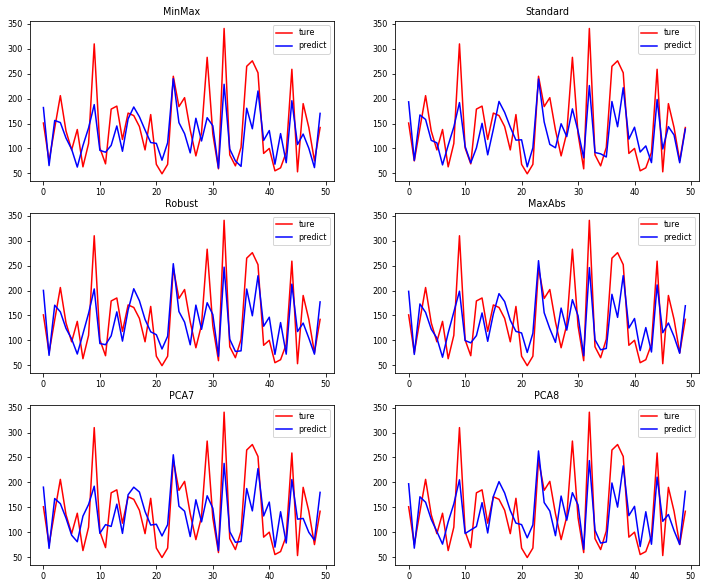

In [16]:
x = np.arange(0,50,1)
y_test = y[:50]

plt.figure(figsize=(12,10))
plt.subplot(3,2,1)
plt.title('MinMax')
plt.plot(x,y_test,'r',label='ture')
plt.plot(x,minmax_pred,'b',label='predict')
plt.legend(loc='upper right')

plt.subplot(3,2,2)
plt.title('Standard')
plt.plot(x,y_test,'r',label='ture')
plt.plot(x,stand_pred,'b',label='predict')
plt.legend(loc='upper right')

plt.subplot(3,2,3)
plt.title('Robust')
plt.plot(x,y_test,'r',label='ture')
plt.plot(x,robust_pred,'b',label='predict')
plt.legend(loc='upper right')

plt.subplot(3,2,4)
plt.title('MaxAbs')
plt.plot(x,y_test,'r',label='ture')
plt.plot(x,maxabs_pred,'b',label='predict')
plt.legend(loc='upper right')

plt.subplot(3,2,5)
plt.title('PCA7')
plt.plot(x,y_test,'r',label='ture')
plt.plot(x,pca7_pred,'b',label='predict')
plt.legend(loc='upper right')

plt.subplot(3,2,6)
plt.title('PCA8')
plt.plot(x,y_test,'r',label='ture')
plt.plot(x,pca8_pred,'b',label='predict')
plt.legend(loc='upper right')